Input data:
length =  1.8 , phase =  0.3 , t =  0.4 , c =  0.01 , num_lens =  18
f0 =  0.6875388202501894
Output data:
coords_lens =  [0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 1.05 1.15 1.25 1.35
 1.45 1.55 1.65 1.75]
knll_lens =  [2.27425581e-06 2.64178637e-06 3.07686835e-06 3.58260652e-06
 4.15121116e-06 4.75494699e-06 5.33710237e-06 5.81143782e-06
 6.08169333e-06 6.08169333e-06 5.81143782e-06 5.33710237e-06
 4.75494699e-06 4.15121116e-06 3.58260652e-06 3.07686835e-06
 2.64178637e-06 2.27425581e-06]
cnll_lens =  [0.01326204 0.01230499 0.01140186 0.01056648 0.00981618 0.00917185
 0.0086572  0.00829637 0.00810994 0.00810994 0.00829637 0.0086572
 0.00917185 0.00981618 0.01056648 0.01140186 0.01230499 0.01326204]
title =  Nonlinear Insertion: L=1.800 m, phase= 0.30, t=0.40, c=0.01 m^1/2


f0 =  0.6875388202501894  m
s_val = [0.045 0.135 0.225 0.315 0.405 0.495 0.585 0.675 0.765 0.855 0.945 1.035
 1.125 1.215 1.305 1.395 1.485 1.575 1.665 1.755]
s_center =  0.9450000000000002  m, beta_center =  0.6569851345258851  m, cnll_center =  0.008105461951831525  m


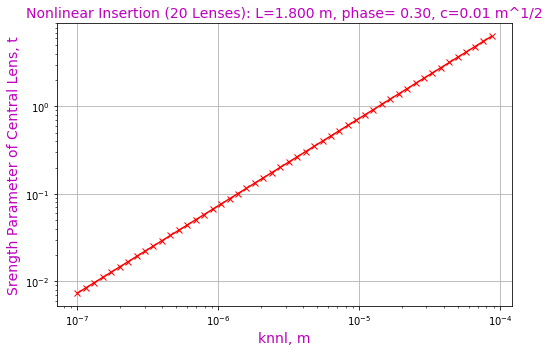

In [2]:
#
# This script is used to:
# 1) Calculate the distribution of the strength of the nonlinear lenses 
#    inside the nonlinear insertion;
# 2) Plot dependence of strength 't' of the central lens of nonlinear 
#    insertion lens on parameter 'knll' of this lens.
# 
# Script will be used as corresponding part of the script 
#      variabledNLsimulation_v2.py 
# to simulate IOTA ring with possibility to update the strength of the
# nonlinear lenses 'in-fly' of simulation
#
# Version 0, Yury Eidelman, 07/11/2019
#
import os, sys
import numpy as np
import inspect
import math

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec

def printAttributes(object,name,title):
#
# List of all attributes of 'object' for checking:
#
    attrList = inspect.getmembers(object)
    strTitle = "\nattrList ("+name+" = "+title+"):\n{}\n"
    print strTitle.format(attrList)

def plotParamLens(s_center,knll,cnll,title0,title1):
    knll_plot = np.zeros(len(knll))
    for n in range(len(knll)):
        knll_plot[n]=1.e6*knll[n]
# Another way - use gridspec
    fig = plt.figure(figsize=(15,5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,1]) 
    
    ax0 = plt.subplot(gs[0])
    plt.plot(s_center,knll_plot,'-x',color='r')
    ax0.set_xlabel('s, m')
    ax0.set_ylabel('10^6 * knll, m')
    ax0.set_title(title0,color='m',fontsize=14)
    ax0.grid(True)

    ax1 = plt.subplot(gs[1])
    plt.plot(s_center,cnll,'-x',color='r')
    ax1.set_xlabel('s, m')
    ax1.set_ylabel('cnll, m^1/2')
    ax1.set_title(title1,color='m',fontsize=14)
    ax1.grid(True)
       
    fig.tight_layout()
    plt.show()
    return

class NonlinearInsertion(object):
  
    # Generation of the nonlinear lenses as set of segments of the nonlinear insertion
    #
    # Source: 
    #   1) Nonlinear Accelerator Lattices with One and Two Analytic Invariants.
    #      V. Danilov and S. Nagaitsev. Phys. Rev. ST Accel. Beams 13, 084002 (2010);
    #      https://journals.aps.org/prab/pdf/10.1103/PhysRevSTAB.13.084002.  
    #   2) Complex Representation of Potentials and Fields for the Nonlinear 
    #      Magnetic Insert of the Integrable Optics Test Accelerator.
    #      Chad Mitchell. March 2017; https://esholarship.org/uc/item/7dt4t236.
    #   3) Madx CERN User Guide. Chapter 10.10 - Nonlinear Lens with Elliptical Potential.
    #      http://mad.web.cern.ch/mad/
    #
    # Input attributes:
    #   length:     the length of the nonlinear inserttion (float, m);
    #   phase:      the phase advance modulo 2pi through the nonlinear insertion;
    #   t:          the nonlinear strength parameter (float, dimensionless, defaults to 0.1);
    #   c:          the nonlinear aperture parameter (float, m^1/2, is defined by poles in the x-axis,
    #               defaults to 0.01);
    #   num_lens:   the number of lonlinear lenses as  an parts of the nonlinear insertion (int, 
    #               defaults to 18).
    #   
    # Output attributes:
    #   s_vals (ndArray): coordinates of the center of each nonlinear lens (float ndArray, m);
    #   knll (ndArray):   "strength" of each nonlinear lens (float ndArray, m);
    #   cnll (ndArray):   aperture parameters for each nonlinear lens (float ndArray, m^1/2).
    #   
    def __init__(self, length, phase, t = 0.1, c = 0.01, num_lens = 20):
        print "Input data:\nlength = ",length,", phase = ",phase,", t = ",t, \
            ", c = ",c,", num_lens = ",num_lens
        self.length = length
        self.phase = phase
        self.t = t
        self._c = c
        self.num_lens = num_lens
# Aperture parameter c must be positive:
    @property
    def c(self):
        return self._c
    @c.setter
    def c(self, cval):
        if cval < 0:
            raise ValueError("Aperture parameter c must be positive")     
        self._c = c

    def generate_lens(self,flag):
        indxShift = num_lens-2*((num_lens+1)/2)+1
# Focal length f0 of the insertion (m):
        f0 = self.length/4.0*(1.0+1.0/np.tan(np.pi*self.phase)**2)
        print "f0 = ",f0
# Coordinates s_vals of the center of each nonlinear lens (m):
        first_lens = .5*(self.length/self.num_lens)
        last_lens = self.length - first_lens
        s_vals = np.linspace(first_lens,last_lens,self.num_lens) 
        self.s_vals = s_vals
        
# Set of rge strucrural beta-function of nonlinear magnet (m):
        beta_n = self.length*(1.-s_vals*(self.length-s_vals)/self.length/f0)/np.sqrt(1.0-(1.0-self.length/2.0/f0)**2)
#        self.betas = beta_n
        
        cnll = self.c*np.sqrt(beta_n)

        knn = self.t*self.length/self.num_lens/beta_n**2
        knll = knn*cnll**2
# Sequence of lenses start from the minimal value of knll:
        self.cnll = cnll
        self.knll = knll
# Sequence of lenses start from the maximal value of knll:
        if flag == 2:
            cnll_help = []
            knll_help = []
            indMax = 0
            for n in range(num_lens-1):
                if knll[n] < knll[n+1]:
                    indMax = n+1
                else:
                    break
            print "indMax = ",indMax
            for n in range (num_lens):
                if n <= indMax:
                    cnll_help.append(float(cnll[indMax-n]))
                    knll_help.append(float(knll[indMax-n]))
                else:
                    cnll_help.append(float(cnll[n-indMax-indxShift]))
                    knll_help.append(float(knll[n-indMax-indxShift]))
            self.cnll = cnll_help
            self.knll = knll_help
        return self
        
def validate_lens(self, beta_values):
#
# Method to valdate parameters of the nonlinear lens from method
# 'generate_lens', using approach from S. Romanov MADX-structure
# of the IOTA ring.
#
    return

# Verifying of the script:    
l0 = 1.8
mu0 = .3
cval = .01
tval = .4
num_lens = 18

#-------- Only for checking: ------------
# insertionNL  = NonlinearInsertion(l0, mu0, tval, cval, num_lens)
# To recognize attributes of 'insertionNL':
# printAttributes(insertionNL,'insertionNL','NonlinearInsertion(l0, mu0, cval, tval)')
# dataInsertion = insertionNL.generate_lens()
# To recognize attributes of '':
# printAttributes(dataInsertion,'dataInsertion','insertionNL.generate_lens()')
#-------End of checking -------------

dataInsertion = NonlinearInsertion(l0, mu0, tval, cval, num_lens).generate_lens(1)
coords_lens = dataInsertion.s_vals
knll_lens = dataInsertion.knll
cnll_lens = dataInsertion.cnll
print "Output data:"
print "coords_lens = ",coords_lens
print "knll_lens = ",knll_lens
print "cnll_lens = ",cnll_lens

title = "Nonlinear Insertion: L={:.3f} m, phase= {:.2f}, t={:.2f}, c={:.2f} m^1/2".format(l0,mu0,tval,cval)
print "title = ",title
plotParamLens(coords_lens,knll_lens,cnll_lens,title,title)

#
# Result shows, that input value 'tval' strength ('knll') of the set of lenses corresponds to the
# central lens(es) of nonlinear insertion!
#

#
# "Reverse" dependence dimensionless strength 'tval' of nonlinear central lens on 
# parameter 'knll' of this lens
#
nPoints = 50
knll = np.zeros(nPoints)
t = np.zeros(nPoints)
knll_logMin = math.log10(1.e-7)
knll_logMax = math.log10(1.e-4)

l0 = 1.8
mu0 = .3
cval = .01
num_lens = 20

# Focal length f0 of the insertion (m):
f0 = l0/4.0*(1.0+1.0/np.tan(np.pi*mu0)**2)
print "f0 = ",f0," m"

# Coordinates of the center of the nonlinear lenses in the nonlinear inserion (m):
first_lens_center = .5*(l0/num_lens)
last_lens_center = l0 - first_lens_center
s_vals = np.linspace(first_lens_center,last_lens_center,num_lens) 
print "s_val =",s_vals        
# Coordinate of the center of the nonlinear lens in the middle of nonlinear inserion (m):
s_center = s_vals[(num_lens+1)/2]
# Structural beta-function of the nonlinear magnet in the middle of nonlinear inserion (m):
beta_center = l0*(1.-s_center*(l0-s_center)/l0/f0)/np.sqrt(1.0-(1.0-l0/2.0/f0)**2)
cnll_center = cval*np.sqrt(beta_center)
print "s_center = ",s_center," m, beta_center = ",beta_center," m, cnll_center = ",cnll_center," m"

for n in range(nPoints):
    knll_log10 = knll_logMin + n*(knll_logMax - knll_logMin)/nPoints
    knll[n] = math.pow(10.,knll_log10)
    t[n] = knll[n]*beta_center**2/(l0/num_lens*cnll_center**2)
    
fig_10 = plt.figure(figsize=(15,5))
gs_10 = gridspec.GridSpec(1, 2, width_ratios=[1,1]) 
    
ax_10 = plt.subplot(gs_10[0])
# plt.semilogx(knll,t,'-x',color='r')
plt.loglog(knll,t,'-x',color='r')
ax_10.set_xlabel('knnl, m',color='m',fontsize=14)
ax_10.set_ylabel('Srength Parameter of Central Lens, t',color='m',fontsize=14)

# start, end = ax_10.get_xlim()
# ax_10.xaxis.set_ticks(np.arange(start, end, (end-start)/30))

title_t = "Nonlinear Insertion ({} Lenses): L={:.3f} m, phase= {:.2f}, c={:.2f} m^1/2". \
          format(num_lens, l0, mu0, cval)
ax_10.set_title(title_t,color='m',fontsize=14)
ax_10.grid(True)

fig_10.tight_layout()
plt.show()
    

#-------- Only for checking of LaTex in Python: ------------
# from IPython.display import display, Math
# title1 = r'Nonlinear Insertion: L={}'.format(l0)+' m, \mu_0={}'.format(mu0)+r' t={}'.format(tval)
# title1 += r', '+r'c={}'.format(cval)+r'\sqrt{m}'
# print "title1 = ",Math(title1)
# display(Math(title1))



IOTA Nonlinear lattice: .../ioptics/ioptics/lattices/Iota8-2/lattice_1IO_nll_center.madx 


These distributions were constructed using 'synergia.optics.generated_matched_bunch_transverse' method
and plotted using two methods - 'pltbunch.plot_bunch' from the code synergia
and 'plotcoordDistr' from this script (to verify method 'plotcoordDistr'):


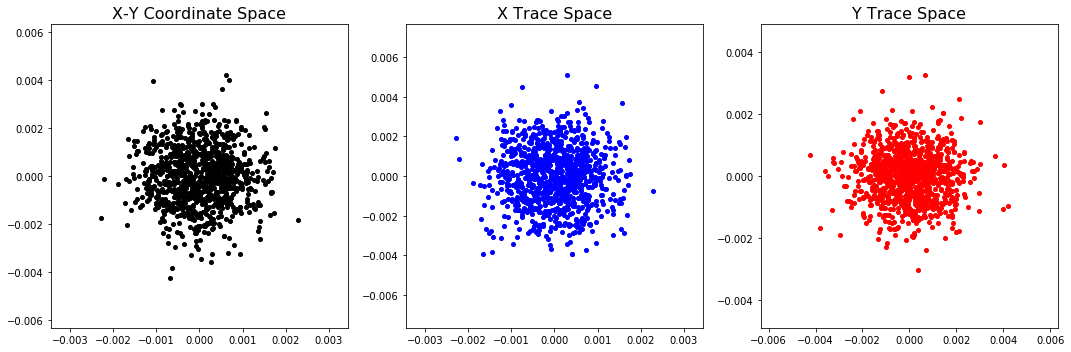


Total number of particles (= -1 to interrupt simulation): 1000

Total number if turns (= -1 to interrupt simulation): 1000

Periodicity (in turns) to update the parameters and distribution plots 
(nonlinear structure; = -1 to interrupt simulation) 20


steps for magnification:  50



updateOutputFlag (0 - no, 1 - yes, -1 - to interrupt simulation): 1

Magnification type 
(1 - relative, 2 - absolute, 0 - to interrupt simulation): 2



Information for help (20 nonlinear lenses inside of the insertion): 




Initial value 't_i' of the strength of the central (!) nonlinear lens 
 (-1.- to interrupt simulation): 0.

Final value 't_f' of the strength of nonlinear lens 
 (-1.- to interrupt simulation): 1.


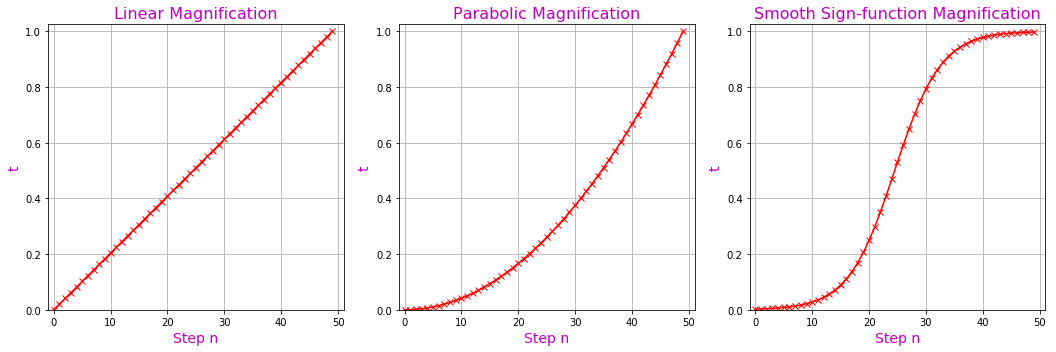


Your selection of the law magnification     
(1 - linear, 2 - parabolic, 3 - smooth sign-function; -1 - exit):  3


Your selection of law magnification:  3

################################################################
###
###            Parameters for simulation:
###
###     Particles in the bunch =  1000
###     Total number of turns =  1000
###     Periodicity (in turns) to update the parameters =  20
###     magnificationType =  2
###     For absolute magnification (AM) initial value t_i =  0.0
###     For absolute magnification (AM) final value t_f =  1.0
###     Law of magnification:  smooth sign-function
###     Steps in magnification:  50
###
###        Predefined parameters for nonlinear insertion:
###
###     Length =  1.8  m
###     Phase =  0.3  rad (/2pi)
###     Aperture factor =  0.01  m^(1/2)
###     Number of lens inside insertion =  20
###
################################################################

Strengths 't' and corresponding values 'knll' of cenrtal lens for absolute magnification:
   t[0]] = 0.00247262315663 ==> knll = 3.38723164958e-08 m
   t[1]] = 0.00315658787481 

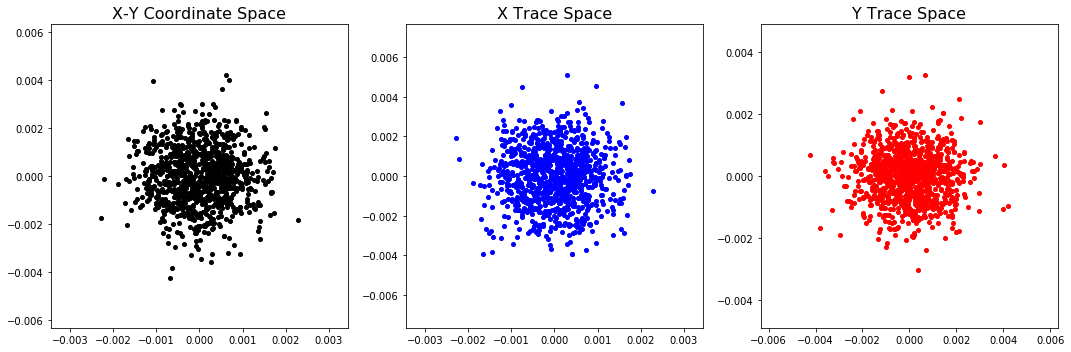

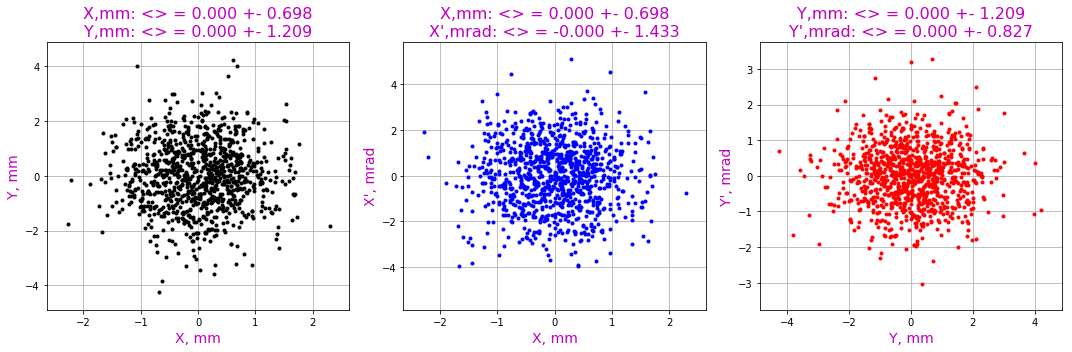


-------------------

           Nonlinear parameters will be CHANGED after each 20 turns

-------------------

Modified lattice (absolute magnification): Step  0
n.11 :  knll= 5.479576037e-06  -->  4.3241908196e-08
Turn   1 is completed (CPU time =  0.550 seconds)
Turn   2 is completed (CPU time =  0.000 seconds)
Turn   3 is completed (CPU time =  0.000 seconds)
Turn   4 is completed (CPU time =  0.010 seconds)
Turn   5 is completed (CPU time =  0.000 seconds)
Turn   6 is completed (CPU time =  0.000 seconds)
Turn   7 is completed (CPU time =  0.000 seconds)
Turn   8 is completed (CPU time =  0.010 seconds)
Turn   9 is completed (CPU time =  0.000 seconds)
Turn  10 is completed (CPU time =  0.000 seconds)
Turn  11 is completed (CPU time =  0.000 seconds)
Turn  12 is completed (CPU time =  0.010 seconds)
Turn  13 is completed (CPU time =  0.000 seconds)
Turn  14 is completed (CPU time =  0.000 seconds)
Turn  15 is completed (CPU time =  0.000 seconds)
Turn  16 is completed (CPU time = 

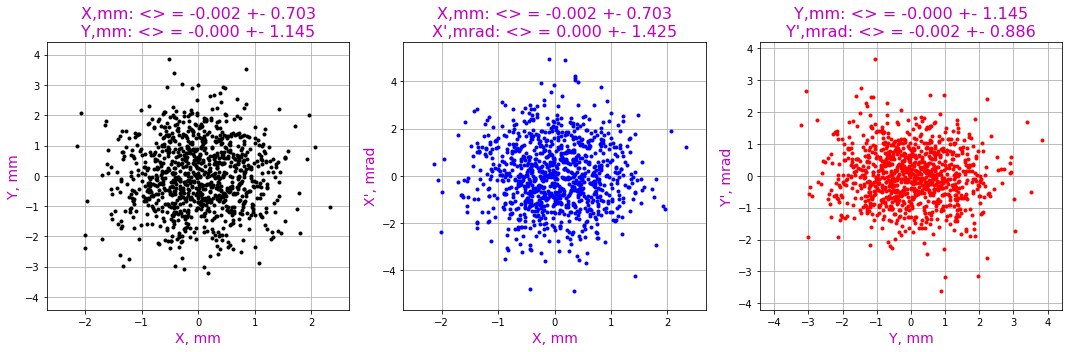

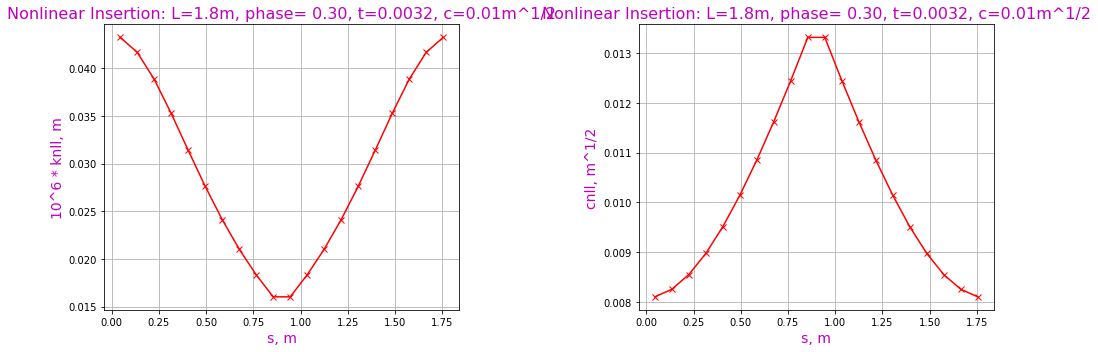


              After 20 turns:

Modified lattice (absolute magnification): Step  1
n.11 :  knll= 4.3241908196e-08  -->  4.3241908196e-08

Update and plotting are completed (CPU time =  1.920 seconds)

Turn  21 is completed (CPU time =  0.000 seconds)
Turn  22 is completed (CPU time =  0.000 seconds)
Turn  23 is completed (CPU time =  0.010 seconds)
Turn  24 is completed (CPU time =  0.000 seconds)
Turn  25 is completed (CPU time =  0.000 seconds)
Turn  26 is completed (CPU time =  0.010 seconds)
Turn  27 is completed (CPU time =  0.000 seconds)
Turn  28 is completed (CPU time =  0.000 seconds)
Turn  29 is completed (CPU time =  0.000 seconds)
Turn  30 is completed (CPU time =  0.010 seconds)
Turn  31 is completed (CPU time =  0.000 seconds)
Turn  32 is completed (CPU time =  0.000 seconds)
Turn  33 is completed (CPU time =  0.000 seconds)
Turn  34 is completed (CPU time =  0.000 seconds)
Turn  35 is completed (CPU time =  0.000 seconds)
Turn  36 is completed (CPU time =  0.000 seconds)


              After 40 turns:

Modified lattice (absolute magnification): Step  2
n.11 :  knll= 4.3241908196e-08  -->  5.51928016646e-08

Update and plotting are completed (CPU time =  1.910 seconds)

Turn  41 is completed (CPU time =  0.010 seconds)
Turn  42 is completed (CPU time =  0.000 seconds)
Turn  43 is completed (CPU time =  0.000 seconds)
Turn  44 is completed (CPU time =  0.000 seconds)
Turn  45 is completed (CPU time =  0.000 seconds)
Turn  46 is completed (CPU time =  0.000 seconds)
Turn  47 is completed (CPU time =  0.010 seconds)
Turn  48 is completed (CPU time =  0.000 seconds)
Turn  49 is completed (CPU time =  0.000 seconds)
Turn  50 is completed (CPU time =  0.000 seconds)
Turn  51 is completed (CPU time =  0.000 seconds)
Turn  52 is completed (CPU time =  0.000 seconds)
Turn  53 is completed (CPU time =  0.000 seconds)
Turn  54 is completed (CPU time =  0.000 seconds)
Turn  55 is completed (CPU time =  0.000 seconds)
Turn  56 is completed (CPU time =  0.000 seconds

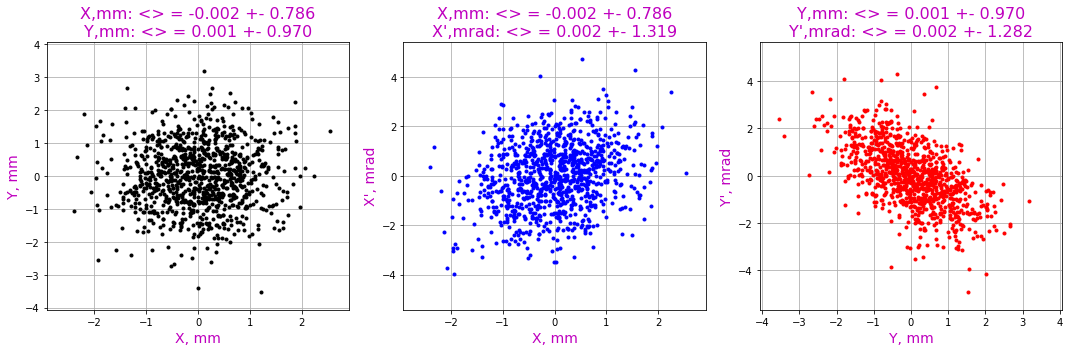

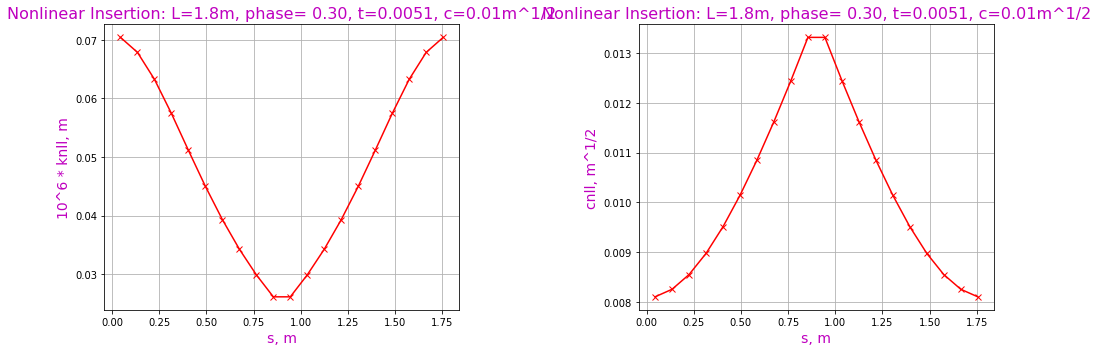


              After 60 turns:

Modified lattice (absolute magnification): Step  3
n.11 :  knll= 5.51928016646e-08  -->  7.04295639454e-08

Update and plotting are completed (CPU time =  1.850 seconds)

Turn  61 is completed (CPU time =  0.010 seconds)
Turn  62 is completed (CPU time =  0.000 seconds)
Turn  63 is completed (CPU time =  0.000 seconds)
Turn  64 is completed (CPU time =  0.000 seconds)
Turn  65 is completed (CPU time =  0.000 seconds)
Turn  66 is completed (CPU time =  0.000 seconds)
Turn  67 is completed (CPU time =  0.000 seconds)
Turn  68 is completed (CPU time =  0.000 seconds)
Turn  69 is completed (CPU time =  0.000 seconds)
Turn  70 is completed (CPU time =  0.000 seconds)
Turn  71 is completed (CPU time =  0.010 seconds)
Turn  72 is completed (CPU time =  0.000 seconds)
Turn  73 is completed (CPU time =  0.000 seconds)
Turn  74 is completed (CPU time =  0.000 seconds)
Turn  75 is completed (CPU time =  0.000 seconds)
Turn  76 is completed (CPU time =  0.010 second

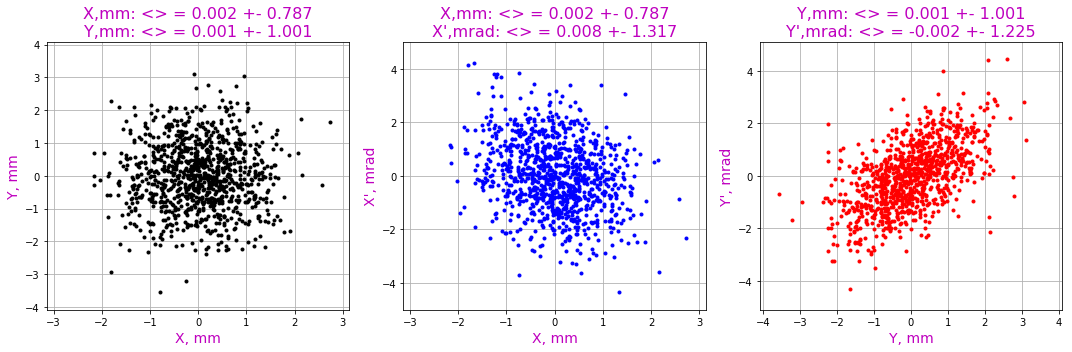


              After 80 turns:

Modified lattice (absolute magnification): Step  4
n.11 :  knll= 7.04295639454e-08  -->  8.98449534456e-08

Update and plotting are completed (CPU time =  1.860 seconds)

Turn  81 is completed (CPU time =  0.010 seconds)
Turn  82 is completed (CPU time =  0.000 seconds)
Turn  83 is completed (CPU time =  0.000 seconds)
Turn  84 is completed (CPU time =  0.000 seconds)
Turn  85 is completed (CPU time =  0.010 seconds)
Turn  86 is completed (CPU time =  0.000 seconds)
Turn  87 is completed (CPU time =  0.000 seconds)
Turn  88 is completed (CPU time =  0.010 seconds)
Turn  89 is completed (CPU time =  0.000 seconds)
Turn  90 is completed (CPU time =  0.000 seconds)
Turn  91 is completed (CPU time =  0.000 seconds)
Turn  92 is completed (CPU time =  0.010 seconds)
Turn  93 is completed (CPU time =  0.000 seconds)
Turn  94 is completed (CPU time =  0.000 seconds)
Turn  95 is completed (CPU time =  0.000 seconds)
Turn  96 is completed (CPU time =  0.000 second


              After 100 turns:

Modified lattice (absolute magnification): Step  5
n.11 :  knll= 8.98449534456e-08  -->  1.14567609517e-07

Update and plotting are completed (CPU time =  1.930 seconds)

Turn 101 is completed (CPU time =  0.000 seconds)
Turn 102 is completed (CPU time =  0.010 seconds)
Turn 103 is completed (CPU time =  0.000 seconds)
Turn 104 is completed (CPU time =  0.000 seconds)
Turn 105 is completed (CPU time =  0.000 seconds)
Turn 106 is completed (CPU time =  0.010 seconds)
Turn 107 is completed (CPU time =  0.000 seconds)
Turn 108 is completed (CPU time =  0.000 seconds)
Turn 109 is completed (CPU time =  0.000 seconds)
Turn 110 is completed (CPU time =  0.010 seconds)
Turn 111 is completed (CPU time =  0.000 seconds)
Turn 112 is completed (CPU time =  0.000 seconds)
Turn 113 is completed (CPU time =  0.010 seconds)
Turn 114 is completed (CPU time =  0.000 seconds)
Turn 115 is completed (CPU time =  0.000 seconds)
Turn 116 is completed (CPU time =  0.000 secon

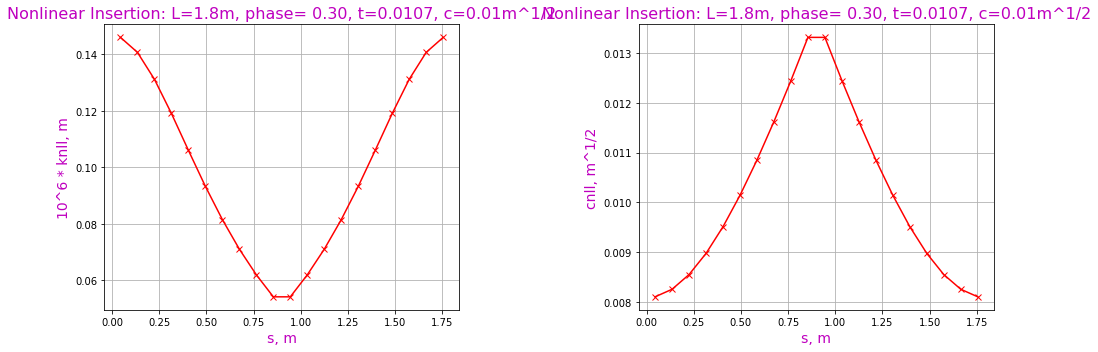


              After 120 turns:

Modified lattice (absolute magnification): Step  6
n.11 :  knll= 1.14567609517e-07  -->  1.46020211581e-07

Update and plotting are completed (CPU time =  1.880 seconds)

Turn 121 is completed (CPU time =  0.010 seconds)
Turn 122 is completed (CPU time =  0.000 seconds)
Turn 123 is completed (CPU time =  0.000 seconds)
Turn 124 is completed (CPU time =  0.010 seconds)
Turn 125 is completed (CPU time =  0.000 seconds)
Turn 126 is completed (CPU time =  0.000 seconds)
Turn 127 is completed (CPU time =  0.000 seconds)
Turn 128 is completed (CPU time =  0.000 seconds)
Turn 129 is completed (CPU time =  0.000 seconds)
Turn 130 is completed (CPU time =  0.000 seconds)
Turn 131 is completed (CPU time =  0.010 seconds)
Turn 132 is completed (CPU time =  0.000 seconds)
Turn 133 is completed (CPU time =  0.000 seconds)
Turn 134 is completed (CPU time =  0.000 seconds)
Turn 135 is completed (CPU time =  0.010 seconds)
Turn 136 is completed (CPU time =  0.000 secon


              After 140 turns:

Modified lattice (absolute magnification): Step  7
n.11 :  knll= 1.46020211581e-07  -->  1.85989371863e-07

Update and plotting are completed (CPU time =  1.980 seconds)

Turn 141 is completed (CPU time =  0.000 seconds)
Turn 142 is completed (CPU time =  0.010 seconds)
Turn 143 is completed (CPU time =  0.000 seconds)
Turn 144 is completed (CPU time =  0.000 seconds)
Turn 145 is completed (CPU time =  0.000 seconds)
Turn 146 is completed (CPU time =  0.000 seconds)
Turn 147 is completed (CPU time =  0.000 seconds)
Turn 148 is completed (CPU time =  0.000 seconds)
Turn 149 is completed (CPU time =  0.000 seconds)
Turn 150 is completed (CPU time =  0.010 seconds)
Turn 151 is completed (CPU time =  0.000 seconds)
Turn 152 is completed (CPU time =  0.000 seconds)
Turn 153 is completed (CPU time =  0.000 seconds)
Turn 154 is completed (CPU time =  0.010 seconds)
Turn 155 is completed (CPU time =  0.000 seconds)
Turn 156 is completed (CPU time =  0.000 secon

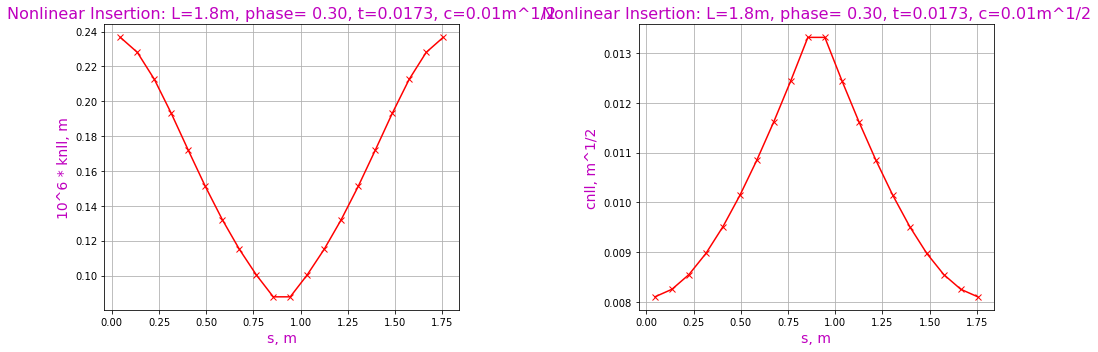


              After 160 turns:

Modified lattice (absolute magnification): Step  8
n.11 :  knll= 1.85989371863e-07  -->  2.36707948942e-07

Update and plotting are completed (CPU time =  1.930 seconds)

Turn 161 is completed (CPU time =  0.010 seconds)
Turn 162 is completed (CPU time =  0.000 seconds)
Turn 163 is completed (CPU time =  0.000 seconds)
Turn 164 is completed (CPU time =  0.000 seconds)
Turn 165 is completed (CPU time =  0.000 seconds)
Turn 166 is completed (CPU time =  0.000 seconds)
Turn 167 is completed (CPU time =  0.010 seconds)
Turn 168 is completed (CPU time =  0.000 seconds)
Turn 169 is completed (CPU time =  0.000 seconds)
Turn 170 is completed (CPU time =  0.000 seconds)
Turn 171 is completed (CPU time =  0.010 seconds)
Turn 172 is completed (CPU time =  0.000 seconds)
Turn 173 is completed (CPU time =  0.000 seconds)
Turn 174 is completed (CPU time =  0.000 seconds)
Turn 175 is completed (CPU time =  0.000 seconds)
Turn 176 is completed (CPU time =  0.000 secon

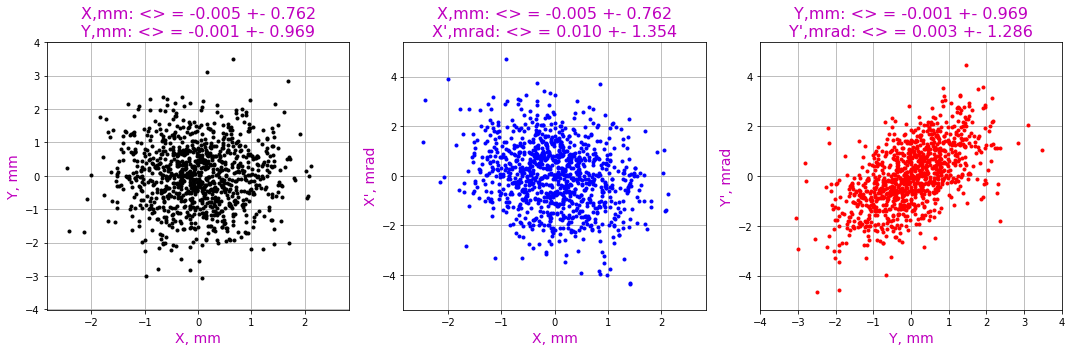


              After 180 turns:

Modified lattice (absolute magnification): Step  9
n.11 :  knll= 2.36707948942e-07  -->  3.0094925718e-07

Update and plotting are completed (CPU time =  1.900 seconds)

Turn 181 is completed (CPU time =  0.010 seconds)
Turn 182 is completed (CPU time =  0.000 seconds)
Turn 183 is completed (CPU time =  0.000 seconds)
Turn 184 is completed (CPU time =  0.000 seconds)
Turn 185 is completed (CPU time =  0.000 seconds)
Turn 186 is completed (CPU time =  0.010 seconds)
Turn 187 is completed (CPU time =  0.000 seconds)
Turn 188 is completed (CPU time =  0.000 seconds)
Turn 189 is completed (CPU time =  0.000 seconds)
Turn 190 is completed (CPU time =  0.000 seconds)
Turn 191 is completed (CPU time =  0.000 seconds)
Turn 192 is completed (CPU time =  0.000 seconds)
Turn 193 is completed (CPU time =  0.000 seconds)
Turn 194 is completed (CPU time =  0.010 seconds)
Turn 195 is completed (CPU time =  0.000 seconds)
Turn 196 is completed (CPU time =  0.000 second

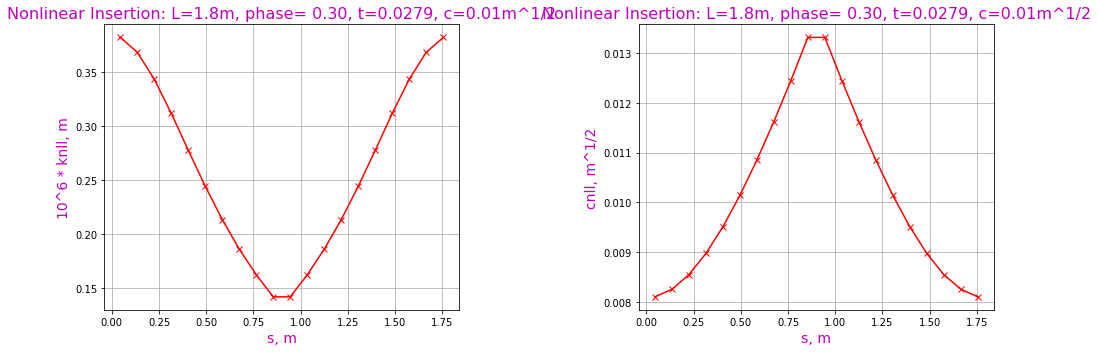


              After 200 turns:

Modified lattice (absolute magnification): Step  10
n.11 :  knll= 3.0094925718e-07  -->  3.82130430873e-07

Update and plotting are completed (CPU time =  1.910 seconds)

Turn 201 is completed (CPU time =  0.010 seconds)
Turn 202 is completed (CPU time =  0.000 seconds)
Turn 203 is completed (CPU time =  0.000 seconds)
Turn 204 is completed (CPU time =  0.000 seconds)
Turn 205 is completed (CPU time =  0.000 seconds)
Turn 206 is completed (CPU time =  0.000 seconds)
Turn 207 is completed (CPU time =  0.000 seconds)
Turn 208 is completed (CPU time =  0.000 seconds)
Turn 209 is completed (CPU time =  0.000 seconds)
Turn 210 is completed (CPU time =  0.010 seconds)
Turn 211 is completed (CPU time =  0.000 seconds)
Turn 212 is completed (CPU time =  0.000 seconds)
Turn 213 is completed (CPU time =  0.010 seconds)
Turn 214 is completed (CPU time =  0.000 seconds)
Turn 215 is completed (CPU time =  0.000 seconds)
Turn 216 is completed (CPU time =  0.000 secon

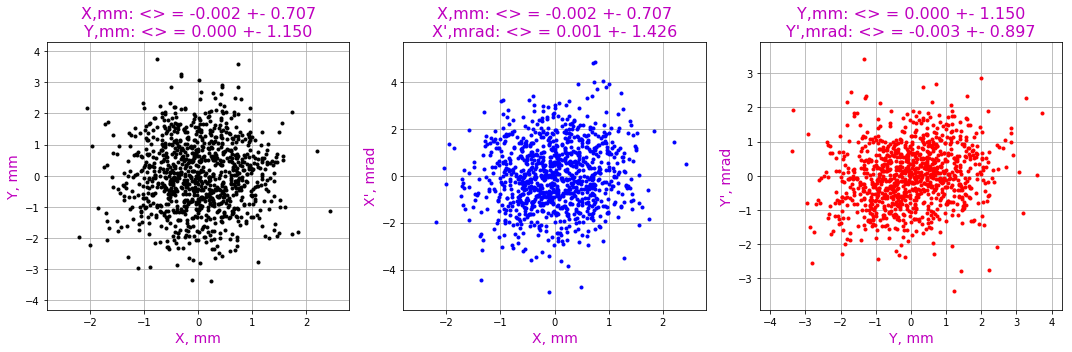

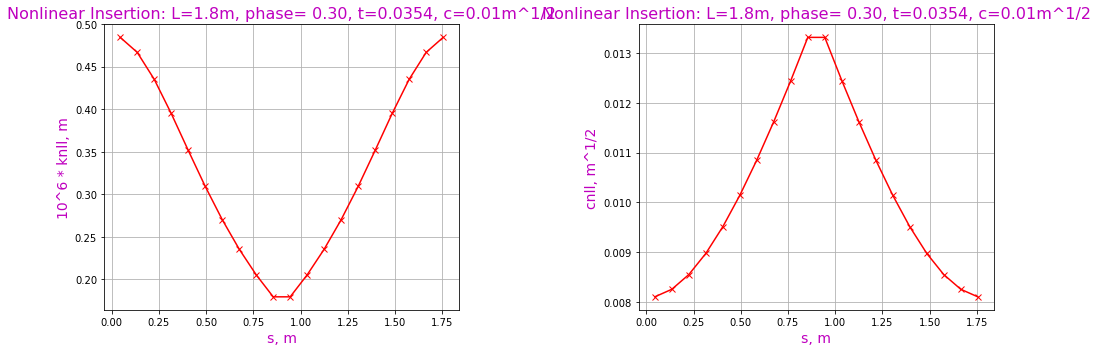


              After 220 turns:

Modified lattice (absolute magnification): Step  11
n.11 :  knll= 3.82130430873e-07  -->  4.84418487419e-07

Update and plotting are completed (CPU time =  1.910 seconds)

Turn 221 is completed (CPU time =  0.000 seconds)
Turn 222 is completed (CPU time =  0.010 seconds)
Turn 223 is completed (CPU time =  0.000 seconds)
Turn 224 is completed (CPU time =  0.000 seconds)
Turn 225 is completed (CPU time =  0.000 seconds)
Turn 226 is completed (CPU time =  0.000 seconds)
Turn 227 is completed (CPU time =  0.000 seconds)
Turn 228 is completed (CPU time =  0.000 seconds)
Turn 229 is completed (CPU time =  0.010 seconds)
Turn 230 is completed (CPU time =  0.000 seconds)
Turn 231 is completed (CPU time =  0.000 seconds)
Turn 232 is completed (CPU time =  0.000 seconds)
Turn 233 is completed (CPU time =  0.010 seconds)
Turn 234 is completed (CPU time =  0.000 seconds)
Turn 235 is completed (CPU time =  0.000 seconds)
Turn 236 is completed (CPU time =  0.000 seco

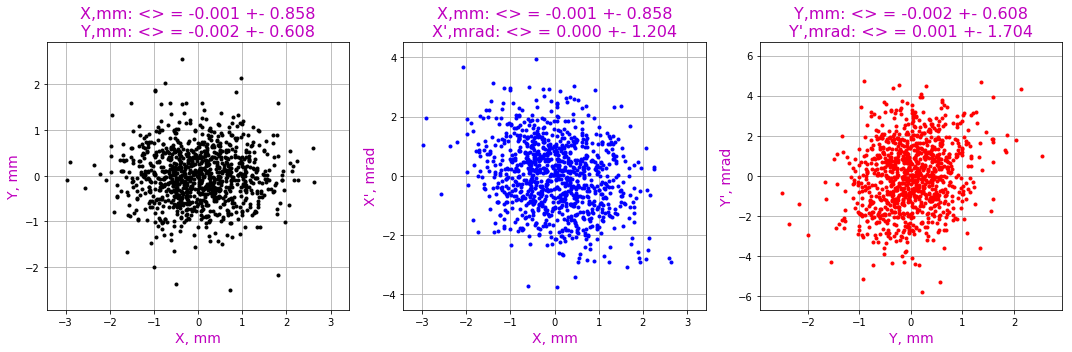

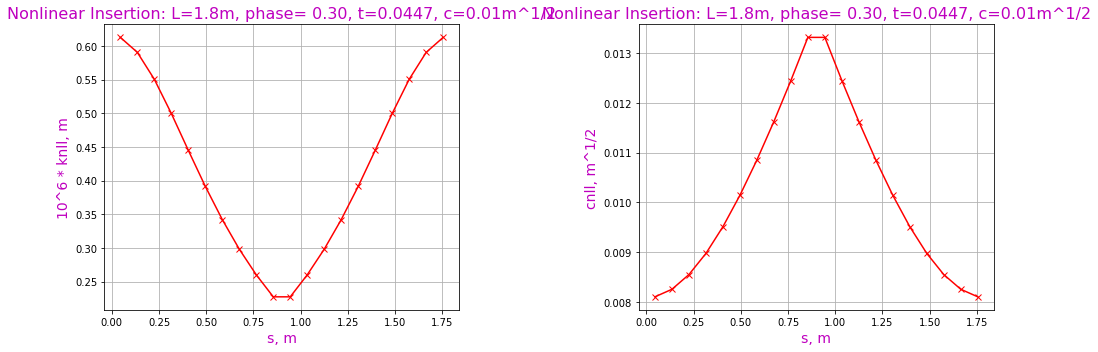


              After 240 turns:

Modified lattice (absolute magnification): Step  12
n.11 :  knll= 4.84418487419e-07  -->  6.12826830461e-07

Update and plotting are completed (CPU time =  1.990 seconds)

Turn 241 is completed (CPU time =  0.000 seconds)
Turn 242 is completed (CPU time =  0.010 seconds)
Turn 243 is completed (CPU time =  0.000 seconds)
Turn 244 is completed (CPU time =  0.000 seconds)
Turn 245 is completed (CPU time =  0.010 seconds)
Turn 246 is completed (CPU time =  0.000 seconds)
Turn 247 is completed (CPU time =  0.000 seconds)
Turn 248 is completed (CPU time =  0.000 seconds)
Turn 249 is completed (CPU time =  0.000 seconds)
Turn 250 is completed (CPU time =  0.000 seconds)
Turn 251 is completed (CPU time =  0.000 seconds)
Turn 252 is completed (CPU time =  0.010 seconds)
Turn 253 is completed (CPU time =  0.000 seconds)
Turn 254 is completed (CPU time =  0.000 seconds)
Turn 255 is completed (CPU time =  0.000 seconds)
Turn 256 is completed (CPU time =  0.000 seco

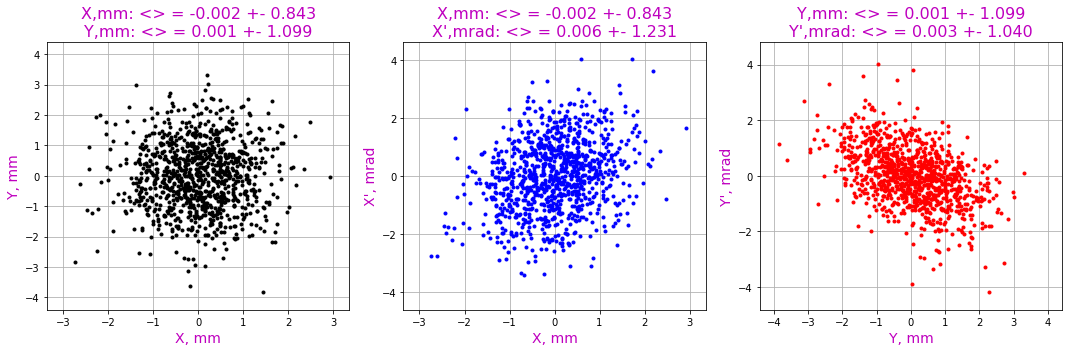

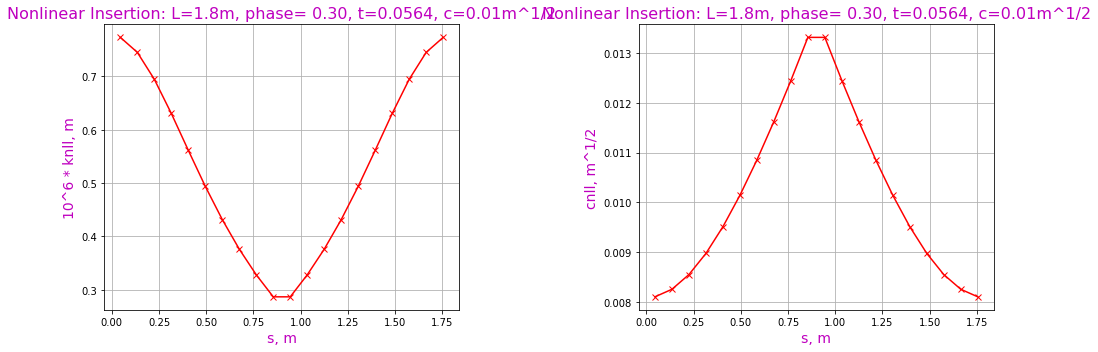


              After 260 turns:

Modified lattice (absolute magnification): Step  13
n.11 :  knll= 6.12826830461e-07  -->  7.73281481445e-07

Update and plotting are completed (CPU time =  1.940 seconds)

Turn 261 is completed (CPU time =  0.000 seconds)
Turn 262 is completed (CPU time =  0.000 seconds)
Turn 263 is completed (CPU time =  0.000 seconds)
Turn 264 is completed (CPU time =  0.000 seconds)
Turn 265 is completed (CPU time =  0.000 seconds)
Turn 266 is completed (CPU time =  0.000 seconds)
Turn 267 is completed (CPU time =  0.000 seconds)
Turn 268 is completed (CPU time =  0.010 seconds)
Turn 269 is completed (CPU time =  0.000 seconds)
Turn 270 is completed (CPU time =  0.000 seconds)
Turn 271 is completed (CPU time =  0.000 seconds)
Turn 272 is completed (CPU time =  0.010 seconds)
Turn 273 is completed (CPU time =  0.000 seconds)
Turn 274 is completed (CPU time =  0.000 seconds)
Turn 275 is completed (CPU time =  0.000 seconds)
Turn 276 is completed (CPU time =  0.000 seco

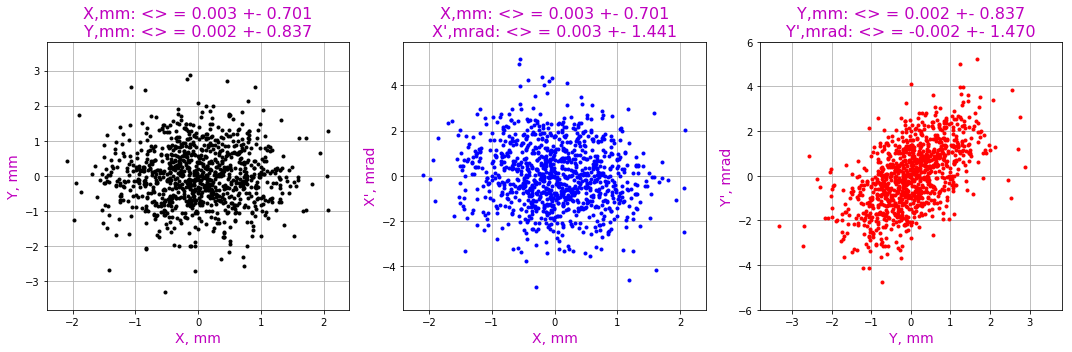

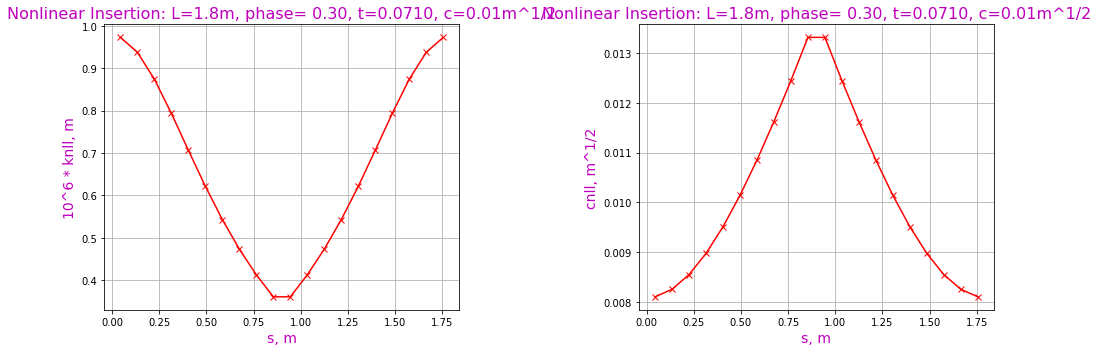


              After 280 turns:

Modified lattice (absolute magnification): Step  14
n.11 :  knll= 7.73281481445e-07  -->  9.72625008964e-07

Update and plotting are completed (CPU time =  1.980 seconds)

Turn 281 is completed (CPU time =  0.010 seconds)
Turn 282 is completed (CPU time =  0.000 seconds)
Turn 283 is completed (CPU time =  0.010 seconds)
Turn 284 is completed (CPU time =  0.000 seconds)
Turn 285 is completed (CPU time =  0.000 seconds)
Turn 286 is completed (CPU time =  0.000 seconds)
Turn 287 is completed (CPU time =  0.000 seconds)
Turn 288 is completed (CPU time =  0.000 seconds)
Turn 289 is completed (CPU time =  0.000 seconds)
Turn 290 is completed (CPU time =  0.010 seconds)
Turn 291 is completed (CPU time =  0.000 seconds)
Turn 292 is completed (CPU time =  0.000 seconds)
Turn 293 is completed (CPU time =  0.010 seconds)
Turn 294 is completed (CPU time =  0.000 seconds)
Turn 295 is completed (CPU time =  0.000 seconds)
Turn 296 is completed (CPU time =  0.000 seco

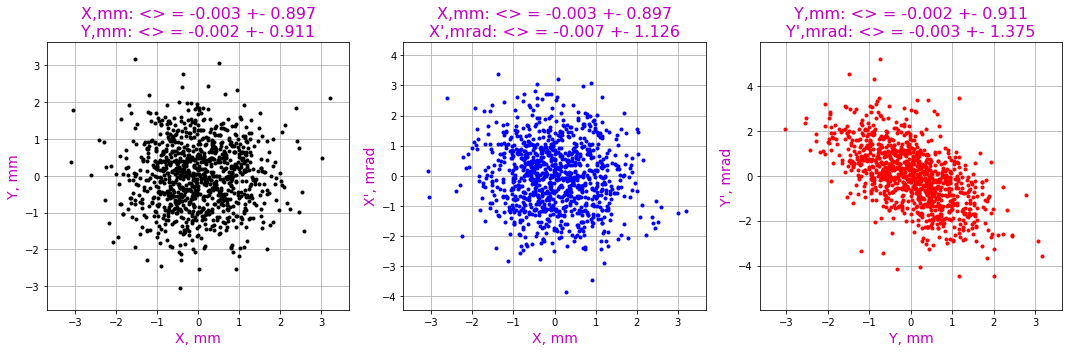

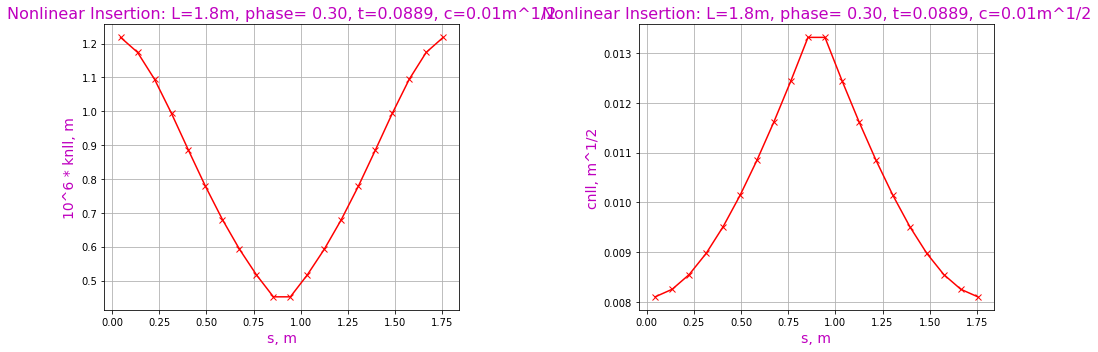


              After 300 turns:

Modified lattice (absolute magnification): Step  15
n.11 :  knll= 9.72625008964e-07  -->  1.21851267744e-06

Update and plotting are completed (CPU time =  1.930 seconds)

Turn 301 is completed (CPU time =  0.000 seconds)
Turn 302 is completed (CPU time =  0.000 seconds)
Turn 303 is completed (CPU time =  0.000 seconds)
Turn 304 is completed (CPU time =  0.000 seconds)
Turn 305 is completed (CPU time =  0.000 seconds)
Turn 306 is completed (CPU time =  0.010 seconds)
Turn 307 is completed (CPU time =  0.000 seconds)
Turn 308 is completed (CPU time =  0.000 seconds)
Turn 309 is completed (CPU time =  0.000 seconds)
Turn 310 is completed (CPU time =  0.010 seconds)
Turn 311 is completed (CPU time =  0.000 seconds)
Turn 312 is completed (CPU time =  0.000 seconds)
Turn 313 is completed (CPU time =  0.000 seconds)
Turn 314 is completed (CPU time =  0.000 seconds)
Turn 315 is completed (CPU time =  0.000 seconds)
Turn 316 is completed (CPU time =  0.000 seco


              After 320 turns:

Modified lattice (absolute magnification): Step  16
n.11 :  knll= 1.21851267744e-06  -->  1.51914244623e-06

Update and plotting are completed (CPU time =  1.970 seconds)

Turn 321 is completed (CPU time =  0.010 seconds)
Turn 322 is completed (CPU time =  0.000 seconds)
Turn 323 is completed (CPU time =  0.000 seconds)
Turn 324 is completed (CPU time =  0.000 seconds)
Turn 325 is completed (CPU time =  0.010 seconds)
Turn 326 is completed (CPU time =  0.000 seconds)
Turn 327 is completed (CPU time =  0.000 seconds)
Turn 328 is completed (CPU time =  0.000 seconds)
Turn 329 is completed (CPU time =  0.010 seconds)
Turn 330 is completed (CPU time =  0.000 seconds)
Turn 331 is completed (CPU time =  0.000 seconds)
Turn 332 is completed (CPU time =  0.010 seconds)
Turn 333 is completed (CPU time =  0.000 seconds)
Turn 334 is completed (CPU time =  0.000 seconds)
Turn 335 is completed (CPU time =  0.000 seconds)
Turn 336 is completed (CPU time =  0.000 seco

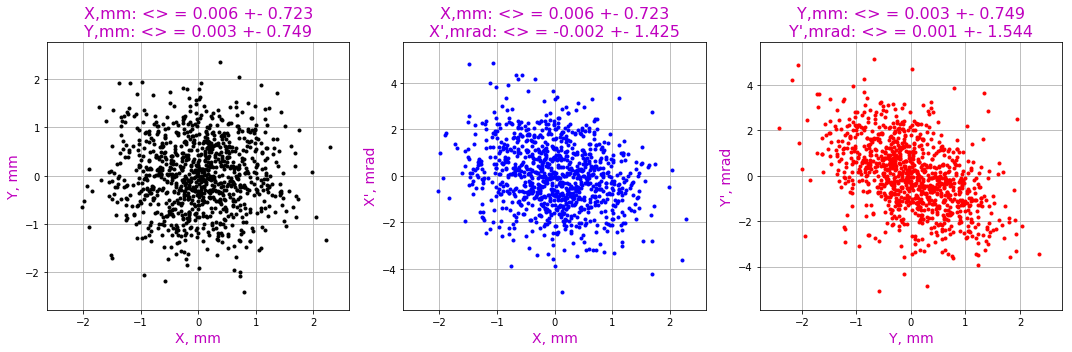

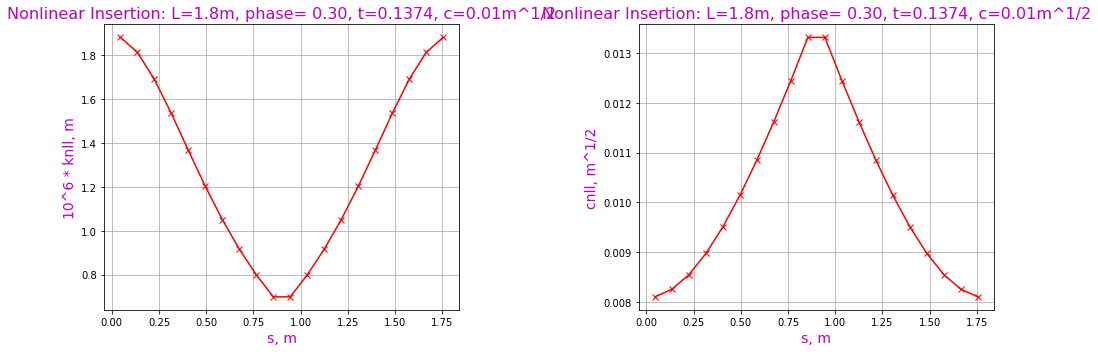


              After 340 turns:

Modified lattice (absolute magnification): Step  17
n.11 :  knll= 1.51914244623e-06  -->  1.88275400314e-06

Update and plotting are completed (CPU time =  1.880 seconds)

Turn 341 is completed (CPU time =  0.000 seconds)
Turn 342 is completed (CPU time =  0.010 seconds)
Turn 343 is completed (CPU time =  0.000 seconds)
Turn 344 is completed (CPU time =  0.000 seconds)
Turn 345 is completed (CPU time =  0.010 seconds)
Turn 346 is completed (CPU time =  0.000 seconds)
Turn 347 is completed (CPU time =  0.000 seconds)
Turn 348 is completed (CPU time =  0.000 seconds)
Turn 349 is completed (CPU time =  0.010 seconds)
Turn 350 is completed (CPU time =  0.000 seconds)
Turn 351 is completed (CPU time =  0.000 seconds)
Turn 352 is completed (CPU time =  0.000 seconds)
Turn 353 is completed (CPU time =  0.010 seconds)
Turn 354 is completed (CPU time =  0.000 seconds)
Turn 355 is completed (CPU time =  0.000 seconds)
Turn 356 is completed (CPU time =  0.000 seco

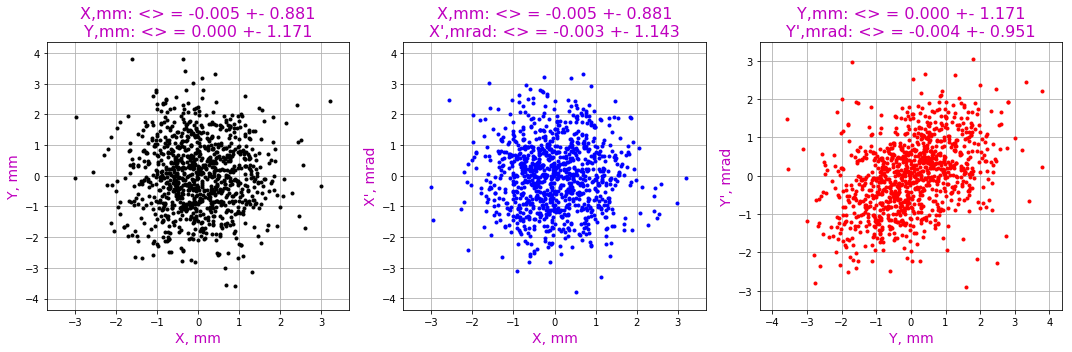


              After 360 turns:

Modified lattice (absolute magnification): Step  18
n.11 :  knll= 1.88275400314e-06  -->  2.31684198504e-06

Update and plotting are completed (CPU time =  1.960 seconds)

Turn 361 is completed (CPU time =  0.010 seconds)
Turn 362 is completed (CPU time =  0.000 seconds)
Turn 363 is completed (CPU time =  0.000 seconds)
Turn 364 is completed (CPU time =  0.010 seconds)
Turn 365 is completed (CPU time =  0.000 seconds)
Turn 366 is completed (CPU time =  0.000 seconds)
Turn 367 is completed (CPU time =  0.000 seconds)
Turn 368 is completed (CPU time =  0.010 seconds)
Turn 369 is completed (CPU time =  0.000 seconds)
Turn 370 is completed (CPU time =  0.000 seconds)
Turn 371 is completed (CPU time =  0.000 seconds)
Turn 372 is completed (CPU time =  0.000 seconds)
Turn 373 is completed (CPU time =  0.000 seconds)
Turn 374 is completed (CPU time =  0.000 seconds)
Turn 375 is completed (CPU time =  0.010 seconds)
Turn 376 is completed (CPU time =  0.000 seco

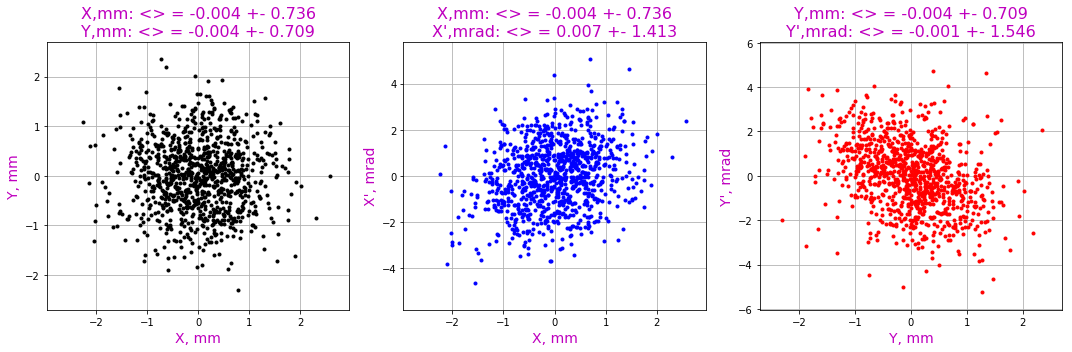

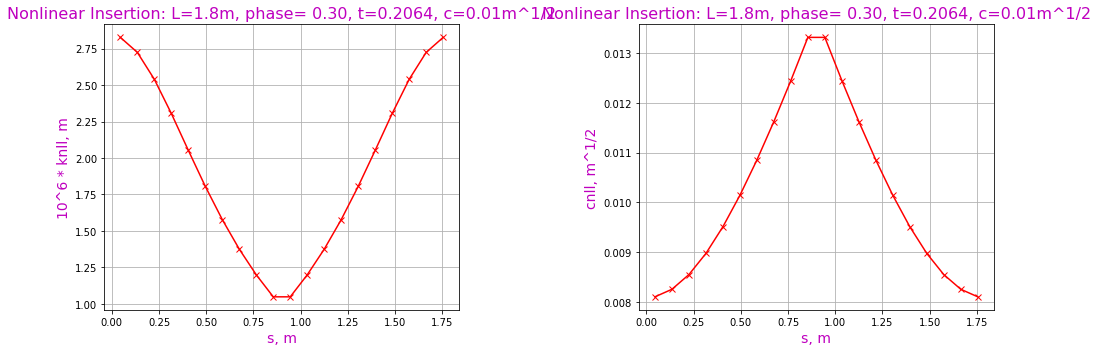


              After 380 turns:

Modified lattice (absolute magnification): Step  19
n.11 :  knll= 2.31684198504e-06  -->  2.82706800963e-06

Update and plotting are completed (CPU time =  1.900 seconds)

Turn 381 is completed (CPU time =  0.000 seconds)
Turn 382 is completed (CPU time =  0.000 seconds)
Turn 383 is completed (CPU time =  0.000 seconds)
Turn 384 is completed (CPU time =  0.000 seconds)
Turn 385 is completed (CPU time =  0.000 seconds)
Turn 386 is completed (CPU time =  0.000 seconds)
Turn 387 is completed (CPU time =  0.000 seconds)
Turn 388 is completed (CPU time =  0.000 seconds)
Turn 389 is completed (CPU time =  0.010 seconds)
Turn 390 is completed (CPU time =  0.000 seconds)
Turn 391 is completed (CPU time =  0.000 seconds)
Turn 392 is completed (CPU time =  0.010 seconds)
Turn 393 is completed (CPU time =  0.000 seconds)
Turn 394 is completed (CPU time =  0.000 seconds)
Turn 395 is completed (CPU time =  0.000 seconds)
Turn 396 is completed (CPU time =  0.000 seco

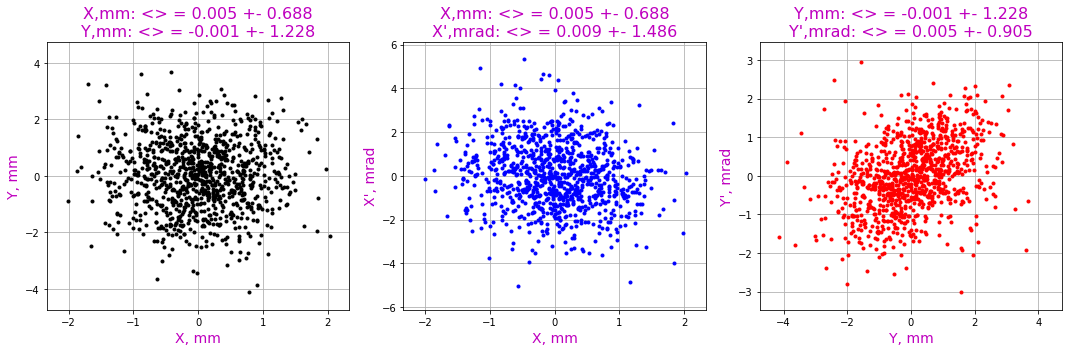

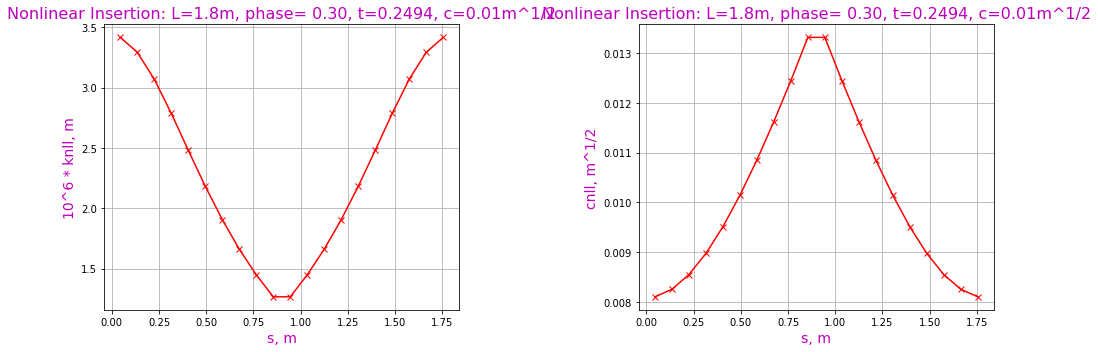


              After 400 turns:

Modified lattice (absolute magnification): Step  20
n.11 :  knll= 2.82706800963e-06  -->  3.41593622459e-06

Update and plotting are completed (CPU time =  1.990 seconds)

Turn 401 is completed (CPU time =  0.010 seconds)
Turn 402 is completed (CPU time =  0.000 seconds)
Turn 403 is completed (CPU time =  0.010 seconds)
Turn 404 is completed (CPU time =  0.000 seconds)
Turn 405 is completed (CPU time =  0.000 seconds)
Turn 406 is completed (CPU time =  0.000 seconds)
Turn 407 is completed (CPU time =  0.010 seconds)
Turn 408 is completed (CPU time =  0.000 seconds)
Turn 409 is completed (CPU time =  0.000 seconds)
Turn 410 is completed (CPU time =  0.000 seconds)
Turn 411 is completed (CPU time =  0.010 seconds)
Turn 412 is completed (CPU time =  0.000 seconds)
Turn 413 is completed (CPU time =  0.000 seconds)
Turn 414 is completed (CPU time =  0.000 seconds)
Turn 415 is completed (CPU time =  0.010 seconds)
Turn 416 is completed (CPU time =  0.000 seco

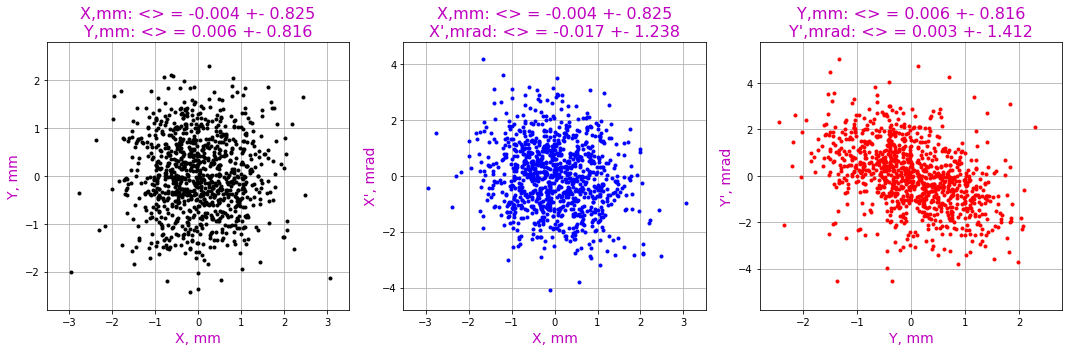

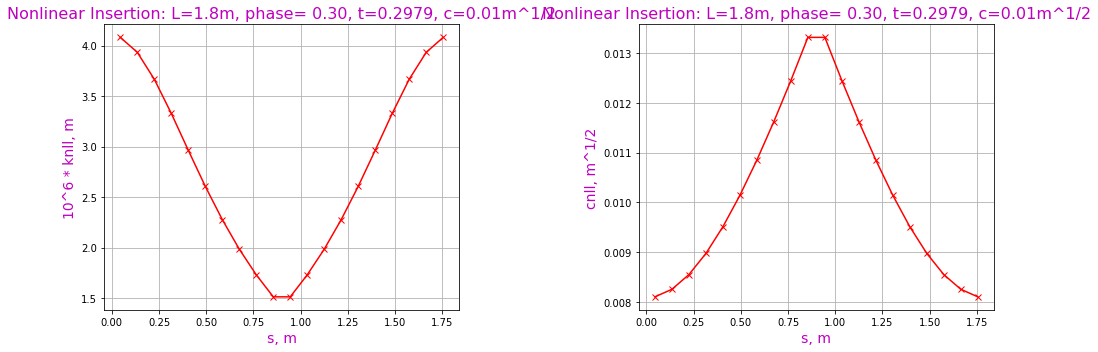


              After 420 turns:

Modified lattice (absolute magnification): Step  21
n.11 :  knll= 3.41593622459e-06  -->  4.0814160476e-06

Update and plotting are completed (CPU time =  1.870 seconds)

Turn 421 is completed (CPU time =  0.010 seconds)
Turn 422 is completed (CPU time =  0.000 seconds)
Turn 423 is completed (CPU time =  0.000 seconds)
Turn 424 is completed (CPU time =  0.010 seconds)
Turn 425 is completed (CPU time =  0.000 seconds)
Turn 426 is completed (CPU time =  0.000 seconds)
Turn 427 is completed (CPU time =  0.000 seconds)
Turn 428 is completed (CPU time =  0.000 seconds)
Turn 429 is completed (CPU time =  0.000 seconds)
Turn 430 is completed (CPU time =  0.000 seconds)
Turn 431 is completed (CPU time =  0.000 seconds)
Turn 432 is completed (CPU time =  0.000 seconds)
Turn 433 is completed (CPU time =  0.010 seconds)
Turn 434 is completed (CPU time =  0.000 seconds)
Turn 435 is completed (CPU time =  0.000 seconds)
Turn 436 is completed (CPU time =  0.000 secon

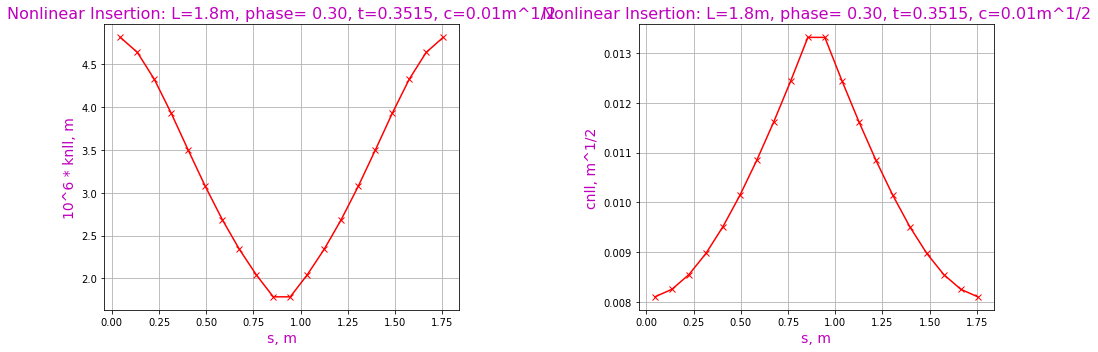


              After 440 turns:

Modified lattice (absolute magnification): Step  22
n.11 :  knll= 4.0814160476e-06  -->  4.81582508175e-06

Update and plotting are completed (CPU time =  1.880 seconds)

Turn 441 is completed (CPU time =  0.000 seconds)
Turn 442 is completed (CPU time =  0.010 seconds)
Turn 443 is completed (CPU time =  0.000 seconds)
Turn 444 is completed (CPU time =  0.000 seconds)
Turn 445 is completed (CPU time =  0.000 seconds)
Turn 446 is completed (CPU time =  0.010 seconds)
Turn 447 is completed (CPU time =  0.000 seconds)
Turn 448 is completed (CPU time =  0.000 seconds)
Turn 449 is completed (CPU time =  0.000 seconds)
Turn 450 is completed (CPU time =  0.010 seconds)
Turn 451 is completed (CPU time =  0.000 seconds)
Turn 452 is completed (CPU time =  0.000 seconds)
Turn 453 is completed (CPU time =  0.000 seconds)
Turn 454 is completed (CPU time =  0.010 seconds)
Turn 455 is completed (CPU time =  0.000 seconds)
Turn 456 is completed (CPU time =  0.000 secon


              After 460 turns:

Modified lattice (absolute magnification): Step  23
n.11 :  knll= 4.81582508175e-06  -->  5.60536312871e-06

Update and plotting are completed (CPU time =  1.950 seconds)

Turn 461 is completed (CPU time =  0.000 seconds)
Turn 462 is completed (CPU time =  0.000 seconds)
Turn 463 is completed (CPU time =  0.010 seconds)
Turn 464 is completed (CPU time =  0.000 seconds)
Turn 465 is completed (CPU time =  0.000 seconds)
Turn 466 is completed (CPU time =  0.010 seconds)
Turn 467 is completed (CPU time =  0.000 seconds)
Turn 468 is completed (CPU time =  0.000 seconds)
Turn 469 is completed (CPU time =  0.000 seconds)
Turn 470 is completed (CPU time =  0.010 seconds)
Turn 471 is completed (CPU time =  0.000 seconds)
Turn 472 is completed (CPU time =  0.000 seconds)
Turn 473 is completed (CPU time =  0.000 seconds)
Turn 474 is completed (CPU time =  0.010 seconds)
Turn 475 is completed (CPU time =  0.000 seconds)
Turn 476 is completed (CPU time =  0.000 seco

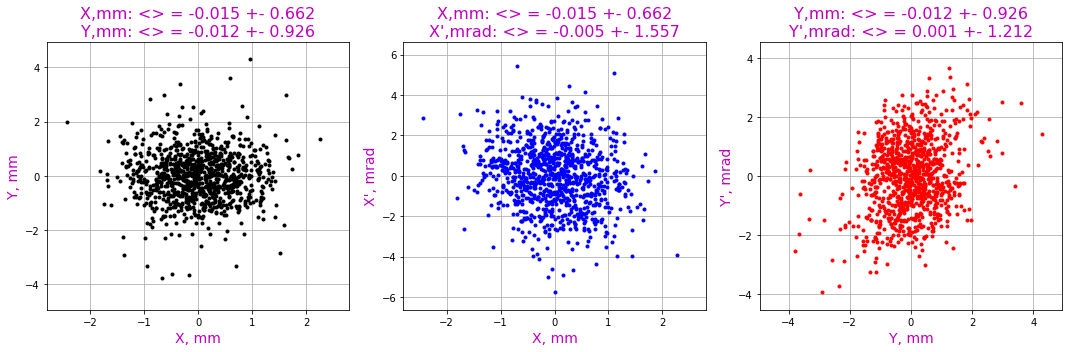

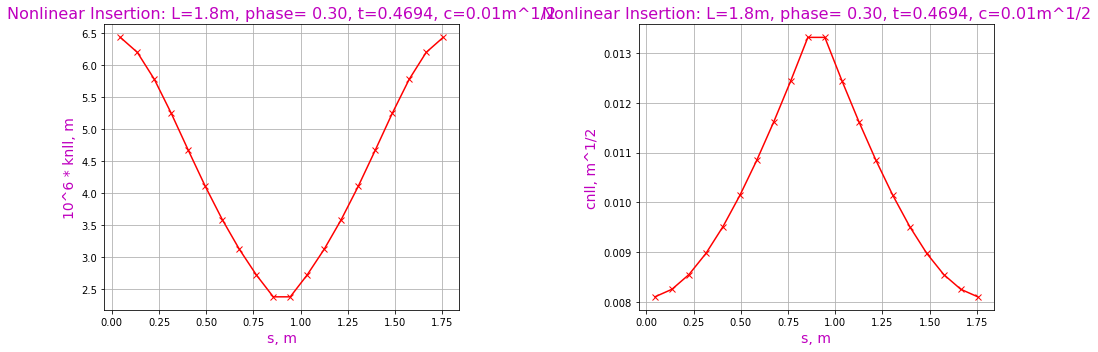


              After 480 turns:

Modified lattice (absolute magnification): Step  24
n.11 :  knll= 5.60536312871e-06  -->  6.430637929e-06

Update and plotting are completed (CPU time =  1.980 seconds)

Turn 481 is completed (CPU time =  0.000 seconds)
Turn 482 is completed (CPU time =  0.000 seconds)
Turn 483 is completed (CPU time =  0.000 seconds)
Turn 484 is completed (CPU time =  0.010 seconds)
Turn 485 is completed (CPU time =  0.000 seconds)
Turn 486 is completed (CPU time =  0.010 seconds)
Turn 487 is completed (CPU time =  0.000 seconds)
Turn 488 is completed (CPU time =  0.000 seconds)
Turn 489 is completed (CPU time =  0.010 seconds)
Turn 490 is completed (CPU time =  0.000 seconds)
Turn 491 is completed (CPU time =  0.000 seconds)
Turn 492 is completed (CPU time =  0.010 seconds)
Turn 493 is completed (CPU time =  0.000 seconds)
Turn 494 is completed (CPU time =  0.000 seconds)
Turn 495 is completed (CPU time =  0.010 seconds)
Turn 496 is completed (CPU time =  0.000 second

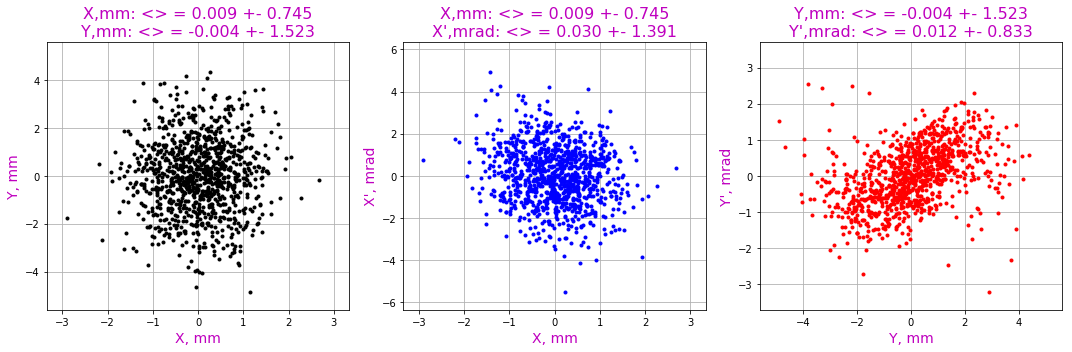

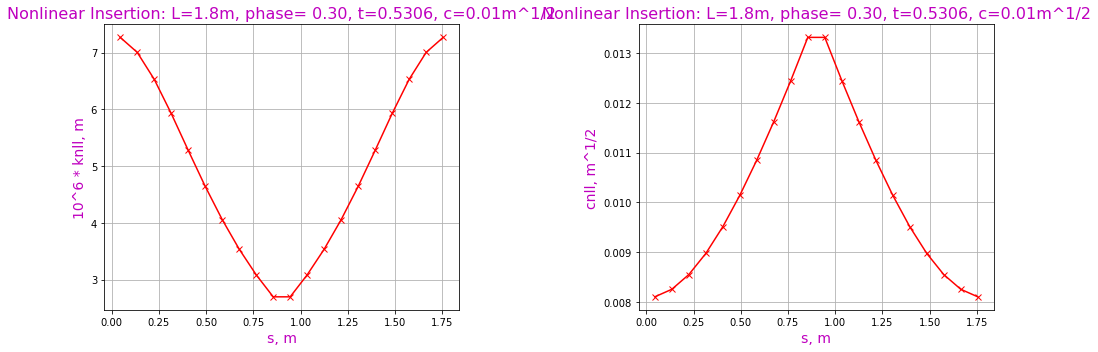


              After 500 turns:

Modified lattice (absolute magnification): Step  25
n.11 :  knll= 6.430637929e-06  -->  7.26830216421e-06

Update and plotting are completed (CPU time =  1.920 seconds)

Turn 501 is completed (CPU time =  0.010 seconds)
Turn 502 is completed (CPU time =  0.000 seconds)
Turn 503 is completed (CPU time =  0.000 seconds)
Turn 504 is completed (CPU time =  0.000 seconds)
Turn 505 is completed (CPU time =  0.000 seconds)
Turn 506 is completed (CPU time =  0.010 seconds)
Turn 507 is completed (CPU time =  0.000 seconds)
Turn 508 is completed (CPU time =  0.000 seconds)
Turn 509 is completed (CPU time =  0.000 seconds)
Turn 510 is completed (CPU time =  0.000 seconds)
Turn 511 is completed (CPU time =  0.000 seconds)
Turn 512 is completed (CPU time =  0.000 seconds)
Turn 513 is completed (CPU time =  0.010 seconds)
Turn 514 is completed (CPU time =  0.000 seconds)
Turn 515 is completed (CPU time =  0.000 seconds)
Turn 516 is completed (CPU time =  0.000 second

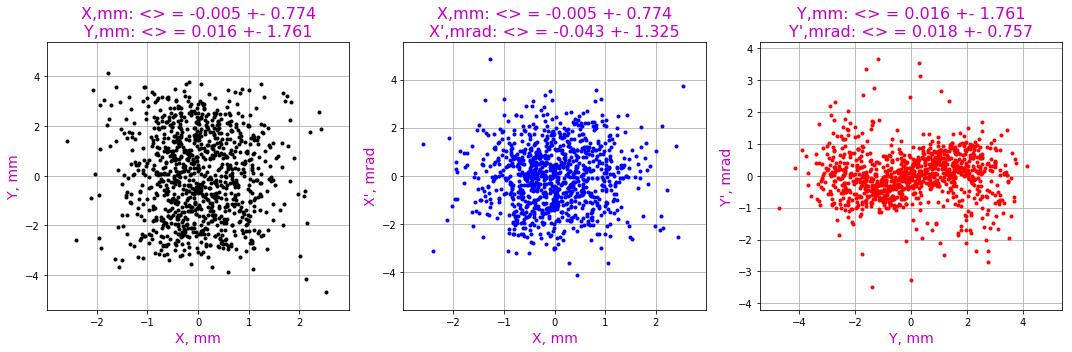

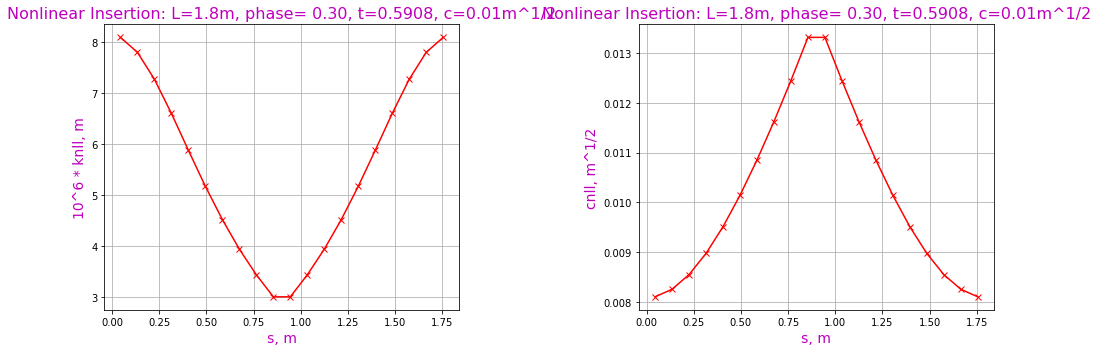


              After 520 turns:

Modified lattice (absolute magnification): Step  26
n.11 :  knll= 7.26830216421e-06  -->  8.0935769645e-06

Update and plotting are completed (CPU time =  1.980 seconds)

Turn 521 is completed (CPU time =  0.000 seconds)
Turn 522 is completed (CPU time =  0.000 seconds)
Turn 523 is completed (CPU time =  0.000 seconds)
Turn 524 is completed (CPU time =  0.010 seconds)
Turn 525 is completed (CPU time =  0.000 seconds)
Turn 526 is completed (CPU time =  0.000 seconds)
Turn 527 is completed (CPU time =  0.000 seconds)
Turn 528 is completed (CPU time =  0.000 seconds)
Turn 529 is completed (CPU time =  0.000 seconds)
Turn 530 is completed (CPU time =  0.000 seconds)
Turn 531 is completed (CPU time =  0.010 seconds)
Turn 532 is completed (CPU time =  0.000 seconds)
Turn 533 is completed (CPU time =  0.000 seconds)
Turn 534 is completed (CPU time =  0.000 seconds)
Turn 535 is completed (CPU time =  0.010 seconds)
Turn 536 is completed (CPU time =  0.000 secon


              After 540 turns:

Modified lattice (absolute magnification): Step  27
n.11 :  knll= 8.0935769645e-06  -->  8.88311501146e-06

Update and plotting are completed (CPU time =  1.920 seconds)

Turn 541 is completed (CPU time =  0.010 seconds)
Turn 542 is completed (CPU time =  0.000 seconds)
Turn 543 is completed (CPU time =  0.000 seconds)
Turn 544 is completed (CPU time =  0.000 seconds)
Turn 545 is completed (CPU time =  0.000 seconds)
Turn 546 is completed (CPU time =  0.000 seconds)
Turn 547 is completed (CPU time =  0.010 seconds)
Turn 548 is completed (CPU time =  0.000 seconds)
Turn 549 is completed (CPU time =  0.000 seconds)
Turn 550 is completed (CPU time =  0.000 seconds)
Turn 551 is completed (CPU time =  0.010 seconds)
Turn 552 is completed (CPU time =  0.000 seconds)
Turn 553 is completed (CPU time =  0.000 seconds)
Turn 554 is completed (CPU time =  0.000 seconds)
Turn 555 is completed (CPU time =  0.000 seconds)
Turn 556 is completed (CPU time =  0.000 secon

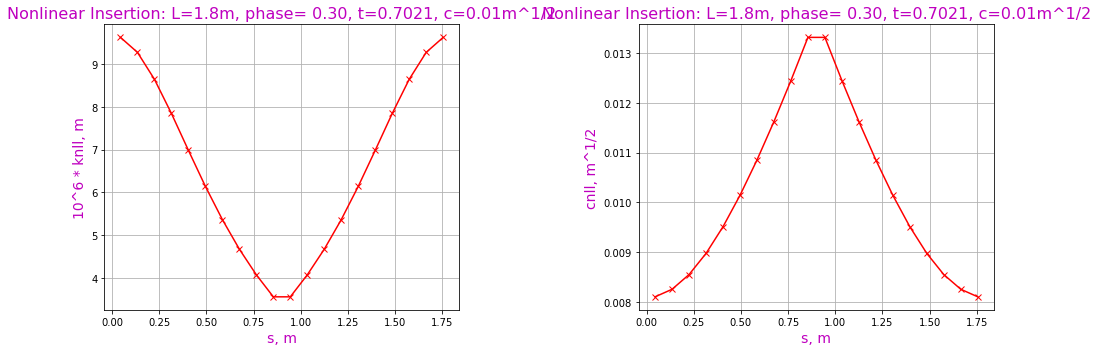


              After 560 turns:

Modified lattice (absolute magnification): Step  28
n.11 :  knll= 8.88311501146e-06  -->  9.61752404561e-06

Update and plotting are completed (CPU time =  2.060 seconds)

Turn 561 is completed (CPU time =  0.000 seconds)
Turn 562 is completed (CPU time =  0.010 seconds)
Turn 563 is completed (CPU time =  0.000 seconds)
Turn 564 is completed (CPU time =  0.000 seconds)
Turn 565 is completed (CPU time =  0.010 seconds)
Turn 566 is completed (CPU time =  0.000 seconds)
Turn 567 is completed (CPU time =  0.000 seconds)
Turn 568 is completed (CPU time =  0.000 seconds)
Turn 569 is completed (CPU time =  0.000 seconds)
Turn 570 is completed (CPU time =  0.000 seconds)
Turn 571 is completed (CPU time =  0.000 seconds)
Turn 572 is completed (CPU time =  0.000 seconds)
Turn 573 is completed (CPU time =  0.010 seconds)
Turn 574 is completed (CPU time =  0.000 seconds)
Turn 575 is completed (CPU time =  0.000 seconds)
Turn 576 is completed (CPU time =  0.000 seco

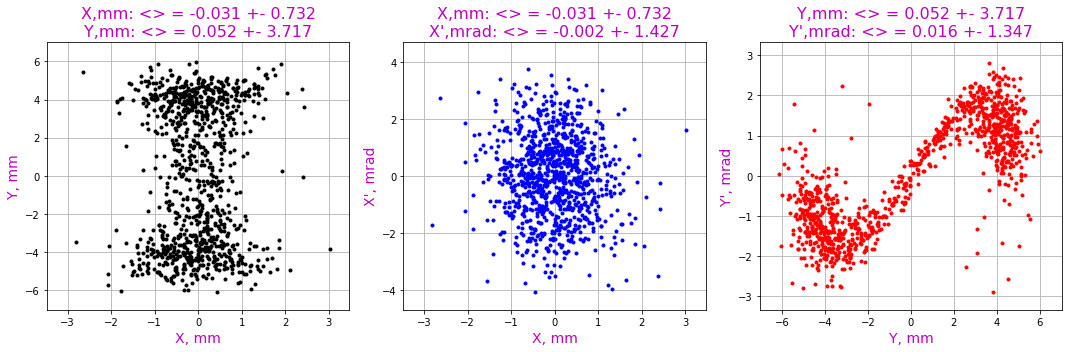


              After 580 turns:

Modified lattice (absolute magnification): Step  29
n.11 :  knll= 9.61752404561e-06  -->  1.02830038686e-05

Update and plotting are completed (CPU time =  1.930 seconds)

Turn 581 is completed (CPU time =  0.010 seconds)
Turn 582 is completed (CPU time =  0.000 seconds)
Turn 583 is completed (CPU time =  0.000 seconds)
Turn 584 is completed (CPU time =  0.000 seconds)
Turn 585 is completed (CPU time =  0.000 seconds)
Turn 586 is completed (CPU time =  0.000 seconds)
Turn 587 is completed (CPU time =  0.000 seconds)
Turn 588 is completed (CPU time =  0.010 seconds)
Turn 589 is completed (CPU time =  0.000 seconds)
Turn 590 is completed (CPU time =  0.000 seconds)
Turn 591 is completed (CPU time =  0.000 seconds)
Turn 592 is completed (CPU time =  0.010 seconds)
Turn 593 is completed (CPU time =  0.000 seconds)
Turn 594 is completed (CPU time =  0.000 seconds)
Turn 595 is completed (CPU time =  0.000 seconds)
Turn 596 is completed (CPU time =  0.000 seco

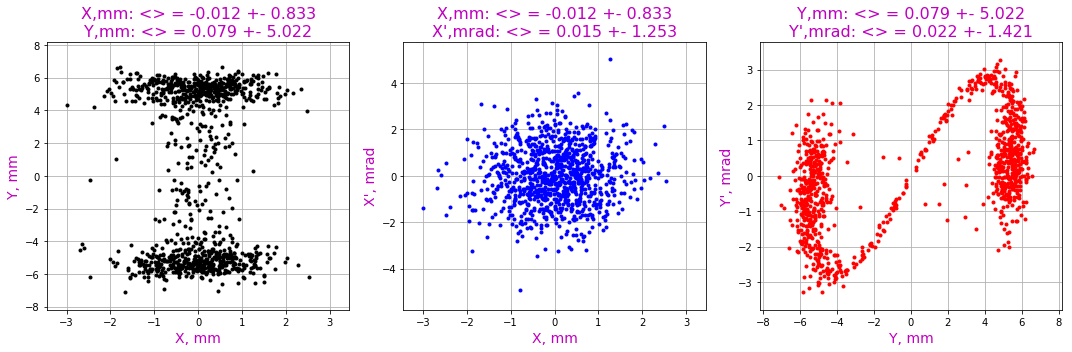


              After 600 turns:

Modified lattice (absolute magnification): Step  30
n.11 :  knll= 1.02830038686e-05  -->  1.08718720836e-05

Update and plotting are completed (CPU time =  1.980 seconds)

Turn 601 is completed (CPU time =  0.000 seconds)
Turn 602 is completed (CPU time =  0.000 seconds)
Turn 603 is completed (CPU time =  0.000 seconds)
Turn 604 is completed (CPU time =  0.000 seconds)
Turn 605 is completed (CPU time =  0.000 seconds)
Turn 606 is completed (CPU time =  0.000 seconds)
Turn 607 is completed (CPU time =  0.000 seconds)
Turn 608 is completed (CPU time =  0.000 seconds)
Turn 609 is completed (CPU time =  0.010 seconds)
Turn 610 is completed (CPU time =  0.000 seconds)
Turn 611 is completed (CPU time =  0.000 seconds)
Turn 612 is completed (CPU time =  0.000 seconds)
Turn 613 is completed (CPU time =  0.010 seconds)
Turn 614 is completed (CPU time =  0.000 seconds)
Turn 615 is completed (CPU time =  0.000 seconds)
Turn 616 is completed (CPU time =  0.010 seco

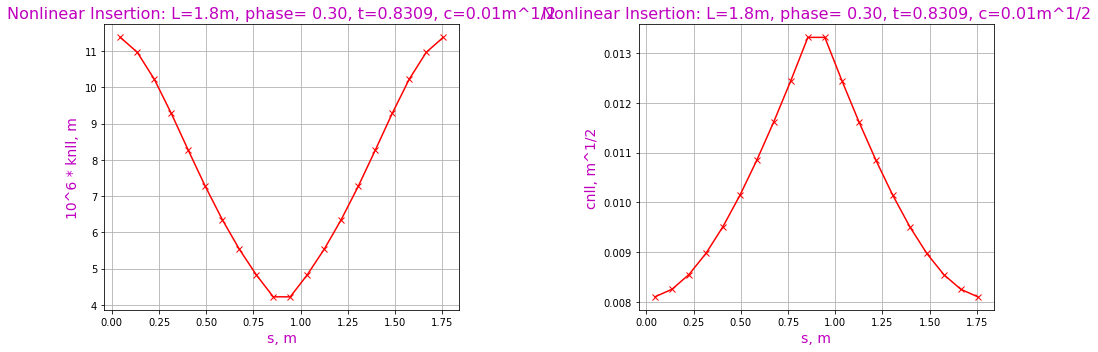


              After 620 turns:

Modified lattice (absolute magnification): Step  31
n.11 :  knll= 1.08718720836e-05  -->  1.13820981082e-05

Update and plotting are completed (CPU time =  1.980 seconds)

Turn 621 is completed (CPU time =  0.000 seconds)
Turn 622 is completed (CPU time =  0.000 seconds)
Turn 623 is completed (CPU time =  0.000 seconds)
Turn 624 is completed (CPU time =  0.010 seconds)
Turn 625 is completed (CPU time =  0.000 seconds)
Turn 626 is completed (CPU time =  0.000 seconds)
Turn 627 is completed (CPU time =  0.000 seconds)
Turn 628 is completed (CPU time =  0.000 seconds)
Turn 629 is completed (CPU time =  0.000 seconds)
Turn 630 is completed (CPU time =  0.000 seconds)
Turn 631 is completed (CPU time =  0.010 seconds)
Turn 632 is completed (CPU time =  0.000 seconds)
Turn 633 is completed (CPU time =  0.000 seconds)
Turn 634 is completed (CPU time =  0.000 seconds)
Turn 635 is completed (CPU time =  0.000 seconds)
Turn 636 is completed (CPU time =  0.000 seco

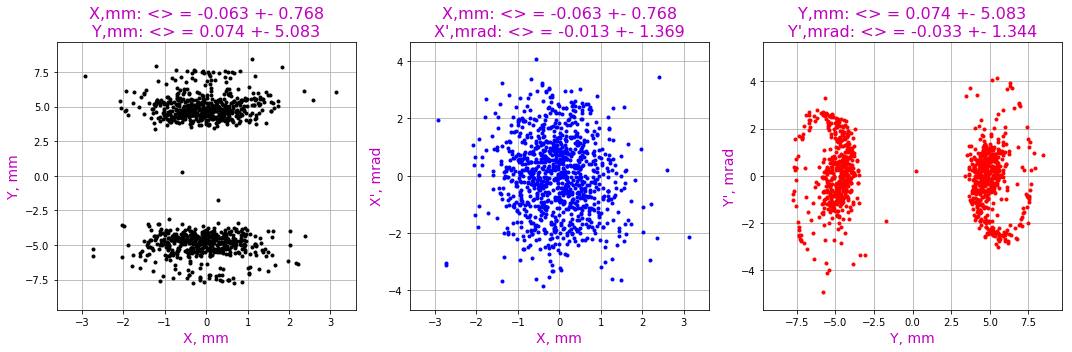


              After 640 turns:

Modified lattice (absolute magnification): Step  32
n.11 :  knll= 1.13820981082e-05  -->  1.18161860901e-05

Update and plotting are completed (CPU time =  1.990 seconds)

Turn 641 is completed (CPU time =  0.010 seconds)
Turn 642 is completed (CPU time =  0.000 seconds)
Turn 643 is completed (CPU time =  0.000 seconds)
Turn 644 is completed (CPU time =  0.010 seconds)
Turn 645 is completed (CPU time =  0.000 seconds)
Turn 646 is completed (CPU time =  0.000 seconds)
Turn 647 is completed (CPU time =  0.000 seconds)
Turn 648 is completed (CPU time =  0.010 seconds)
Turn 649 is completed (CPU time =  0.000 seconds)
Turn 650 is completed (CPU time =  0.000 seconds)
Turn 651 is completed (CPU time =  0.000 seconds)
Turn 652 is completed (CPU time =  0.000 seconds)
Turn 653 is completed (CPU time =  0.000 seconds)
Turn 654 is completed (CPU time =  0.000 seconds)
Turn 655 is completed (CPU time =  0.000 seconds)
Turn 656 is completed (CPU time =  0.000 seco

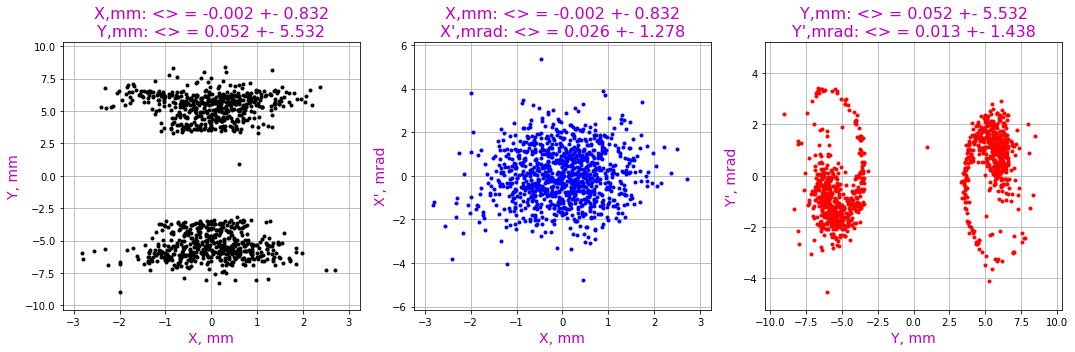

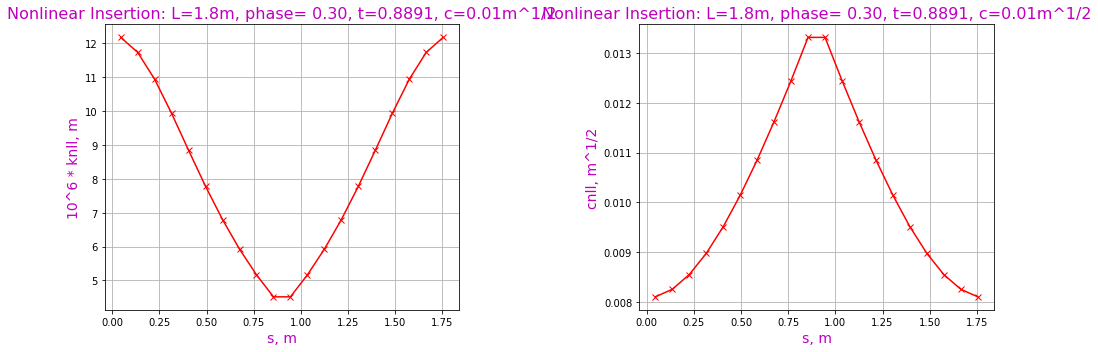


              After 660 turns:

Modified lattice (absolute magnification): Step  33
n.11 :  knll= 1.18161860901e-05  -->  1.2179797647e-05

Update and plotting are completed (CPU time =  1.950 seconds)

Turn 661 is completed (CPU time =  0.000 seconds)
Turn 662 is completed (CPU time =  0.010 seconds)
Turn 663 is completed (CPU time =  0.000 seconds)
Turn 664 is completed (CPU time =  0.000 seconds)
Turn 665 is completed (CPU time =  0.000 seconds)
Turn 666 is completed (CPU time =  0.000 seconds)
Turn 667 is completed (CPU time =  0.000 seconds)
Turn 668 is completed (CPU time =  0.000 seconds)
Turn 669 is completed (CPU time =  0.010 seconds)
Turn 670 is completed (CPU time =  0.000 seconds)
Turn 671 is completed (CPU time =  0.000 seconds)
Turn 672 is completed (CPU time =  0.000 seconds)
Turn 673 is completed (CPU time =  0.010 seconds)
Turn 674 is completed (CPU time =  0.000 seconds)
Turn 675 is completed (CPU time =  0.000 seconds)
Turn 676 is completed (CPU time =  0.010 secon

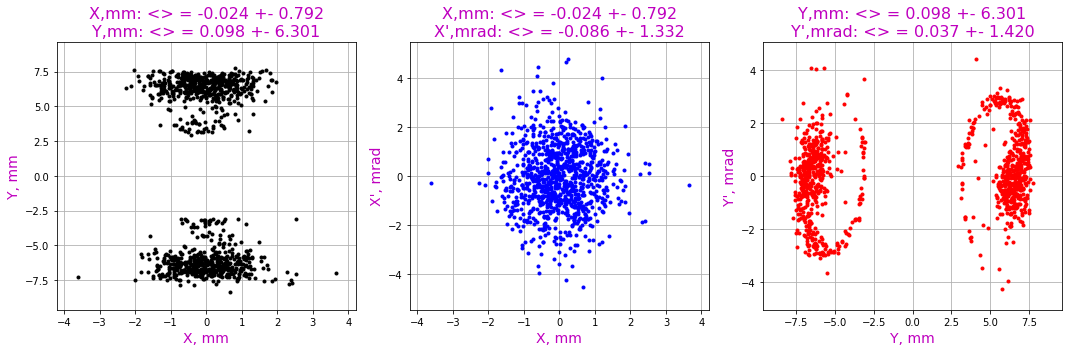

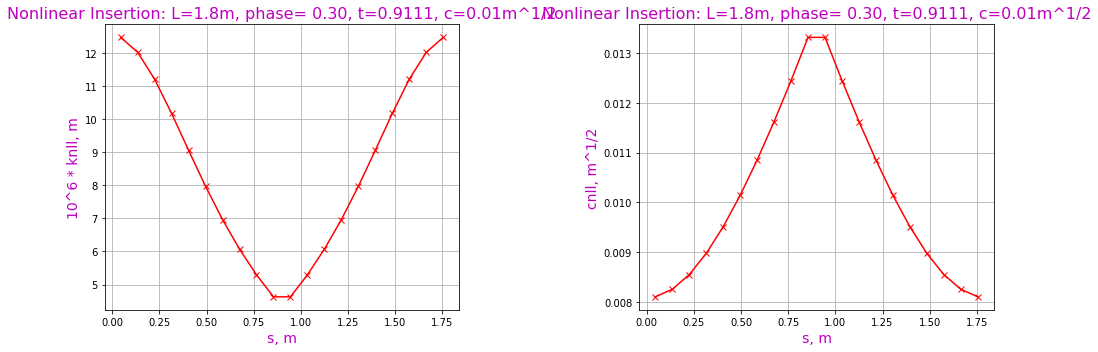


              After 680 turns:

Modified lattice (absolute magnification): Step  34
n.11 :  knll= 1.2179797647e-05  -->  1.24804274158e-05

Update and plotting are completed (CPU time =  1.940 seconds)

Turn 681 is completed (CPU time =  0.010 seconds)
Turn 682 is completed (CPU time =  0.000 seconds)
Turn 683 is completed (CPU time =  0.000 seconds)
Turn 684 is completed (CPU time =  0.000 seconds)
Turn 685 is completed (CPU time =  0.010 seconds)
Turn 686 is completed (CPU time =  0.000 seconds)
Turn 687 is completed (CPU time =  0.000 seconds)
Turn 688 is completed (CPU time =  0.000 seconds)
Turn 689 is completed (CPU time =  0.000 seconds)
Turn 690 is completed (CPU time =  0.000 seconds)
Turn 691 is completed (CPU time =  0.000 seconds)
Turn 692 is completed (CPU time =  0.010 seconds)
Turn 693 is completed (CPU time =  0.000 seconds)
Turn 694 is completed (CPU time =  0.000 seconds)
Turn 695 is completed (CPU time =  0.000 seconds)
Turn 696 is completed (CPU time =  0.010 secon

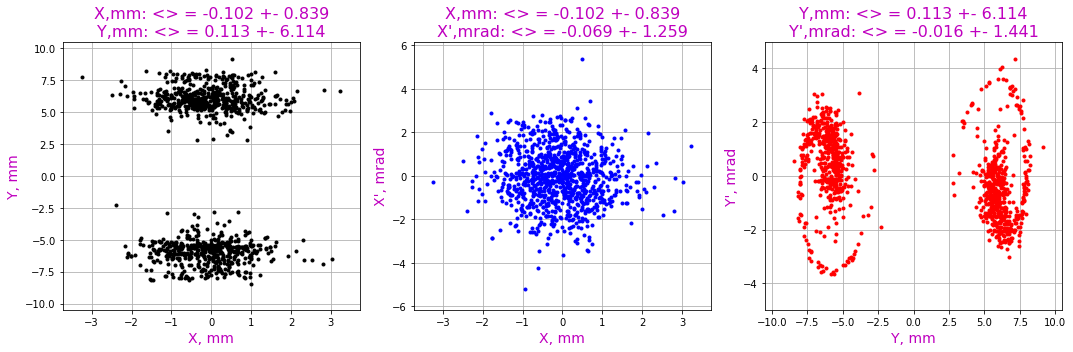


              After 700 turns:

Modified lattice (absolute magnification): Step  35
n.11 :  knll= 1.24804274158e-05  -->  1.27263150842e-05

Update and plotting are completed (CPU time =  1.930 seconds)

Turn 701 is completed (CPU time =  0.000 seconds)
Turn 702 is completed (CPU time =  0.000 seconds)
Turn 703 is completed (CPU time =  0.010 seconds)
Turn 704 is completed (CPU time =  0.000 seconds)
Turn 705 is completed (CPU time =  0.000 seconds)
Turn 706 is completed (CPU time =  0.000 seconds)
Turn 707 is completed (CPU time =  0.010 seconds)
Turn 708 is completed (CPU time =  0.000 seconds)
Turn 709 is completed (CPU time =  0.000 seconds)
Turn 710 is completed (CPU time =  0.000 seconds)
Turn 711 is completed (CPU time =  0.000 seconds)
Turn 712 is completed (CPU time =  0.000 seconds)
Turn 713 is completed (CPU time =  0.000 seconds)
Turn 714 is completed (CPU time =  0.010 seconds)
Turn 715 is completed (CPU time =  0.000 seconds)
Turn 716 is completed (CPU time =  0.000 seco

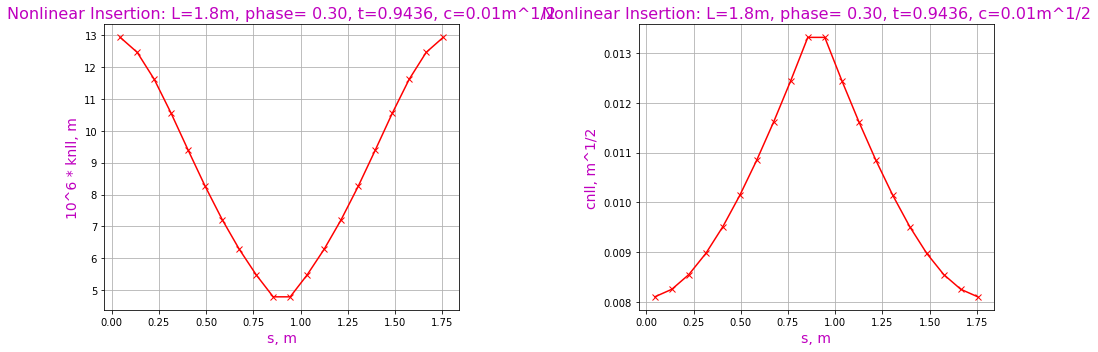


              After 720 turns:

Modified lattice (absolute magnification): Step  36
n.11 :  knll= 1.27263150842e-05  -->  1.29256586118e-05

Update and plotting are completed (CPU time =  2.090 seconds)

Turn 721 is completed (CPU time =  0.000 seconds)
Turn 722 is completed (CPU time =  0.010 seconds)
Turn 723 is completed (CPU time =  0.000 seconds)
Turn 724 is completed (CPU time =  0.010 seconds)
Turn 725 is completed (CPU time =  0.000 seconds)
Turn 726 is completed (CPU time =  0.000 seconds)
Turn 727 is completed (CPU time =  0.010 seconds)
Turn 728 is completed (CPU time =  0.000 seconds)
Turn 729 is completed (CPU time =  0.000 seconds)
Turn 730 is completed (CPU time =  0.010 seconds)
Turn 731 is completed (CPU time =  0.000 seconds)
Turn 732 is completed (CPU time =  0.010 seconds)
Turn 733 is completed (CPU time =  0.000 seconds)
Turn 734 is completed (CPU time =  0.000 seconds)
Turn 735 is completed (CPU time =  0.000 seconds)
Turn 736 is completed (CPU time =  0.000 seco

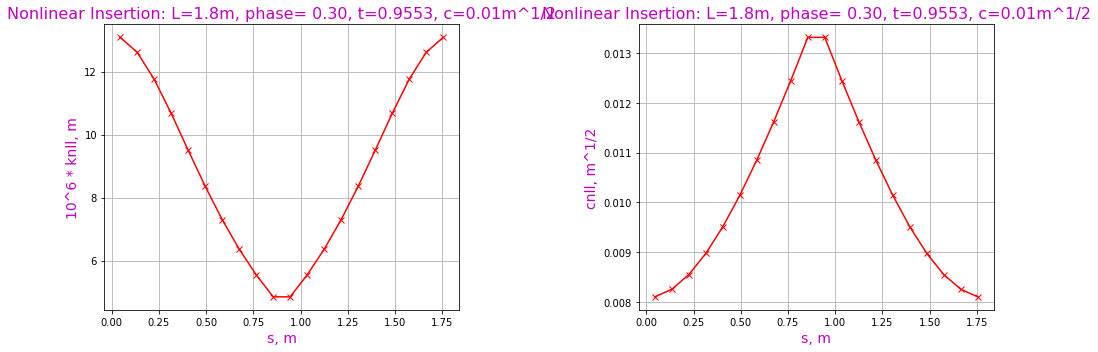


              After 740 turns:

Modified lattice (absolute magnification): Step  37
n.11 :  knll= 1.29256586118e-05  -->  1.30861132627e-05

Update and plotting are completed (CPU time =  1.880 seconds)

Turn 741 is completed (CPU time =  0.000 seconds)
Turn 742 is completed (CPU time =  0.000 seconds)
Turn 743 is completed (CPU time =  0.000 seconds)
Turn 744 is completed (CPU time =  0.010 seconds)
Turn 745 is completed (CPU time =  0.000 seconds)
Turn 746 is completed (CPU time =  0.000 seconds)
Turn 747 is completed (CPU time =  0.010 seconds)
Turn 748 is completed (CPU time =  0.000 seconds)
Turn 749 is completed (CPU time =  0.000 seconds)
Turn 750 is completed (CPU time =  0.010 seconds)
Turn 751 is completed (CPU time =  0.000 seconds)
Turn 752 is completed (CPU time =  0.000 seconds)
Turn 753 is completed (CPU time =  0.010 seconds)
Turn 754 is completed (CPU time =  0.000 seconds)
Turn 755 is completed (CPU time =  0.000 seconds)
Turn 756 is completed (CPU time =  0.000 seco

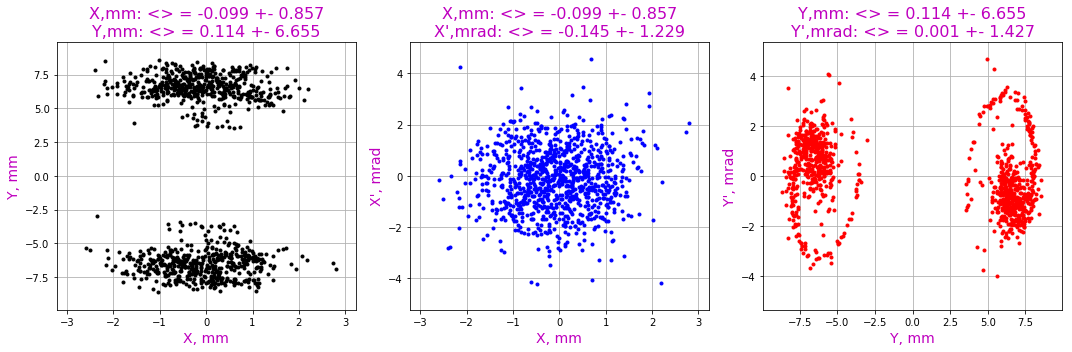

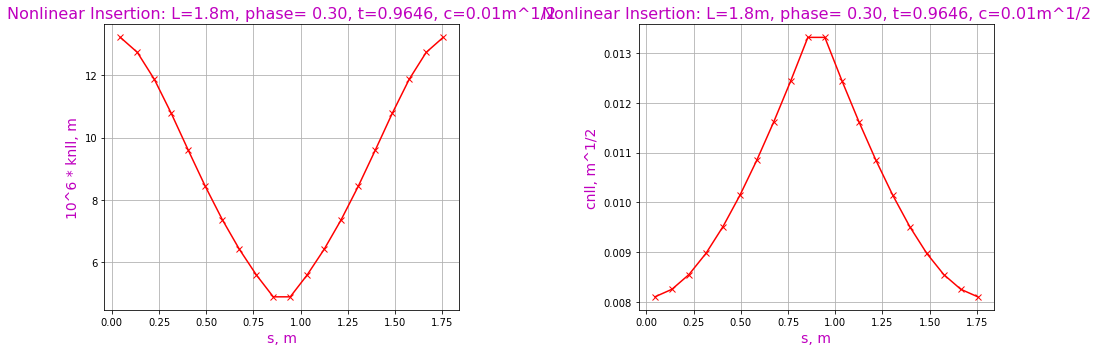


              After 760 turns:

Modified lattice (absolute magnification): Step  38
n.11 :  knll= 1.30861132627e-05  -->  1.32145216058e-05

Update and plotting are completed (CPU time =  1.940 seconds)

Turn 761 is completed (CPU time =  0.000 seconds)
Turn 762 is completed (CPU time =  0.000 seconds)
Turn 763 is completed (CPU time =  0.000 seconds)
Turn 764 is completed (CPU time =  0.010 seconds)
Turn 765 is completed (CPU time =  0.000 seconds)
Turn 766 is completed (CPU time =  0.000 seconds)
Turn 767 is completed (CPU time =  0.000 seconds)
Turn 768 is completed (CPU time =  0.010 seconds)
Turn 769 is completed (CPU time =  0.000 seconds)
Turn 770 is completed (CPU time =  0.000 seconds)
Turn 771 is completed (CPU time =  0.000 seconds)
Turn 772 is completed (CPU time =  0.000 seconds)
Turn 773 is completed (CPU time =  0.000 seconds)
Turn 774 is completed (CPU time =  0.000 seconds)
Turn 775 is completed (CPU time =  0.010 seconds)
Turn 776 is completed (CPU time =  0.000 seco

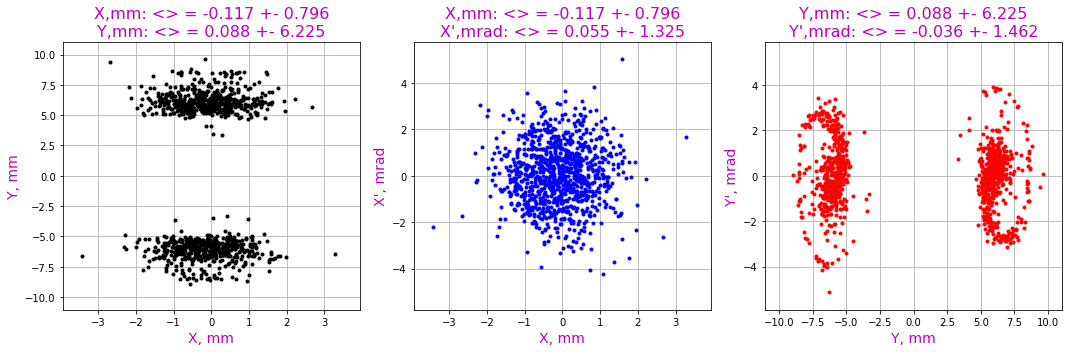

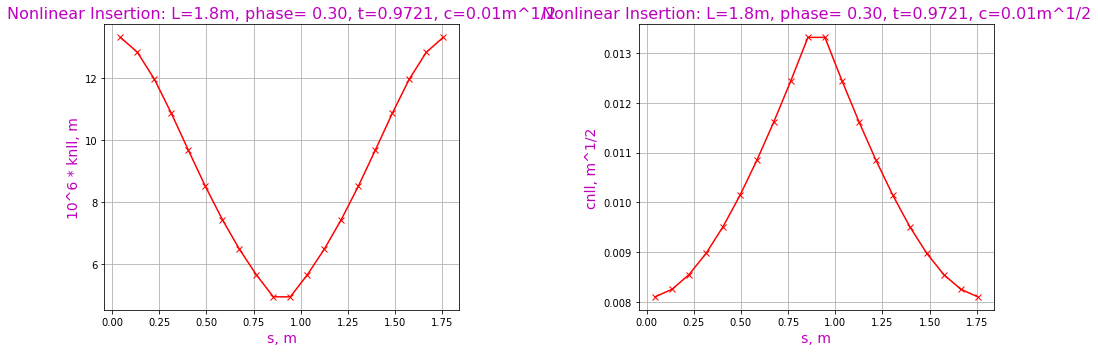


              After 780 turns:

Modified lattice (absolute magnification): Step  39
n.11 :  knll= 1.32145216058e-05  -->  1.33168096623e-05

Update and plotting are completed (CPU time =  2.020 seconds)

Turn 781 is completed (CPU time =  0.000 seconds)
Turn 782 is completed (CPU time =  0.000 seconds)
Turn 783 is completed (CPU time =  0.000 seconds)
Turn 784 is completed (CPU time =  0.000 seconds)
Turn 785 is completed (CPU time =  0.000 seconds)
Turn 786 is completed (CPU time =  0.010 seconds)
Turn 787 is completed (CPU time =  0.000 seconds)
Turn 788 is completed (CPU time =  0.000 seconds)
Turn 789 is completed (CPU time =  0.010 seconds)
Turn 790 is completed (CPU time =  0.000 seconds)
Turn 791 is completed (CPU time =  0.000 seconds)
Turn 792 is completed (CPU time =  0.000 seconds)
Turn 793 is completed (CPU time =  0.010 seconds)
Turn 794 is completed (CPU time =  0.000 seconds)
Turn 795 is completed (CPU time =  0.000 seconds)
Turn 796 is completed (CPU time =  0.000 seco

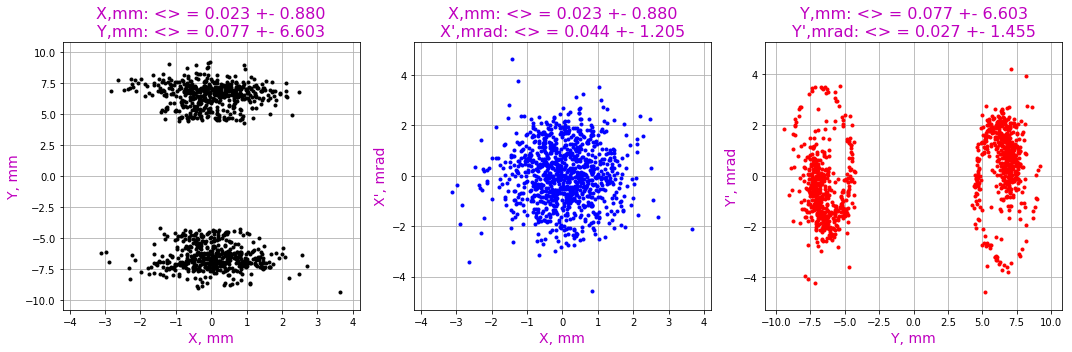

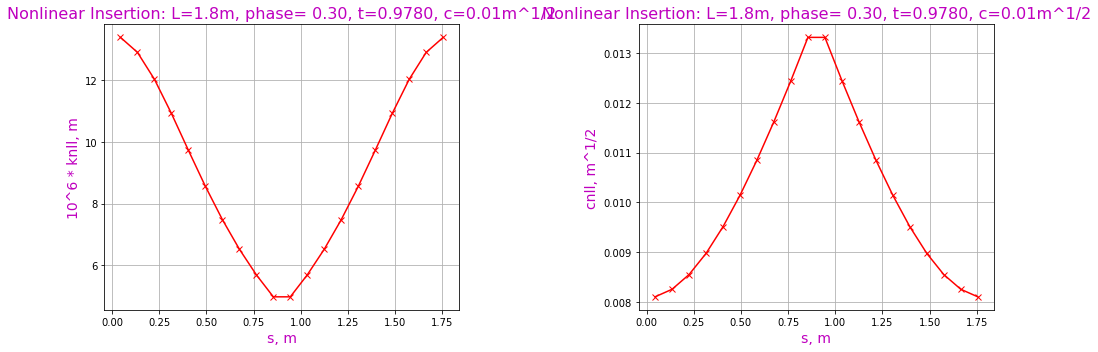


              After 800 turns:

Modified lattice (absolute magnification): Step  40
n.11 :  knll= 1.33168096623e-05  -->  1.3397990836e-05

Update and plotting are completed (CPU time =  1.970 seconds)

Turn 801 is completed (CPU time =  0.010 seconds)
Turn 802 is completed (CPU time =  0.000 seconds)
Turn 803 is completed (CPU time =  0.000 seconds)
Turn 804 is completed (CPU time =  0.000 seconds)
Turn 805 is completed (CPU time =  0.000 seconds)
Turn 806 is completed (CPU time =  0.000 seconds)
Turn 807 is completed (CPU time =  0.010 seconds)
Turn 808 is completed (CPU time =  0.000 seconds)
Turn 809 is completed (CPU time =  0.000 seconds)
Turn 810 is completed (CPU time =  0.000 seconds)
Turn 811 is completed (CPU time =  0.000 seconds)
Turn 812 is completed (CPU time =  0.000 seconds)
Turn 813 is completed (CPU time =  0.000 seconds)
Turn 814 is completed (CPU time =  0.000 seconds)
Turn 815 is completed (CPU time =  0.000 seconds)
Turn 816 is completed (CPU time =  0.000 secon

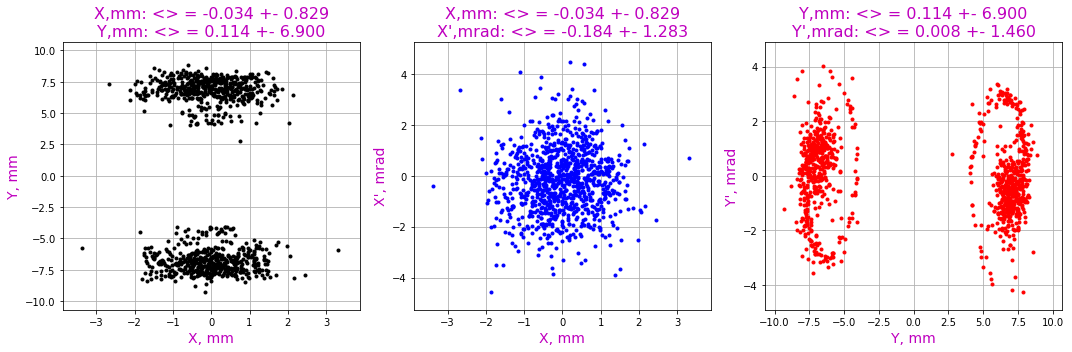

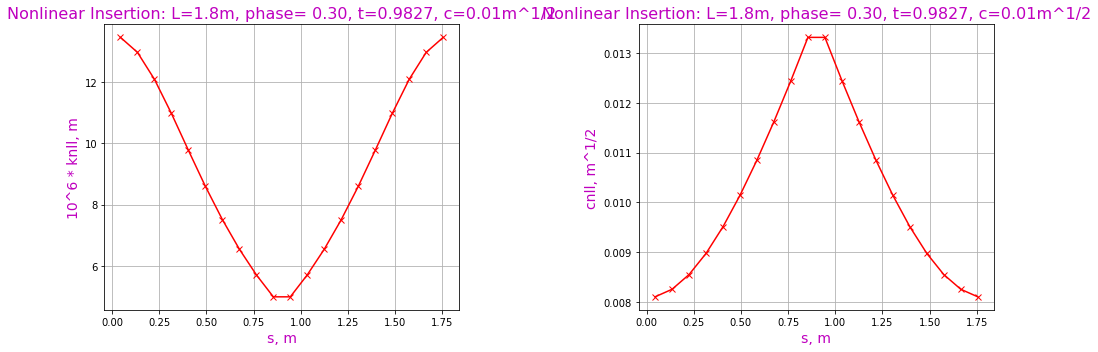


              After 820 turns:

Modified lattice (absolute magnification): Step  41
n.11 :  knll= 1.3397990836e-05  -->  1.34622321443e-05

Update and plotting are completed (CPU time =  1.870 seconds)

Turn 821 is completed (CPU time =  0.000 seconds)
Turn 822 is completed (CPU time =  0.010 seconds)
Turn 823 is completed (CPU time =  0.000 seconds)
Turn 824 is completed (CPU time =  0.000 seconds)
Turn 825 is completed (CPU time =  0.010 seconds)
Turn 826 is completed (CPU time =  0.000 seconds)
Turn 827 is completed (CPU time =  0.000 seconds)
Turn 828 is completed (CPU time =  0.000 seconds)
Turn 829 is completed (CPU time =  0.000 seconds)
Turn 830 is completed (CPU time =  0.000 seconds)
Turn 831 is completed (CPU time =  0.010 seconds)
Turn 832 is completed (CPU time =  0.000 seconds)
Turn 833 is completed (CPU time =  0.000 seconds)
Turn 834 is completed (CPU time =  0.010 seconds)
Turn 835 is completed (CPU time =  0.000 seconds)
Turn 836 is completed (CPU time =  0.000 secon

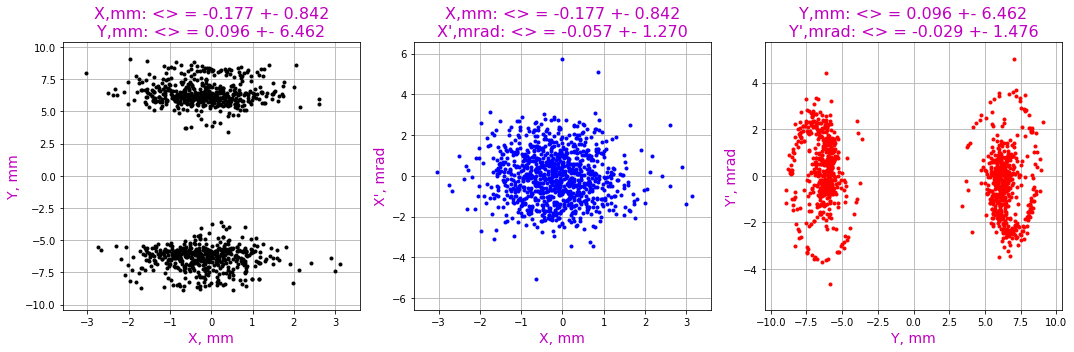

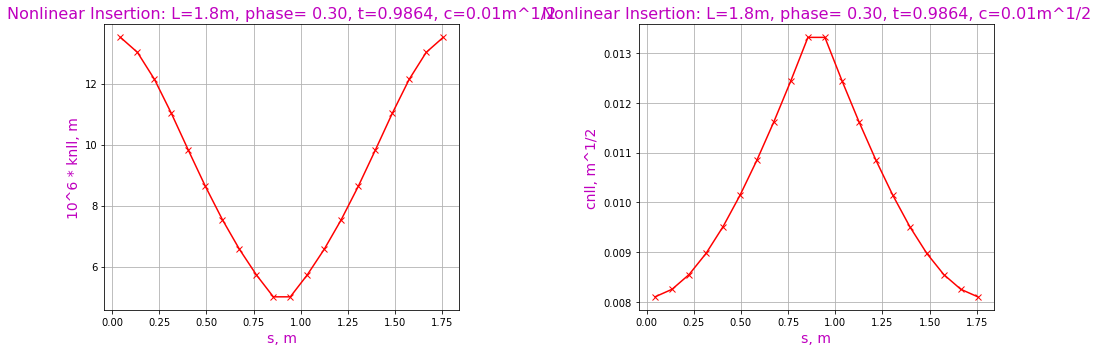


              After 840 turns:

Modified lattice (absolute magnification): Step  42
n.11 :  knll= 1.34622321443e-05  -->  1.35129507213e-05

Update and plotting are completed (CPU time =  1.950 seconds)

Turn 841 is completed (CPU time =  0.000 seconds)
Turn 842 is completed (CPU time =  0.000 seconds)
Turn 843 is completed (CPU time =  0.000 seconds)
Turn 844 is completed (CPU time =  0.000 seconds)
Turn 845 is completed (CPU time =  0.010 seconds)
Turn 846 is completed (CPU time =  0.000 seconds)
Turn 847 is completed (CPU time =  0.000 seconds)
Turn 848 is completed (CPU time =  0.000 seconds)
Turn 849 is completed (CPU time =  0.000 seconds)
Turn 850 is completed (CPU time =  0.000 seconds)
Turn 851 is completed (CPU time =  0.000 seconds)
Turn 852 is completed (CPU time =  0.010 seconds)
Turn 853 is completed (CPU time =  0.000 seconds)
Turn 854 is completed (CPU time =  0.000 seconds)
Turn 855 is completed (CPU time =  0.000 seconds)
Turn 856 is completed (CPU time =  0.010 seco

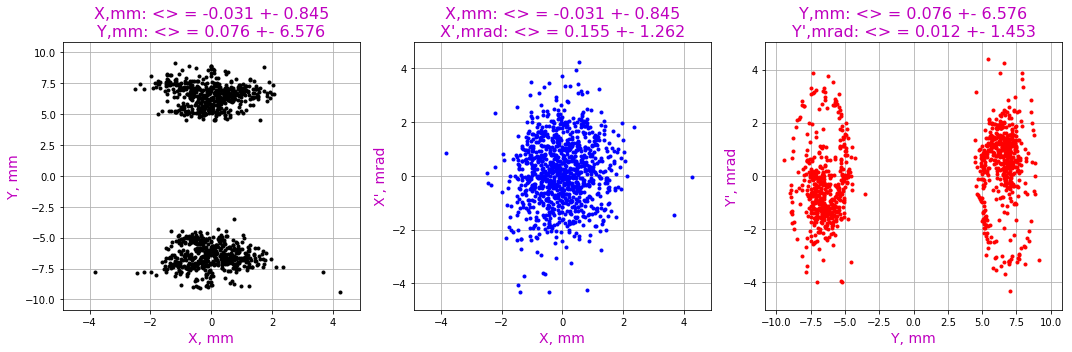

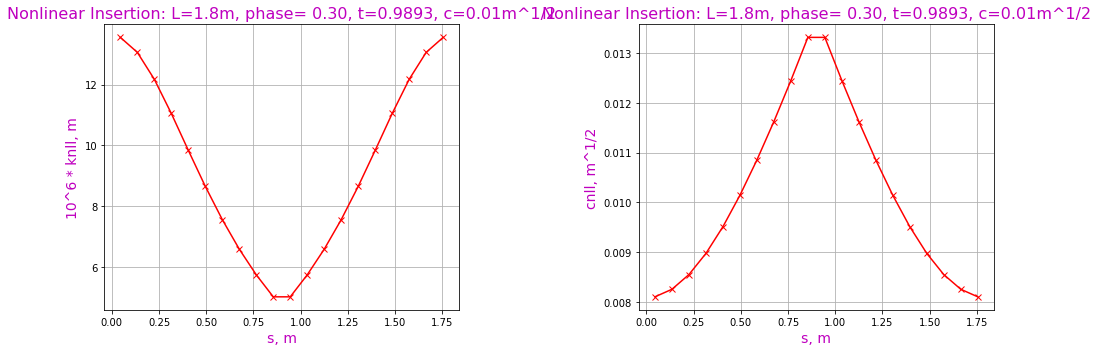


              After 860 turns:

Modified lattice (absolute magnification): Step  43
n.11 :  knll= 1.35129507213e-05  -->  1.35529198816e-05

Update and plotting are completed (CPU time =  2.100 seconds)

Turn 861 is completed (CPU time =  0.000 seconds)
Turn 862 is completed (CPU time =  0.000 seconds)
Turn 863 is completed (CPU time =  0.000 seconds)
Turn 864 is completed (CPU time =  0.000 seconds)
Turn 865 is completed (CPU time =  0.000 seconds)
Turn 866 is completed (CPU time =  0.000 seconds)
Turn 867 is completed (CPU time =  0.000 seconds)
Turn 868 is completed (CPU time =  0.010 seconds)
Turn 869 is completed (CPU time =  0.000 seconds)
Turn 870 is completed (CPU time =  0.000 seconds)
Turn 871 is completed (CPU time =  0.000 seconds)
Turn 872 is completed (CPU time =  0.010 seconds)
Turn 873 is completed (CPU time =  0.000 seconds)
Turn 874 is completed (CPU time =  0.000 seconds)
Turn 875 is completed (CPU time =  0.000 seconds)
Turn 876 is completed (CPU time =  0.000 seco

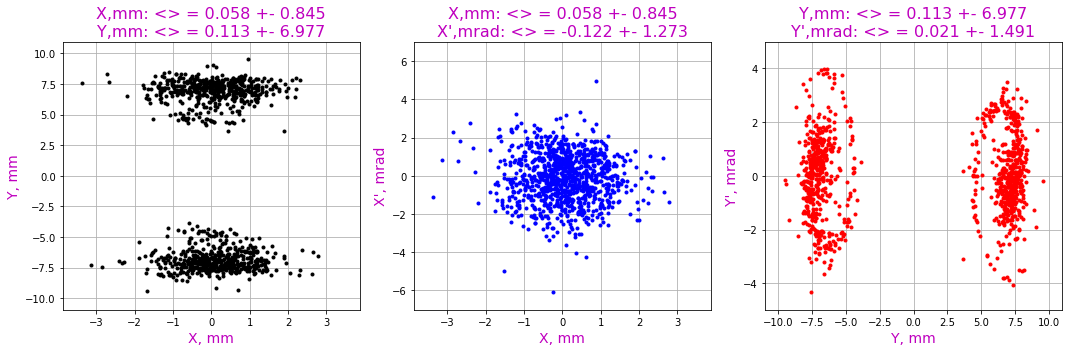

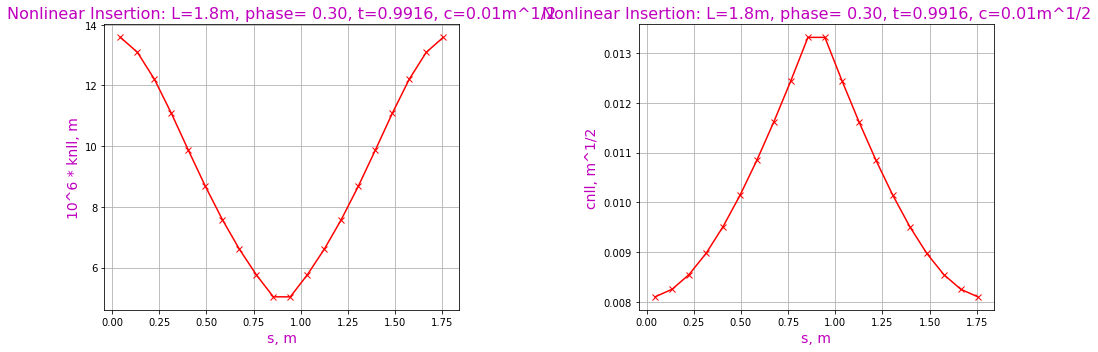


              After 880 turns:

Modified lattice (absolute magnification): Step  44
n.11 :  knll= 1.35529198816e-05  -->  1.35843724837e-05

Update and plotting are completed (CPU time =  1.920 seconds)

Turn 881 is completed (CPU time =  0.010 seconds)
Turn 882 is completed (CPU time =  0.000 seconds)
Turn 883 is completed (CPU time =  0.000 seconds)
Turn 884 is completed (CPU time =  0.010 seconds)
Turn 885 is completed (CPU time =  0.000 seconds)
Turn 886 is completed (CPU time =  0.000 seconds)
Turn 887 is completed (CPU time =  0.000 seconds)
Turn 888 is completed (CPU time =  0.010 seconds)
Turn 889 is completed (CPU time =  0.000 seconds)
Turn 890 is completed (CPU time =  0.000 seconds)
Turn 891 is completed (CPU time =  0.000 seconds)
Turn 892 is completed (CPU time =  0.010 seconds)
Turn 893 is completed (CPU time =  0.000 seconds)
Turn 894 is completed (CPU time =  0.000 seconds)
Turn 895 is completed (CPU time =  0.000 seconds)
Turn 896 is completed (CPU time =  0.010 seco

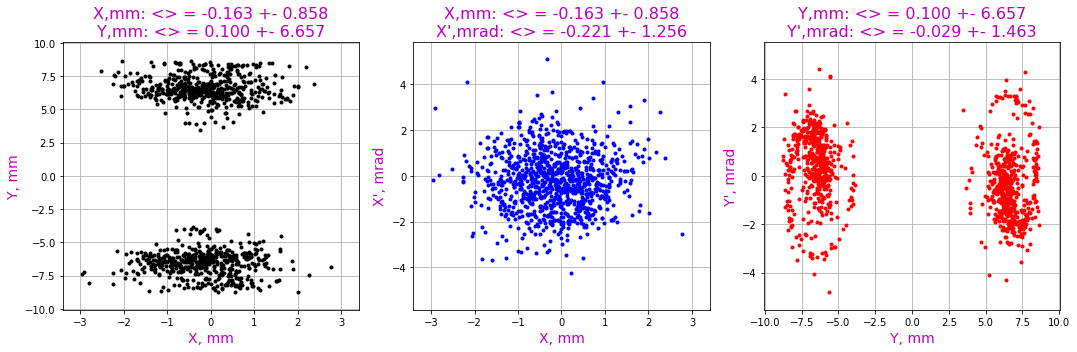

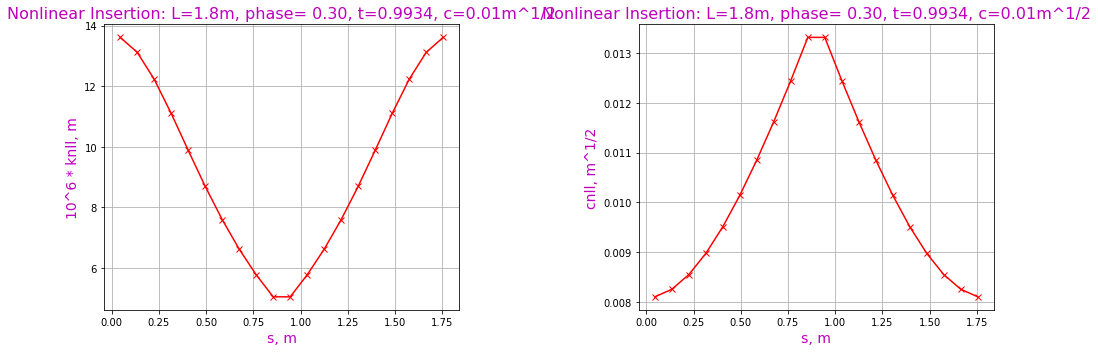


              After 900 turns:

Modified lattice (absolute magnification): Step  45
n.11 :  knll= 1.35843724837e-05  -->  1.36090951398e-05

Update and plotting are completed (CPU time =  1.940 seconds)

Turn 901 is completed (CPU time =  0.010 seconds)
Turn 902 is completed (CPU time =  0.000 seconds)
Turn 903 is completed (CPU time =  0.000 seconds)
Turn 904 is completed (CPU time =  0.010 seconds)
Turn 905 is completed (CPU time =  0.000 seconds)
Turn 906 is completed (CPU time =  0.000 seconds)
Turn 907 is completed (CPU time =  0.000 seconds)
Turn 908 is completed (CPU time =  0.000 seconds)
Turn 909 is completed (CPU time =  0.000 seconds)
Turn 910 is completed (CPU time =  0.000 seconds)
Turn 911 is completed (CPU time =  0.000 seconds)
Turn 912 is completed (CPU time =  0.000 seconds)
Turn 913 is completed (CPU time =  0.000 seconds)
Turn 914 is completed (CPU time =  0.000 seconds)
Turn 915 is completed (CPU time =  0.010 seconds)
Turn 916 is completed (CPU time =  0.000 seco

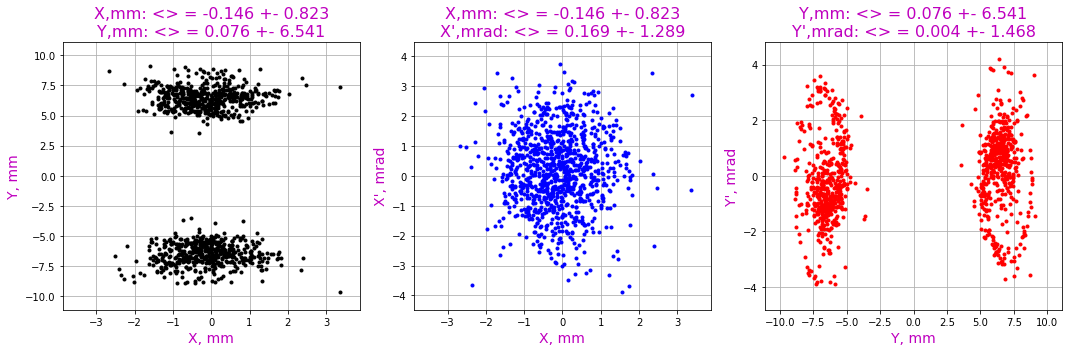

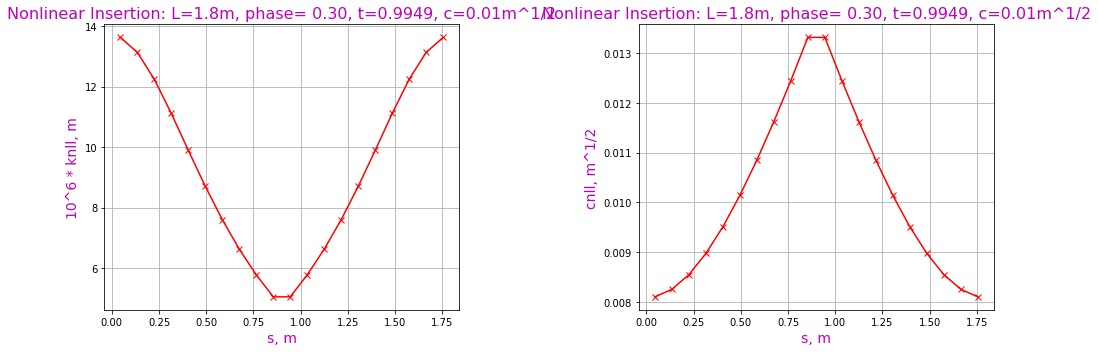


              After 920 turns:

Modified lattice (absolute magnification): Step  46
n.11 :  knll= 1.36090951398e-05  -->  1.36285105293e-05

Update and plotting are completed (CPU time =  1.960 seconds)

Turn 921 is completed (CPU time =  0.000 seconds)
Turn 922 is completed (CPU time =  0.000 seconds)
Turn 923 is completed (CPU time =  0.000 seconds)
Turn 924 is completed (CPU time =  0.000 seconds)
Turn 925 is completed (CPU time =  0.010 seconds)
Turn 926 is completed (CPU time =  0.000 seconds)
Turn 927 is completed (CPU time =  0.000 seconds)
Turn 928 is completed (CPU time =  0.000 seconds)
Turn 929 is completed (CPU time =  0.000 seconds)
Turn 930 is completed (CPU time =  0.000 seconds)
Turn 931 is completed (CPU time =  0.000 seconds)
Turn 932 is completed (CPU time =  0.010 seconds)
Turn 933 is completed (CPU time =  0.000 seconds)
Turn 934 is completed (CPU time =  0.000 seconds)
Turn 935 is completed (CPU time =  0.000 seconds)
Turn 936 is completed (CPU time =  0.010 seco

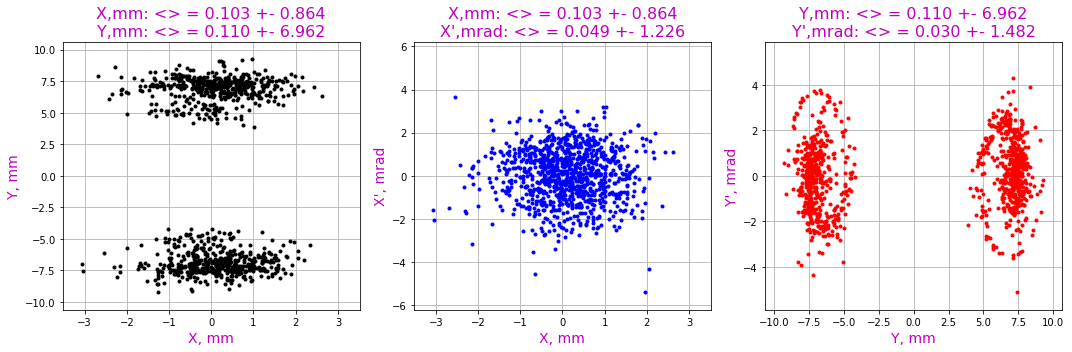

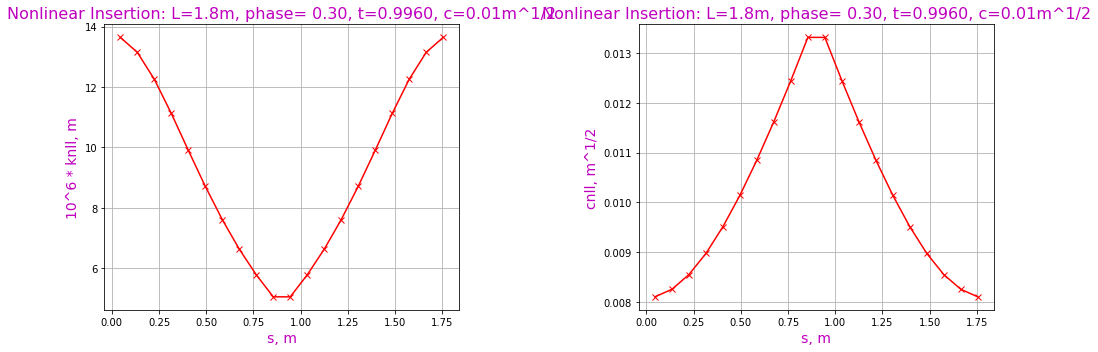


              After 940 turns:

Modified lattice (absolute magnification): Step  47
n.11 :  knll= 1.36285105293e-05  -->  1.36437472915e-05

Update and plotting are completed (CPU time =  2.000 seconds)

Turn 941 is completed (CPU time =  0.000 seconds)
Turn 942 is completed (CPU time =  0.000 seconds)
Turn 943 is completed (CPU time =  0.000 seconds)
Turn 944 is completed (CPU time =  0.000 seconds)
Turn 945 is completed (CPU time =  0.010 seconds)
Turn 946 is completed (CPU time =  0.000 seconds)
Turn 947 is completed (CPU time =  0.000 seconds)
Turn 948 is completed (CPU time =  0.000 seconds)
Turn 949 is completed (CPU time =  0.000 seconds)
Turn 950 is completed (CPU time =  0.000 seconds)
Turn 951 is completed (CPU time =  0.000 seconds)
Turn 952 is completed (CPU time =  0.010 seconds)
Turn 953 is completed (CPU time =  0.000 seconds)
Turn 954 is completed (CPU time =  0.000 seconds)
Turn 955 is completed (CPU time =  0.000 seconds)
Turn 956 is completed (CPU time =  0.000 seco

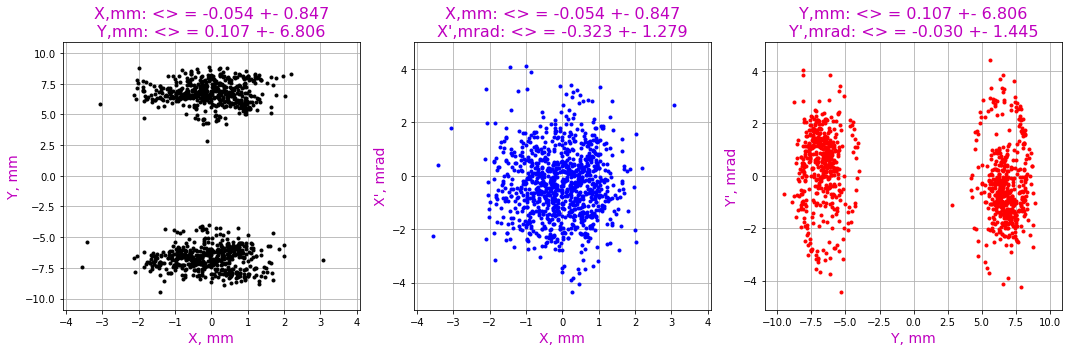

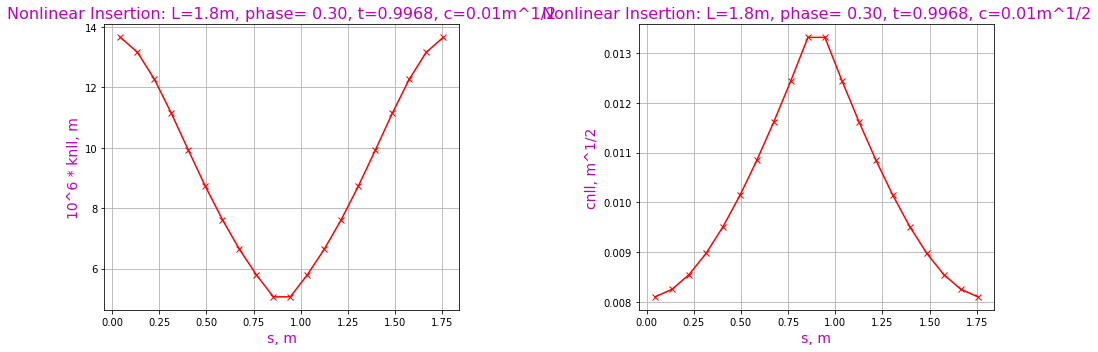


              After 960 turns:

Modified lattice (absolute magnification): Step  48
n.11 :  knll= 1.36437472915e-05  -->  1.3655698185e-05

Update and plotting are completed (CPU time =  1.920 seconds)

Turn 961 is completed (CPU time =  0.000 seconds)
Turn 962 is completed (CPU time =  0.000 seconds)
Turn 963 is completed (CPU time =  0.000 seconds)
Turn 964 is completed (CPU time =  0.000 seconds)
Turn 965 is completed (CPU time =  0.000 seconds)
Turn 966 is completed (CPU time =  0.000 seconds)
Turn 967 is completed (CPU time =  0.000 seconds)
Turn 968 is completed (CPU time =  0.000 seconds)
Turn 969 is completed (CPU time =  0.010 seconds)
Turn 970 is completed (CPU time =  0.000 seconds)
Turn 971 is completed (CPU time =  0.000 seconds)
Turn 972 is completed (CPU time =  0.000 seconds)
Turn 973 is completed (CPU time =  0.000 seconds)
Turn 974 is completed (CPU time =  0.000 seconds)
Turn 975 is completed (CPU time =  0.000 seconds)
Turn 976 is completed (CPU time =  0.000 secon

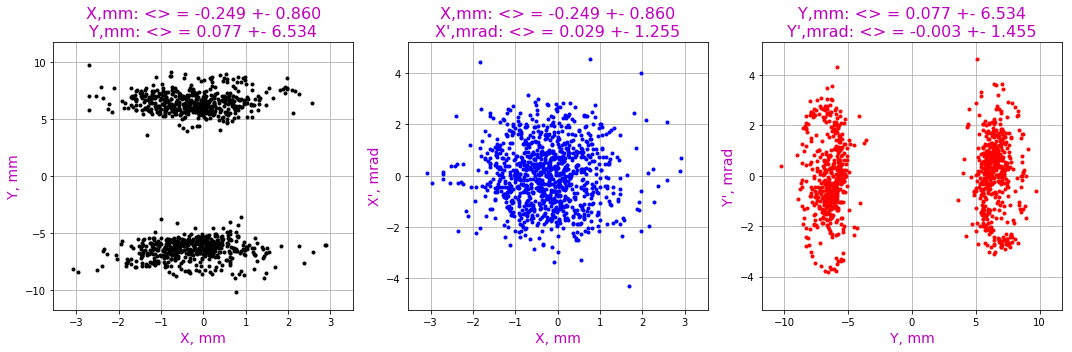

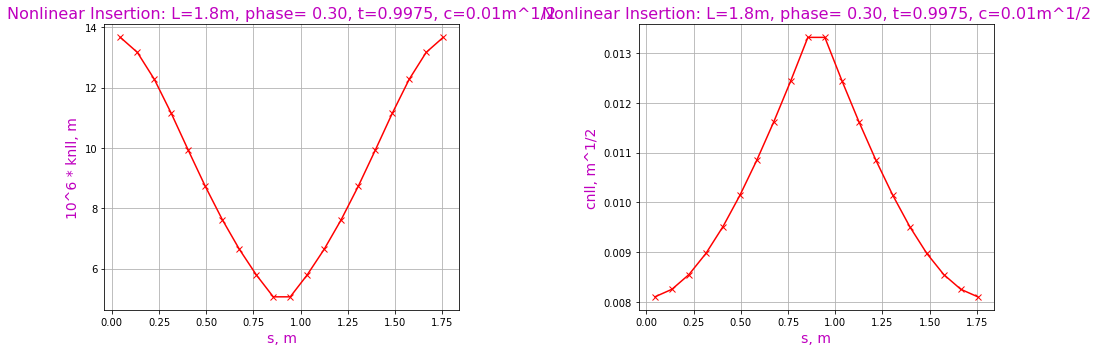


              After 980 turns:

Modified lattice (absolute magnification): Step  49
n.11 :  knll= 1.3655698185e-05  -->  1.36650677767e-05

Update and plotting are completed (CPU time =  1.840 seconds)

Turn 981 is completed (CPU time =  0.000 seconds)
Turn 982 is completed (CPU time =  0.000 seconds)
Turn 983 is completed (CPU time =  0.000 seconds)
Turn 984 is completed (CPU time =  0.000 seconds)
Turn 985 is completed (CPU time =  0.000 seconds)
Turn 986 is completed (CPU time =  0.000 seconds)
Turn 987 is completed (CPU time =  0.000 seconds)
Turn 988 is completed (CPU time =  0.000 seconds)
Turn 989 is completed (CPU time =  0.000 seconds)
Turn 990 is completed (CPU time =  0.000 seconds)
Turn 991 is completed (CPU time =  0.000 seconds)
Turn 992 is completed (CPU time =  0.000 seconds)
Turn 993 is completed (CPU time =  0.000 seconds)
Turn 994 is completed (CPU time =  0.000 seconds)
Turn 995 is completed (CPU time =  0.000 seconds)
Turn 996 is completed (CPU time =  0.000 secon

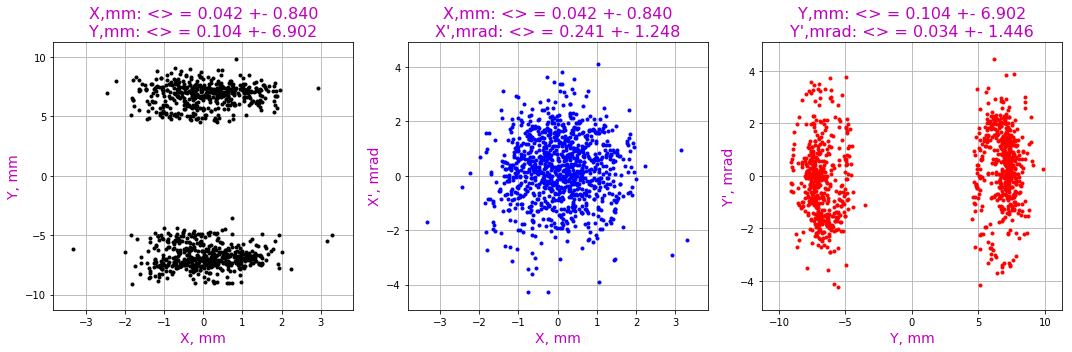

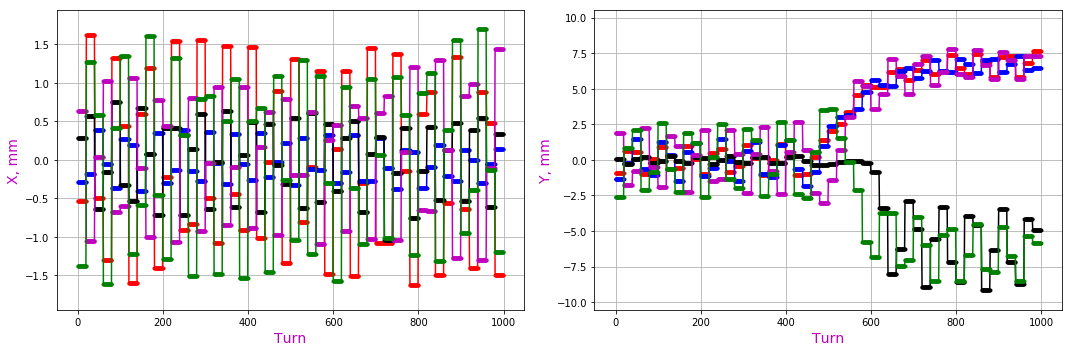


For  1000 turns CPU time = 97.670 seconds



In [ ]:
# 
# This script develops the script 'variabledNLsimulation_v1.py' (Yury Eidelman)
#
#    Started at June 28, 2019
#
# The three laws to change the strengths 't' of all nonlinear lens are implemented.
# From initial value t_i to final value t_f during N stepsthese laws are follows.
# 1) Linear: for step number n
#           t(n) = t_0 + (t_f-t_0)*n/(N-1) for n = 0,1,...,N-1 .
# 2) Parabolic: for step number n
#           t(n) = t_0 + (t_f-t_0)*n^2/(N-1)^2 for n = 0,1,...,N-1 .
# 3) Smooth sign-function: for step number n
#           t(n) = .5*(t_0+t_f) + .5*(t_f-t_0)*tanh(x(n)), where
#           x(n) = (6*n-3*(N-1))/(N-1) for n=0,1,...,N-1 .
# In this approach x(0) = -3., x(N-1) = 3.; so, tanh(3.) = - tanh(-3.) = .9951
#

import synergia
import os, sys
import inspect
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec

import rssynergia 
from rssynergia.base_diagnostics import lfplot
from rssynergia.base_diagnostics import plotbeam
from rssynergia.base_diagnostics import pltbunch

def plotcoordDistr(bunchParticles):
#    
# Plot X-X', Y-Y', and X-Y distributions for 'bunchParticles'
#
# bunchParticles is a 'bunch' object;
# particles is 2D array: (numberOfParticles,(x,x',y,y',s,dp(?),ID);
#
    numbPartcls = bunchParticles.shape[0]
    particles = bunchParticles.real
    newCoordinates = np.zeros((6,numbPartcls))
    for k in range(numbPartcls):
        for j in range(6):
            newCoordinates[j,k] = 1.e3*particles[k,j]       # Units: mm and mrad 
    xmax = 1.15*np.max(abs(newCoordinates[0,:]))
    xpmax = 1.15*np.max(abs(newCoordinates[1,:]))
    ymax = 1.15*np.max(abs(newCoordinates[2,:]))
    ypmax = 1.15*np.max(abs(newCoordinates[3,:]))
    meanX = np.mean(newCoordinates[0,:])
    meanPX = np.mean(newCoordinates[1,:])
    stdX = np.std(newCoordinates[0,:])
    stdPX = np.std(newCoordinates[1,:])
    meanY = np.mean(newCoordinates[2,:])
    meanPY = np.mean(newCoordinates[3,:])
    stdY = np.std(newCoordinates[2,:])
    stdPY = np.std(newCoordinates[3,:])

# Another way - use gridspec
    fig = plt.figure(figsize=(15,5))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1,1,1]) 
    
    ax0 = plt.subplot(gs[0])
    plt.plot(newCoordinates[0,:],newCoordinates[2,:],'.',color='k')
    x0Title = "X,mm: <> = {:.3f} +- {:.3f}\nY,mm: <> = {:.3f} +- {:.3f}".format(meanX,stdX,meanY,stdY)
    ax0.set_title(x0Title,color='m',fontsize='16')
    ax0.set_xlim([-xmax,xmax])
    ax0.set_ylim([-ymax,ymax])
    ax0.set_xlabel('X, mm',color='m',fontsize='14')
    ax0.set_ylabel('Y, mm',color='m',fontsize='14')
    ax0.grid(True)
    
    ax1 = plt.subplot(gs[1])
    plt.plot(newCoordinates[0,:],newCoordinates[1,:],'.',color='b')
    x1Title = "X,mm: <> = {:.3f} +- {:.3f}\nX\',mrad: <> = {:.3f} +- {:.3f}".format(meanX,stdX,meanPX,stdPX)
    ax1.set_title(x1Title,color='m',fontsize='16')
    ax1.set_xlim([-xmax,xmax])
    ax1.set_ylim([-xpmax,xpmax])
    ax1.set_xlabel('X, mm',color='m',fontsize='14')
    ax1.set_ylabel('X\', mrad',color='m',fontsize='14')
    ax1.grid(True)
    
    ax2 = plt.subplot(gs[2])
    plt.plot(newCoordinates[2,:],newCoordinates[3,:],'.',color='r')
    x2Title = "Y,mm: <> = {:.3f} +- {:.3f}\nY\',mrad: <> = {:.3f} +- {:.3f}".format(meanY,stdY,meanPY,stdPY)
    ax2.set_title(x2Title,color='m',fontsize='16')
    ax2.set_xlim([-ymax,ymax])
    ax2.set_ylim([-ypmax,ypmax])
    ax2.set_xlabel('Y, mm',color='m',fontsize='14')
    ax2.set_ylabel('Y\', mrad',color='m',fontsize='14')
    ax2.grid(True)
    
#    fig.canvas.set_window_title('Synergia Phase Space Distribution')
    fig.tight_layout()
    plt.show()
    return

def plotTracks(tracksCoords,numberTracks):
#    
# Plot'numberTracks' tracks from 'tracksCoords'
#
# tracksCoords is 3D array: (totalTurns,particles,(x,y))
#
#    print "numberTracks = ",numberTracks
    trackColor = ['r','b','k','m','g']
    numbPoints = tracksCoords.shape[0]
#    print "numbPoints = ",numbPoints
    xmax = 1.15*np.max(np.max(abs(tracksCoords[:,0:numberTracks,0])))
    ymax = 1.15*np.max(np.max(abs(tracksCoords[:,0:numberTracks,1])))

    turn = np.arange(0,numbPoints)
# Another way - use gridspec
    fig = plt.figure(figsize=(15,5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,1]) 
    
    ax0 = plt.subplot(gs[0])
    for prtcl in range(numberTracks):
        plt.plot(turn,tracksCoords[0:numbPoints,prtcl,0],'.-',color=trackColor[prtcl])
#    x0Title = "X,mm: <> = {:.3f} +- {:.3f}\nY,mm: <> = {:.3f} +- {:.3f}".format(meanX,stdX,meanY,stdY)
#    ax0.set_title(x0Title,color='m',fontsize='16')
    ax0.set_ylim([-xmax,xmax])
    ax0.set_xlabel('Turn',color='m',fontsize='14')
    ax0.set_ylabel('X, mm',color='m',fontsize='14')
    ax0.grid(True)

    ax1 = plt.subplot(gs[1])
    for prtcl in range(numberTracks):
        plt.plot(turn,tracksCoords[0:numbPoints,prtcl,1],'.-',color=trackColor[prtcl])
#    x0Title = "X,mm: <> = {:.3f} +- {:.3f}\nY,mm: <> = {:.3f} +- {:.3f}".format(meanX,stdX,meanY,stdY)
#    ax0.set_title(x0Title,color='m',fontsize='16')
    ax1.set_ylim([-ymax,ymax])
    ax1.set_xlabel('Turn',color='m',fontsize='14')
    ax1.set_ylabel('Y, mm',color='m',fontsize='14')
    ax1.grid(True)
       
#    fig.canvas.set_window_title('Synergia Phase Space Distribution')
    fig.tight_layout()
    plt.show()
    return

def plotParamLens(s_center,knll,cnll,title0,title1):
#
# Plot distribution of the strength 'knll' of the nonlinear lens inside
# nonlinear insertion:
#
    knll_plot = np.zeros(len(knll))
    for n in range(len(knll)):
        knll_plot[n]=1.e6*knll[n]
# Another way - use gridspec
    fig = plt.figure(figsize=(15,5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,1]) 
    
    ax0 = plt.subplot(gs[0])
    plt.plot(s_center,knll_plot,'-x',color='r')
    ax0.set_xlabel('s, m',color='m',fontsize=14)
    ax0.set_ylabel('10^6 * knll, m',color='m',fontsize=14)
    ax0.set_title(title0,color='m',fontsize=16)
    ax0.grid(True)

    ax1 = plt.subplot(gs[1])
    plt.plot(s_center,cnll,'-x',color='r')
    ax1.set_xlabel('s, m',color='m',fontsize=14)
    ax1.set_ylabel('cnll, m^1/2',color='m',fontsize=14)
    ax1.set_title(title1,color='m',fontsize=16)
    ax1.grid(True)
       
    fig.tight_layout()
    plt.show()
    return

def printAttributes(object,name,title):
#
# List of all attributes of 'object' for checking:
#
    attrList = inspect.getmembers(object)
    strTitle = "\nattrList ("+name+" = "+title+"):\n{}\n"
    print strTitle.format(attrList)

def tracksCoords(bunchParticles):
#
# Preparation of the track coordinates:
#
# 'bunchParticle' is a 'bunch' object;
# 'particles' is 2D array: (numberParrticles,(x,x',y,y',s,dE,ID));
#
    numbPartcls = bunchParticles.shape[0]
    particles = bunchParticles.real
    trackCoordinates = np.zeros((numbPartcls,2))
    for prtcl in range(numbPartcls):
        trackCoordinates[prtcl,0] = 1.e3*particles[prtcl,0]       # x, mm
        trackCoordinates[prtcl,1] = 1.e3*particles[prtcl,2]       # y, mm
#        if prtcl < 3:
#            print "Particle {}: x = {} mm, y = {} mm". \
#            format(prtcl,trackCoordinates[prtcl,0],trackCoordinates[prtcl,1])
    return trackCoordinates 
    
class NonlinearInsertion(object):
#  
# Generation of the nonlinear lenses as set of segments of the nonlinear insertion
#
# Source: 
#   1) Nonlinear Accelerator Lattices with One and Two Analytic Invariants.
#      V. Danilov and S. Nagaitsev. Phys. Rev. ST Accel. Beams 13, 084002 (2010);
#      https://journals.aps.org/prab/pdf/10.1103/PhysRevSTAB.13.084002.  
#   2) Complex Representation of Potentials and Fields for the Nonlinear 
#      Magnetic Insert of the Integrable Optics Test Accelerator.
#      Chad Mitchell. March 2017; https://esholarship.org/uc/item/7dt4t236.
#   3) Madx CERN User Guide. Chapter 10.10 - Nonlinear Lens with Elliptical Potential.
#      http://mad.web.cern.ch/mad/
#
# Input args:
#   length:     the length of the nonlinear insertion (float, m);
#   phase:      the phase advance modulo 2pi through the nonlinear insertion;
#   t:          the strength parameter for center of the insertion (float, dimensionless, 
#               defaults to 0.1);
#   c:          the aperture parameter for center of the insertion 
#               (float, m^1/2, is defined by poles in the x-axis, defaults to 0.01);
#   num_lens:   the number of lonlinear lenses as an segments of the insertion (int, defaults to 20).   

#
# Output attributes are the same as input one.
#
    def __init__(self, length, phase, t = 0.1, c = 0.01, num_lens = 20):
        self.length = length
        self.phase = phase
        self.t = t
        self._c = c
        self.num_lens = num_lens
#        print "Input data for NonlinearInsertion:\nlength = ",self.length,", phase = ",self.phase, \
#              ", t = ",self.t,", c = ",self.c,", num_lens = ",self.num_lens
# Aperture parameter c must be positive:
    @property
    def c(self):
        return self._c
    @c.setter
    def c(self, cval):
        if cval < 0:
            raise ValueError("Aperture parameter c must be positive")     
        self._c = c
#
# Output attributes of 'generate_lens' method:
#
#   same as output of 'NonlinearInsertion'class and as well:
#   s_vals (ndArray): coordinates of the center of each nonlinear lens (float ndArray, m);
#   knll (ndArray):   "strength" of each nonlinear lens (float ndArray, m);
#   cnll (ndArray):   aperture parameters for each nonlinear lens (float ndArray, m^1/2).
#   
    def generate_lens(self,flag):
        indxShift = self.num_lens-2*((self.num_lens+1)/2)+1
# Focal length f0 of the insertion (m):
        f0 = self.length/4.0*(1.0+1.0/np.tan(np.pi*self.phase)**2)
#        print "f0 = ",f0
# Coordinates s_vals of the center of each nonlinear lens (m):
        first_lens = .5*(self.length/self.num_lens)
        last_lens = self.length - first_lens
        s_vals = np.linspace(first_lens,last_lens,self.num_lens) 
        self.s_vals = s_vals
        
# Set the structural beta-function of the nonlinear magnet (m):
        beta_n = self.length*(1.-s_vals*(self.length-s_vals)/self.length/f0)/ \
                 np.sqrt(1.0-(1.0-self.length/2.0/f0)**2)
#        self.betas = beta_n
        
        cnll = self.c*np.sqrt(beta_n)

        knn = self.t*self.length/self.num_lens/beta_n**2
        knll = knn*cnll**2
# Sequence of lenses start from the minimal value of knll (flag = 1):
        self.cnll = cnll
        self.knll = knll
# Sequence of lenses start from the maximal value of knll (flag = 2):
        if flag == 2:
            cnll_help = []
            knll_help = []
            indxMax = 0
            for n in range(self.num_lens-1):
                if knll[n] < knll[n+1]:
                    indxMax = n+1
                else:
                    break
            for n in range (self.num_lens):
                if n <= indxMax:
                    cnll_help.append(float(cnll[indxMax-n]))
                    knll_help.append(float(knll[indxMax-n]))
                else:
                    cnll_help.append(float(cnll[n-indxMax-indxShift]))
                    knll_help.append(float(knll[n-indxMax-indxShift]))
            self.cnll = cnll_help
            self.knll = knll_help
        return self
                
# Pickle helper is not necessary but is retained for this example
#
class Pickle_helper:
    __getstate_manages_dict__ = 1
    def __init__(self, *args):
        self.args = args
    def __getinitargs__(self):
        return self.args
    def __getstate__(self):
        return self.__dict__
    def __setstate__(self, state):
        self.__dict__ = state
        
# Definition of class to ramp nonlinear lens

class Ramp_actions(synergia.simulation.Propagate_actions, Pickle_helper):
#
# Args of 'Ramp_actions' method are: 
# 'type'             - type of magnification (1 - relative, 2 - absolute),
# 'stepNumber'       - current step of magnification,
# 'strengthLens'     - set of strengthes 't' of central lens of the nonlinear insertion for all steps of
#                      magnification (relative magnification) or set of strengthes 't' of all lenses for 
#                      current step (absolute magnification),
# 'updateOutputFlag' - flag to output the strength of one of nonlinear lens after it's magnification 
#                      for current step,
# controlName        - name of lens with maximal strength to use in output for checking of process 
#                     of magnification.    
#

#
# The arguments to __init__ are what the Ramp_actions instance is initialized with:
    def __init__(self, type,stepNumber,strengthLens,outputFlag,controlName):
        selfObject = synergia.simulation.Propagate_actions.__init__(self)
# To recognize attributes of 'selfObject':
#        printAttributes(selfObject,'selfObject','synergia.simulation.Propagate_actions.__init__(self)')

# Pickling the arguments to the initializer allows the module to resume
# after checkpointing. They should be in the same order as the arguments to __init__.
        Pickle_helper.__init__(self, type,stepNumber,strengthLens,outputFlag,controlName)
        self.type = type
        self.stepNumber = stepNumber
        self.strengthLens = strengthLens        
        self.outputFlag = outputFlag
        self.controlName = controlName
    
    def turn_end_action(self, stepper, bunch, turn_num):
#---------------------------
# For checking:
#        testObject = stepper.get_lattice_simulator().get_lattice()
# To recognize attributes of 'testObject':
#        printAttributes(testObject,'testObject','stepper.get_lattice_simulator().get_lattice()')
#        print "testName = '{}'".format(testObject.get_name())
#---------------------------

# Relative magnification:
        if self.type == 1:
            if self.stepNumber == 0:
                self.multiplier = self.strengthLens[0]
                print "Initialization lattice (relative magnification): Step ",self.stepNumber, \
                      ", multiplier = ",self.multiplier
            else:
                self.multiplier = self.strengthLens[self.stepNumber]/self.strengthLens[self.stepNumber-1]
# Output title for checking of variables update:   
                print "Modified lattice (relative magnification): Step ",self.stepNumber, \
                      ", multiplier = ",self.multiplier
            for element in stepper.get_lattice_simulator().get_lattice().get_elements():
# To recognize attributes of 'element':
#                printAttributes(element,'element', \
#                                    'stepper.get_lattice_simulator().get_lattice().get_elements()')
                if element.get_type() == "nllens":
                    old_knll = element.get_double_attribute("knll")
                    new_knll = self.multiplier*old_knll
                    element.set_double_attribute("knll", new_knll)
# Output for checking of variables update checking nonlinear lens 'n.11' only:  
                    if ((self.outputFlag == 1) and (element.get_name() == self.controlName)):
                        print element.get_name(),":  knll=",old_knll," --> ",new_knll
# Absolute magnification:
        if self.type == 2:
# Output title for checking of variables update:   
            print "Modified lattice (absolute magnification): Step ",self.stepNumber
            crrntLens = 0
            for element in stepper.get_lattice_simulator().get_lattice().get_elements():
# To recognize attributes of 'element':
#                printAttributes(element,'element', \
#                                    'stepper.get_lattice_simulator().get_lattice().get_elements()')
                if element.get_type() == "nllens":
                    old_knll = element.get_double_attribute("knll")
                    new_knll = self.strengthLens[crrntLens]
                    element.set_double_attribute("knll", new_knll)
                    crrntLens += 1
# Output for checking of variables update checking nonlinear lens 'n.11' only:  
                    if ((self.outputFlag == 1) and (element.get_name() == self.controlName)):
                        print element.get_name(),":  knll=",old_knll," --> ",new_knll
        stepper.get_lattice_simulator().update()

def t_on_knll_function(l0,mu0,cval,lensNumb):
#
# "Reverse" dependence dimensionless strength 'tval' of nonlinear central lens on 
# parameter 'knll' of this lens
#
    nPoints = 50
    knll = np.zeros(nPoints)
    t = np.zeros(nPoints)
    knll_logMin = math.log10(1.e-7)
    knll_logMax = math.log10(1.e-4)

# Focal length f0 of the insertion (m):
    f0 = l0/4.0*(1.0+1.0/np.tan(np.pi*mu0)**2)
#    print "f0 = ",f0," m"

# Coordinate of the centers of the nonlinear lenses (m):
    first_lens_center = .5*(l0/lensNumb)
    last_lens_center = l0 - first_lens_center
    s_vals = np.linspace(first_lens_center,last_lens_center,lensNumb) 
#    print "s_val =",s_vals        
# Coordinate of the center of the nonlinear lens in the middle of nonlinear inserion (m):
    s_center = s_vals[(num_lens+1)/2]
# Structural beta-function in the nonlinear magnet (m):
    beta_center = l0*(1.-s_center*(l0-s_center)/l0/f0)/np.sqrt(1.0-(1.0-l0/2.0/f0)**2)
    cnll_center = cval*np.sqrt(beta_center)
#    print "s_center = ",s_center," m, beta_center = ",beta_center," m, cnll_center = ",cnll_center," m"

    for n in range(nPoints):
        knll_log10 = knll_logMin + n*(knll_logMax - knll_logMin)/nPoints
        knll[n] = math.pow(10.,knll_log10)
        t[n] = knll[n]*beta_center**2/(l0/lensNumb*cnll_center**2)
    
    fig_10 = plt.figure(figsize=(15,5))
    gs_10 = gridspec.GridSpec(1, 2, width_ratios=[1,1]) 
    
    ax_10 = plt.subplot(gs_10[0])
#    plt.semilogx(knll,t,'-x',color='r')
    plt.loglog(knll,t,'-x',color='r')
    ax_10.set_xlabel('knnl, m',color='m',fontsize=14)
    ax_10.set_ylabel('Srength Parameter of the central lens, t',color='m',fontsize=14)
# Attempt to change number of grid lines:
#    start, end = ax_10.get_xlim()
#    ax_10.xaxis.set_ticks(np.arange(start, end, (end-start)/30))

    title_t = "Nonlinear Insertion ({} lenses): L={:.2f} m, phase= {:.2f}, c={:.2f} m^1/2". \
               format(lensNumb,l0, mu0, cval)
    ax_10.set_title(title_t,color='m',fontsize=14)
    ax_10.grid(True)

    fig_10.tight_layout()
    plt.show()
    return

def lawsMagnification(t_i,t_f,steps):

# For relative magnification: t_i = 1., t_f = magnification: 
#
# Three laws of magnification are in use
#
# 1) Linear: for step number n
#       t(n) = t_i + (t_f-t_i)*n/(N-1) for n = 0,1,...,N-1 .
    tLin = np.zeros(steps)
    for n in range(steps):
        tLin[n] = t_i+n*(t_f-t_i)/(steps-1)
# 2) Parabolic: for step number n
#            t(n) = t_i + (t_f-t_i)*n^2/(N-1)^2 for n = 0,1,...,N-1 .
    tPar= np.zeros(steps)
    for n in range(steps):
        tPar[n] = t_i+n**2*(t_f-t_i)/(steps-1)**2
# 3) Smooth sign-function: for step number n
#           t(n) = .5*(t_f+t_i) + .5*(t_f-t_i)*tanh(x(n)), where
#           x(n) = (6*n-3*(N-1))/(N-1) for n=0,1,...,N-1 .
# In this approach x(0) = -3., x(N-1) = 3.; so, tanh(3.) = - tanh(-3.) = .9951
    tSSF= np.zeros(steps)
    for n in range(steps):
        x = (6.*n-3.*(steps-1))/(steps-1)
        tSSF[n] = .5*(t_f+t_i)+.5*(t_f-t_i)*np.tanh(x)
# Plotting all cases:
    step = range(steps)
    tMin = .975*min(tLin)
    tMax = 1.025*max(tLin)
    fig = plt.figure(figsize=(15,5))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1,1,1]) 
    
    ax0 = plt.subplot(gs[0])
    plt.plot(step,tLin,'-x',color='r')
    x0Title = 'Linear Magnification'
    ax0.set_title(x0Title,color='m',fontsize='16')
    ax0.set_xlim([-1,steps+1])
    ax0.set_ylim([tMin,tMax])
    ax0.set_xlabel('Step n',color='m',fontsize='14')
    ax0.set_ylabel('t',color='m',fontsize='14')
    ax0.grid(True)
    
    ax1 = plt.subplot(gs[1])
    plt.plot(step,tPar,'-x',color='r')
    x1Title = 'Parabolic Magnification'
    ax1.set_title(x1Title,color='m',fontsize='16')
    ax1.set_xlim([-1,steps+1])
    ax1.set_ylim([tMin,tMax])
    ax1.set_xlabel('Step n',color='m',fontsize='14')
    ax1.set_ylabel('t',color='m',fontsize='14')
    ax1.grid(True)
    
    ax2 = plt.subplot(gs[2])
    plt.plot(step,tSSF,'-x',color='r')
    x2Title = 'Smooth Sign-function Magnification'
    ax2.set_title(x2Title,color='m',fontsize='16')
    ax2.set_xlim([-1,steps+1])
    ax2.set_ylim([tMin,tMax])
    ax2.set_xlabel('Step n',color='m',fontsize='14')
    ax2.set_ylabel('t',color='m',fontsize='14')
    ax2.grid(True)

    fig.tight_layout()
    plt.show()

    selection = int(raw_input("\nYour selection of the law magnification \
    \n(1 - linear, 2 - parabolic, 3 - smooth sign-function; -1 - exit): "))
    return selection
        
#   
# Main method 'simulation'
#
def simulation():
#
# Main predefined parameters of the nonlinear insertion:
    insrtn_l0 = 1.8      # total length, m
    insrtn_mu0 = .3      # phase, rad (/2pi)
    insrtn_c = .01       # aperture factor,  m^(1/2)
    num_lens = 20        # number of lens inside insertion
#
# Interactive input of the parameters for simulation:
#
    particlesInBunch = int(raw_input('\nTotal number of particles (= -1 to interrupt simulation):')) 
    if particlesInBunch == -1:
        return

    totalTurns = int(raw_input('\nTotal number if turns (= -1 to interrupt simulation):')) 
    if totalTurns == -1:
        return

    updateAfterTurns = int(raw_input( \
    '\nPeriodicity (in turns) to update the parameters and distribution plots \n(nonlinear structure; = -1 to interrupt simulation)'))
    if updateAfterTurns == -1:
        return
    stepsInMgnfctn = int(totalTurns/updateAfterTurns)+0
    print "steps for magnification: ",stepsInMgnfctn

    updateOutputFlag = int(raw_input('\nupdateOutputFlag (0 - no, 1 - yes, -1 - to interrupt simulation):'))
    if updateOutputFlag == -1:
        return

    magnificationType = int(raw_input( \
                     '\nMagnification type \n(1 - relative, 2 - absolute, 0 - to interrupt simulation):'))
    if magnificationType == 0:
        return
    else:
        if magnificationType == 1:
            mgnfctnFctr = float(raw_input( \
    "\nFactor of relative magnification (RM) of the strength 't' of all (!) nonlinear lenses \n (RM = t_f/t_i; -1. - to interrupt simulation):"))
            if mgnfctnFctr == -1.:
                return
            else: 
                t_i = 1.
                t_f = mgnfctnFctr
        else:
            print "\nInformation for help (20 nonlinear lenses inside of the insertion): \n"
            t_on_knll_function(insrtn_l0,insrtn_mu0,insrtn_c,20)
            t_i = float(raw_input( \
    "\nInitial value 't_i' of the strength of the central (!) nonlinear lens \n (-1.- to interrupt simulation):"))
            if t_i == -1.:
                return
            t_f = float(raw_input( \
    "\nFinal value 't_f' of the strength of nonlinear lens \n (-1.- to interrupt simulation):"))
            if t_f == -1.:
                return
    print ""
    law = lawsMagnification(t_i,t_f,stepsInMgnfctn)
    print 'Your selection of law magnification: ', law
    if law == -1:
        return

# Input data for simulation:
    print "\n################################################################\n###"
    print "###            Parameters for simulation:\n###"
    print "###     Particles in the bunch = ",particlesInBunch
    print "###     Total number of turns = ",totalTurns
    print "###     Periodicity (in turns) to update the parameters = ",updateAfterTurns
    print "###     magnificationType = ",magnificationType
    if magnificationType == 1:
        print "###     Factor of relative magnification (RM) = ",mgnfctnFctr
    if magnificationType == 2:
        print "###     For absolute magnification (AM) initial value t_i = ",t_i
        print "###     For absolute magnification (AM) final value t_f = ",t_f
    laws = ['linear', 'parabolic', 'smooth sign-function']
    print "###     Law of magnification: ",laws[law-1]
    print "###     Steps in magnification: ",stepsInMgnfctn
    print "###\n###        Predefined parameters for nonlinear insertion:\n###"
    print "###     Length = ",insrtn_l0," m"
    print "###     Phase = ",insrtn_mu0," rad (/2pi)"
    print "###     Aperture factor = ",insrtn_c," m^(1/2)"
    print "###     Number of lens inside insertion = ",num_lens
    print "###\n################################################################"
#
# For relative type of maginfication (magnificationType = 1):
#
    if magnificationType == 1:
#
# t_i = 1. and t_f is total factor of magnification.
# So, 1D-array 'strengthLens[0:stepsInMgnfctn]' describes current value of the 
# strength (knll) of lens for current step n; Then 1D-array 'magnifications[0:stepsInMgnfctn]'
# describe magnification factor to pass from old_knll_value = knll[n-1] to 
# new_knll_value = knll[n] on step n:
#    new_knll_value = magnifications[n]*old_knll_value .
# Factor 'magnifications' is the same for all lens of nonlinear insertion!
#
        strengthLens = np.zeros(stepsInMgnfctn)
        magnifications = np.zeros(stepsInMgnfctn)
        totalMgnfcn = 1.
#
# For absolute magnification  (magnificationType = 2):
#
    if magnificationType == 2:
#
# parameters t_i and t_f characterize only central lens of nonlinear insertion. 
# So, the strength of 't' for all rest lenses must be recalculate in corresponding  
# distribution of beta-function inside the insertion by using method 'generate_lens'. 
# So, 1D-array 'strengthLens[0:stepsInMgnfctn]' describes value of the strength 
# of central lens only for current step n. 
# 
        strengthLens = np.zeros(stepsInMgnfctn)
    for n in range(stepsInMgnfctn):
        if law == 1:
# 1) Linear: for step number n
#           t(n) = t_i + (t_f-t_i)*n/(N-1) for n = 0,1,...,N-1 .
            strengthLens[n] = t_i+n*(t_f-t_i)/(stepsInMgnfctn-1)
        elif law == 2:
# 2) Parabolic: for step number n
#           t(n) = t_i + (t_f-t_i)*n^2/(N-1)^2 for n = 0,1,...,N-1 .
            strengthLens[n] = t_i+n**2*(t_f-t_i)/(stepsInMgnfctn-1)**2
        elif law == 3:
# 3) Smooth sign-function: for step number n
#           t(n) = .5*(t_i+t_f) + .5*(t_f-t_i)*tanh(x(n)), where
#           x(n) = (6*n-3*(N-1))/(N-1) for n=0,1,...,N-1 .
# In this approach x(0) = -3., x(N-1) = 3.; so, tanh(3.) = - tanh(-3.) = .9951
            x = (6.*n-3.*(stepsInMgnfctn-1))/(stepsInMgnfctn-1)
            strengthLens[n] = .5*(t_i+t_f)+.5*(t_f-t_i)*np.tanh(x)
        if magnificationType == 1:
            if n == 0:
                print "\nRelative magnification:"
                magnifications[n] = strengthLens[n]
            else:
                magnifications[n] = strengthLens[n]/strengthLens[n-1]
            print "    magnifications[{}] = {}".format(n,magnifications[n])
            totalMgnfcn *= magnifications[n]
            if n == stepsInMgnfctn-1:
                print "Total relative magnification (RM) will be = ",totalMgnfcn
        if magnificationType == 2:
            if n == 0:
                print \
            "\nStrengths 't' and corresponding values 'knll' of cenrtal lens for absolute magnification:"
# Calculate value 'knll', which correspond to current value of strngth 't' = strengthLens[n]:
            f0Crrnt = insrtn_l0/4.0*(1.0+1.0/np.tan(np.pi*insrtn_mu0)**2)
            first_lens_center = .5*(insrtn_l0/num_lens)
            last_lens_center = insrtn_l0 - first_lens_center
# Coordinates of the center of the nonlinear lenses in the nonlinear inserion (m):
            s_vals = np.linspace(first_lens_center,last_lens_center,num_lens) 
#            print "s_val =",s_vals        
# Coordinate of the center of the nonlinear lens in the middle of nonlinear inserion (m):
            s_center = s_vals[(num_lens+1)/2]
# Structural beta-function of the nonlinear magnet (m):
            beta_center = insrtn_l0*(1.-s_center*(insrtn_l0-s_center)/insrtn_l0/f0Crrnt)/ \
                          np.sqrt(1.0-(1.0-insrtn_l0/2.0/f0Crrnt)**2)
            cnll_center = insrtn_c*np.sqrt(beta_center)
#            print "s_center = ",s_center," m, beta_center = ",beta_center, \
#                  " m, cnll_center = ",cnll_center," m"
            knll_center = insrtn_l0/num_lens*strengthLens[n]*(cnll_center/beta_center)**2
            print "   t[{}]] = {} ==> knll = {} m".format(n,strengthLens[n],knll_center)
#
# Simulated lattice:
#
    fileIOTA = ".../ioptics/ioptics/lattices/Iota8-2/lattice_1IO_nll_center.madx"
    print "\nIOTA Nonlinear lattice: {} \n".format(fileIOTA)
    lattice = synergia.lattice.MadX_reader().get_lattice("iota", \
    "../ioptics/ioptics/lattices/Iota8-2/lattice_1IO_nll_center.madx")
# To recognize attributes of 'lattice':
#    printAttributes(lattice,'lattice','synergia.lattice.MadX_reader().get_lattice')


#    fileIOTA = ".../ioptics/ioptics/lattices/Iota8-4/lattice_8-4_1IO_nll_forTest.madx"
#    print "\nIOTA Nonlinear lattice: {} \n".format(fileIOTA)
#    lattice = synergia.lattice.MadX_reader().get_lattice("iota", \
#    "../ioptics/ioptics/lattices/Iota8-4/lattice_8-4_1IO_nll_forTest.madx")

# For checking only:
#    k = 0
#    for elem in lattice.get_elements():
#        if k == 0:
#            printAttributes(elem,'elem','lattice.get_elements')
#       k += 1
#        if elem.get_type() == 'nllens':
#            elem.set_string_attribute("extractor_type", "chef_propagate")
#        else:
#            elem.set_string_attribute("extractor_type", "chef_map")
#        print "elem ({}): name = {}, type = {}, stringAttrbt ={}". \
#              format(k,elem.get_name(),elem.get_type(),elem.get_string_attribute("extractor_type"))
    
    knllLenses = []
    nameLenses = []
    placeLenses = []
    numberLenses = 0
    for element in lattice.get_elements():
        if element.get_type() == 'nllens':
            knllLenses.append(float(element.get_double_attribute("knll")))
            nameLenses.append(element.get_name())
            placeLenses.append(int(numberLenses))
            numberLenses += 1 
    num_lens = numberLenses        # number of lens inside insertion
#    print "placeLenses: ",placeLenses
#    print "nameLenses: ",nameLenses        
#    print "knllLenses: ",knllLenses
#    print "Number of lenses: ",numberLenses
# Name of lens with maximal strength to use in output for checking of process of magnification    
    controlName = nameLenses[np.argmax(knllLenses)]
#    print "controlName: ",controlName

    startSequenceLenses = 1              # First lens has minimal knll
    if knllLenses[0] > knllLenses[1]:
        startSequenceLenses = 2          # First lens has maximal knll
#    print "startSequenceLenses = ",startSequenceLenses    


# Original version:
#     lattice_simulator = synergia.simulation.Lattice_simulator(lattice, 2)
# Bunch:
#     bunch = synergia.optics.generate_matched_bunch_transverse(lattice_simulator, 1e-6, \
#                                                          1e-6, 1e-3, 1e-4, 1e9, 10000, seed=1234)

# YuE version:
    stepperCrrnt = synergia.simulation.Independent_stepper_elements(lattice,2,3)
    lattice_simulator_Crrnt = stepperCrrnt.get_lattice_simulator()
# Bunch:
    bunch_origin = synergia.optics.generate_matched_bunch_transverse( \
                   lattice_simulator_Crrnt, 1e-6, 1e-6, 1e-3, 1e-4, 1e9, particlesInBunch, seed=1234)
# For checking:
# To recognize attributes of 'bunch_origin':
#     printAttributes(bunch_origin,'bunch_origin','synergia.optics.generate_matched_bunch_transverse')
#     particlesTmp = bunch_origin.get_local_particles()
# To recognize attributes of 'particlesTmp':
#     printAttributes(particlesTmp,'particlesTmp','bunch_origin.get_local_particles')
# 'particlesCrrnt' is 2D array: (numberoFParticle,(x,x',y,y',s,dE,ID));
#     particlesCrrnt = particlesTmp.real
#     print "                 particlesCrrnt:"
#     for prtcl in range(5):
#         print "x (m) for particle {}: {}".format(prtcl,particlesCrrnt[prtcl,0])
#         print "y (m) for particle {}: {}".format(prtcl,particlesCrrnt[prtcl,2])
#         print "s (m) for particle {}: {}".format(prtcl,particlesCrrnt[prtcl,4])
# End of checking


#-------------------------------------------------
# For checking only:
#
# 1) Attributes:
#     printAttributes(bunch,'bunch','synergia.optics.generate_matched_bunch_transverse')
# 2) Distributions X-Y, X-X', Y-Y' using method 'pltbunch.plot_bunch':
    loclTitle = "\nThese distributions were constructed using "
    loclTitle += "'synergia.optics.generated_matched_bunch_transverse' method:\n"
    print loclTitle
    pltbunch.plot_bunch(bunch_origin)     
# 3) Distributions X-Y, X-X', Y-Y' using method 'plotcoordDistr':
    bunchParticles = bunch_origin.get_local_particles()
# To recognize attributes of 'bunchParticles':
#     printAttributes(bunchParticles,'bunchParticles', 'bunch.get_local_particles()')
    plotcoordDistr(bunchParticles)
#--------------------------------------------------

# Steppers (YuE: both case 'splitoperator' and 'independent' work properly!):
#     stepper = 'splitoperator'
    stepper = 'independent'
    if stepper == "splitoperator":
# Use the Split operator stepper with a dummy collective operator (with evenly-spaced steps)
        no_op = synergia.simulation.Dummy_collective_operator("stub")
        stepper = synergia.simulation.Split_operator_stepper(
                            lattice_simulator_Crrnt, no_op, 4)
    elif stepper == "independent":
# Use the Independent particle stepper (by element)
        stepper = synergia.simulation.Independent_stepper_elements(
                            lattice_simulator_Crrnt, 4)
    else:
        sys.stderr.write("fodo.py: stepper must be either 'independent' or 'splitoperator'\n")
        exit(1)

# Bunch simulator:
    bunch_simulator = synergia.simulation.Bunch_simulator(bunch_origin)


# This diagnostics does not use!
# Diagnostics:
#    diagnostic_flag = 'None'
#    for part in range(0, 0):
#        bunch_simulator.add_per_step(synergia.bunch.Diagnostics_track("step_track_%02d.h5" % part,
#                                                                   part))
#    if diagnostic_flag == 'step_full2':
#        bunch_simulator.add_per_step(synergia.bunch.Diagnostics_full2("step_full2.h5"))
#    if diagnostic_flag == 'step_particles':
#        bunch_simulator.add_per_step(synergia.bunch.Diagnostics_particles("step_particles.h5"))
#    for part in range(0, 0):
#        bunch_simulator.add_per_turn(synergia.bunch.Diagnostics_track("turn_track_%02d.h5" % part,
#                                                                   part))
#    if diagnostic_flag == 'turn_full2':
#    bunch_simulator.add_per_turn(synergia.bunch.Diagnostics_full2("turn_full2.h5"))
#    if diagnostic_flag == 'turn_particles':
#        bunch_simulator.add_per_turn(synergia.bunch.Diagnostics_particles("turn_particles.h5"))
    

#---------------------------
# Propagate
#---------------------------
# Ramp action is instantiated and passed to the propagator instance during the propagate method

    print "\n-------------------\n"
    print "           Nonlinear parameters will be CHANGED after each {} turns".format(updateAfterTurns)
    print "\n-------------------\n"

# Кe-setting the original 'bunch_origin' object, because it was changed (for some unknown reason) 
# while pulling a 'bunch' object through a fixed number of turns in a linear structure
    bunch_origin = synergia.optics.generate_matched_bunch_transverse(lattice_simulator_Crrnt, 1e-6, \
                                                          1e-6, 1e-3, 1e-4, 1e9, particlesInBunch, seed=1234)
# For checking (to verify that particles from "old" and "new" 'bunch_origin' objects are the same):
#     particlesOrg4 = bunch_origin.get_local_particles()
# To recognize attributes of 'particlesOrg2':
#     printAttributes(particlesOrg4,'particlesOrg4','bunch_origin.get_local_particles')
# End of checking (result: particles in both "old" and "new" objects are the same!)

    bunch = bunch_origin
# For checking:
#     particlesTmp2 = bunch.get_local_particles()
# To recognize attributes of 'particlesTmp2':
#     printAttributes(particlesTmp2,'particlesTmp2','bunch.get_local_particles')
#     particlesCrrnt2 = particlesTmp2.real
#     print "                 particlesCrrnt (again for nonlinear):"
#     for prtcl in range(5):
#         print "x (m) for particle {}: {}".format(prtcl,particlesCrrnt2[prtcl,0])
#         print "y (m) for particle {}: {}".format(prtcl,particlesCrrnt2[prtcl,2])
# End of checking

    bunch_simulator = synergia.simulation.Bunch_simulator(bunch)

    propagator = synergia.simulation.Propagator(stepper)
#     propagator.set_checkpoint_period(0)
#     propagator.set_checkpoint_with_xml(True)

# tracksNonLinear is 3D array: (totalTurns,bunchParticles,(x,y)) 
    tracksNonLinear = np.zeros((totalTurns,particlesInBunch,2))

    nUpdate = 1
    stepOfMgnfcn = 1
    totalTimeCPU = 0.
    for turnCrrnt in range(totalTurns):
        timeStart = os.times()
#        
# Without of initialization:
#        propagatorCrrnt = propagator.propagate(bunch_simulator, 1, 1, 0)
# To recognize attributes of 'propagatorCrrnt':
#        printAttributes(propagatorCrrnt,'propagatorCrrnt', \
#                    'propagator.propagate(bunch_simulator, 1, 1, 0)')
        if turnCrrnt == 0:
#------------------
# Initialization of the lattice before first turn:
#
            if magnificationType == 1:
                ramp_actions = Ramp_actions(magnificationType,0,strengthLens, \
                                            updateOutputFlag,controlName)   
            if magnificationType == 2:
                dataInsertion = \
                NonlinearInsertion(insrtn_l0, insrtn_mu0, strengthLens[stepOfMgnfcn], \
                                   insrtn_c, num_lens).generate_lens(startSequenceLenses)
                knll_lens = dataInsertion.knll
                ramp_actions = Ramp_actions(magnificationType,0,knll_lens, \
                                            updateOutputFlag,controlName)   
            propagatorCrrnt = propagator.propagate(bunch_simulator, ramp_actions, 1, 1, 0)
#
# End of initialization of the lattice before first turn
#------------------

# bunchParticles is 2D array: (numberParrticles,(x,x',y,y',s,dE,ID))
        bunchParticles = bunch.get_local_particles()
# coordsTracks is 2D array: (bunchParticles,(x,y)) 
        coordsTracks = tracksCoords(bunchParticles)
        numbPartcls = bunchParticles.shape[0]
        for prtcl in range(numbPartcls):
            for k in range(2):
                tracksNonLinear[turnCrrnt,prtcl,k] = coordsTracks[prtcl,k]
#            if prtcl < 3:
#                print "tracksNonLinear (turn {}) for particle {}: x = {} mm, y = {} mm". \
#                format(turnCrrnt,prtcl,tracksNonLinear[turnCrrnt,prtcl,0], \
#                       tracksNonLinear[turnCrrnt,prtcl,1])
        turnNumber = turnCrrnt+1
        timeEnd = os.times()
        timeOfTurn = float(timeEnd[0] - timeStart[0])              # CPU time in seconds
        totalTimeCPU += timeOfTurn
        print ('Turn %3d is completed (CPU time = %6.3f seconds)' % (turnNumber, timeOfTurn))
        if turnCrrnt == totalTurns-1:
            break
        sys.stdout.flush()
        if nUpdate == updateAfterTurns:
            timeStart = os.times()
            print "\n"
            plotcoordDistr(bunchParticles)
#== #
#== # Possibility for future to redefine parameters "in-fly" of simulation:
#== #
#==             if updateInsideSmlnFlag == 1:
#==                 print "Old multiplyier for knl = {}".format(knlMultiplier)
#== # Multiplier 'knlMultiplier' is the same for all nonlinear lenses:   
#==                 knlMultiplier = float(raw_input('\nNew multiplyier for knl:'))
#==                 print "Old multiplyier for cnll = {}".format(cnllMultiplier)
#== # IF NEEDED: multiplier 'cnllMultiplier' is the same for all nonlinear lenses:   
#==                 cnllMultiplier = float(raw_input('\nNew multiplyier for cnll:'))

            if magnificationType == 1:
#
# Relative magnification - for current step 'stepOfMgnfcn' > 1 multipliers for all lenses are the same 
# and equal to ratio strengthLens[stepOfMgnfcn]/strengthLens[stepOfMgnfcn-1] (except the first step): 
#
                if stepOfMgnfcn == 0:
                    knlMultiplier = strengthLens[stepOfMgnfcn] 
                else:
                    knlMultiplier = strengthLens[stepOfMgnfcn]/strengthLens[stepOfMgnfcn-1]
#                print "Step for relative magnification ",stepOfMgnfcn,": knlMultiplier = ",knlMultiplier
#
# REMINDER regarding of 'Ramp_actions' class!
#
# Args are: 
# magnificationType - type of magnification (1 - relative, 2 - absolute),
# stepOfMgnfcn      - current step of magnification,
# strengthLens      - set of strengthes 't' of central lens of the nonlinear insertion for all steps of
#                     magnification (relative magnification) or set of strengthes 't' of all lenses for 
#                     current step (absolute magnification),
# updateOutputFlag  - flag to output the strength of one of nonlinear lens after it's magnification 
#                     for current step,
# controlName       - name of lens with maximal strength to use in output for checking of process of
#                     magnification.    
#
                ramp_actions = Ramp_actions(magnificationType,stepOfMgnfcn,strengthLens, \
                                            updateOutputFlag,controlName)   
            if magnificationType == 2:
#
# Absolute magnification - for current step stepOfMgnfcn the strength 't' for central nonlinear lens 
# equals strengthLens[stepOfMgnfcn] 
#

#
# REMINDER regarding of 'NonlinearInsertion' class!
#
# Input args:
#   length:     the length of the nonlinear insertion (float, m);
#   phase:      the phase advance modulo 2pi through the nonlinear insertion;
#   t:          the strength parameter for center of the insertion (float, dimensionless, defaults to 0.1);
#   c:          the aperture parameter for center of the insertion 
#               (float, m^1/2, is defined by poles in the x-axis, defaults to 0.01);
#   num_lens:   the number of nonlinear lenses as an segments of the insertion (int, defaults to 20).
#
# Output attributes are the same as input one.
#
 
#
# REMINDER regarding of 'generate_lens' method!
#
# Input arg:
# startSequenceLenses - flag of the distribution 'knll' parameter of the lenses 
# (1 - nonlinear insertion in *.madx description of the IOTA ring started from lens with minimal strength,
#  2 - nonlinear insertion in *.madx description of the IOTA ring started from lens with maximal strength).
#
# Output attributes:
#
#   same as output of 'NonlinearInsertion' class and as well:
#   s_vals (ndArray) - coordinates of the center of each nonlinear lens (float ndArray, m);
#   knll (ndArray)   -   "strength" of each nonlinear lens (float ndArray, m);
#   cnll (ndArray)   -   aperture parameters for each nonlinear lens (float ndArray, m^1/2).
#   
                dataInsertion = \
                NonlinearInsertion(insrtn_l0, insrtn_mu0, strengthLens[stepOfMgnfcn], insrtn_c, num_lens). \
                generate_lens(startSequenceLenses)
                coords_lens = dataInsertion.s_vals
                knll_lens = dataInsertion.knll
                cnll_lens = dataInsertion.cnll
#                if stepOfMgnfcn > 0:
#                    print "Step for absolute magnification ",stepOfMgnfcn, \
#                          ": for central lens current 't' = ",strengthLens[stepOfMgnfcn]

#                print "coords_lens = ",coords_lens
#                print "knll_lens = ",knll_lens
#                print "cnll_lens = ",cnll_lens

# title_k for knll-plot, title_c - for cnll-plot:
                title_k = "Nonlinear Insertion: L={:.1f}m, phase= {:.2f}, t={:.4f}, c={:.2f}m^1/2". \
                format(insrtn_l0, insrtn_mu0, strengthLens[stepOfMgnfcn], insrtn_c)
#                print "title_k = ",title_k
                title_c = title_k
#                print "title_c = ",title_c
                plotParamLens(coords_lens,knll_lens,cnll_lens,title_k,title_c)
#                print "Step ",stepOfMgnfcn,": knll = ",knll_lens
                ramp_actions = Ramp_actions(magnificationType,stepOfMgnfcn,knll_lens, \
                                            updateOutputFlag,controlName)   
            stepOfMgnfcn += 1

            nUpdate = 0
            print "\n              After {} turns:\n".format(turnNumber)
            propagatorCrrnt = propagator.propagate(bunch_simulator, ramp_actions, 1, 1, 0)
            timeEnd = os.times()
            timeUpdateAndPlot = float(timeEnd[0] - timeStart[0])              # CPU time in seconds
            totalTimeCPU += timeUpdateAndPlot
            print ('\nUpdate and plotting are completed (CPU time = %6.3f seconds)\n' % timeUpdateAndPlot)
        nUpdate += 1
#     for prtcl in range(5):
#         print "x (mm) for particle {}: {}".format(prtcl,tracksNonLinear[:,prtcl,0])
#         print "y (mm) for particle {}: {}".format(prtcl,tracksNonLinear[:,prtcl,1])
    print "\n\n                        Final results: \n\n"
    plotcoordDistr(bunchParticles)
    plotTracks(tracksNonLinear,5)
    print ('\nFor %5d turns CPU time = %6.3f seconds\n' % (totalTurns, totalTimeCPU))
    return
#
# End of main method 'simulation'
#

#========================================================

fileIOTA = ".../ioptics/ioptics/lattices/Iota8-2/lattice_1IO_nll_center.madx"
# fileIOTA = ".../ioptics/ioptics/lattices/Iota8-4/lattice_8-4_1IO_nll_forTest.madx"
print "\nIOTA Nonlinear lattice: {} \n".format(fileIOTA)
lattice = synergia.lattice.MadX_reader().get_lattice("iota", \
          "../ioptics/ioptics/lattices/Iota8-2/lattice_1IO_nll_center.madx")

# --------- Games -----------------------------
# indices = np.argsort(knllLenses) 
# print "indices = ",indices 
# for n in range(nLenses+1):
#     print n,") name after sorting is ",nameLenses[indices[n]]
# for n in range(nLenses+1):
#     print n,") knll after sorting is ",knllLenses[indices[n]]
# for n in range(nLenses+1):
#     print n,") place after sorting is ",placeLenses[indices[n]]
# ----------- End of games --------------------

stepperCrrnt = synergia.simulation.Independent_stepper_elements(lattice,2,3)
lattice_simulator_Crrnt = stepperCrrnt.get_lattice_simulator()
# To recognize attributes of 'bunchParticles':
# printAttributes(lattice_simulator_Crrnt,'lattice_simulator_Crrnt','stepperCrrnt.get_lattice_simulator()')
# slicesHelp = lattice_simulator_Crrnt.get_slices()
# To recognize attributes of 'slicesHelp':
# printAttributes(slicesHelp,'slicesHelp','lattice_simulator_Crrnt.get_slices()')

# Bunch:
bunch_origin = synergia.optics.generate_matched_bunch_transverse(lattice_simulator_Crrnt, 1e-6, \
                                                          1e-6, 1e-3, 1e-4, 1e9, 1000, seed=1234)
#
# To compare two methods for drawing of the particles distributions:
#
loclTitle = "\nThese distributions were constructed using \
'synergia.optics.generated_matched_bunch_transverse' method"
loclTitle += "\nand plotted using two methods - 'pltbunch.plot_bunch' from the code synergia" 
loclTitle += "\nand 'plotcoordDistr' from this script (to verify method 'plotcoordDistr'):"
print loclTitle
pltbunch.plot_bunch(bunch_origin)     
# Distributions X-Y, X-X', Y-Y' using method 'plotcoordDistr':
bunchParticles = bunch_origin.get_local_particles()
# To recognize attributes of 'bunchParticles':
#     printAttributes(bunchParticles,'bunchParticles', 'bunch.get_local_particles()')
plotcoordDistr(bunchParticles)

selection = 'loop'
while selection == 'loop':
    simulation() 
    selection = raw_input("\nTo continue the simulation ('yes' or 'no'):")
    print'Your selection is ',selection
    if selection == 'yes':
        selection = 'loop'
#    if selection == 'no':
#        exit(0)

